# Code for Examining Individual Fit Parameters from the Cosine Moment Extractions

In [1]:
%reset -f
import ROOT
import traceback
from MyCommonAnalysisFunction_richcap import *
from array import array

ROOT.TH1.AddDirectory(0)
# ROOT.gStyle.SetTitleOffset(1.3,'y')
ROOT.gStyle.SetTitleOffset(1.75,'y')

ROOT.gStyle.SetGridColor(17)
ROOT.gStyle.SetPadGridX(1)
ROOT.gStyle.SetPadGridY(1)

print(f"{color.BOLD}\nStarting RG-A SIDIS Analysis\n{color.END}")


Welcome to JupyROOT 6.22/06

Starting RG-A SIDIS Analysis



.

.

.

## Specify the Parameter text file to use:

In [85]:
# Define the relative path to the file
file_path = 'SIDIS_python_Images_From_5D_Unfold_Test_V6_5_21_2024/Parameters_5D_Unfold_Test_V6_5_21_2024_Q2_y_Bins_Combined.txt'  # Adjust the path based on your specific directory structure
file_path = 'SIDIS_python_Images_From_Sim_Test_Pass_2_5D_Unfold_Test_V6_5_24_2024/Parameters_Sim_Test_Pass_2_5D_Unfold_Test_V6_5_24_2024_Q2_y_Bins_Combined.txt'
file_path = 'Parameters_Pass_2_New_Sector_Cut_Test_V3_6_4_2024_Q2_y_Bins_3_Unsmeared.txt'

file_path = 'SIDIS_python_Images_From_Pass_2_New_Sector_Cut_Test_V10_6_14_2024/Parameters_Pass_2_New_Sector_Cut_Test_V10_6_14_2024_Q2_y_Bins_Combined.txt'

# file_path = 'SIDIS_python_Images_From_Pass_2_New_Sector_Cut_Test_V10_7_1_2024/Parameters_Pass_2_New_Sector_Cut_Test_V10_7_1_2024_Q2_y_Bins_Combined.txt'

file_path = 'SIDIS_python_Images_From_Pass_2_New_Sector_Cut_Test_V12_7_9_2024/Parameters_Pass_2_New_Sector_Cut_Test_V12_7_9_2024_Q2_y_Bins_Combined.txt' # Only Includes Smearing

file_path = 'SIDIS_python_Images_From_Pass_2_New_Fiducial_Cut_Test_V2_8_4_2024/Parameters_Pass_2_New_Fiducial_Cut_Test_V2_8_4_2024_Q2_y_Bins_Combined.txt' # Does NOT include Smearing

file_path = 'SIDIS_python_Images_From_Tagged_Proton_Pass_2_New_Fiducial_Cut_Test_V2_8_4_2024/Parameters_Tagged_Proton_Pass_2_New_Fiducial_Cut_Test_V2_8_4_2024_Q2_y_Bins_Combined.txt' # Does NOT include Smearing


# Open the file and read its contents into a string
with open(file_path, 'r') as file:
    file_content = file.read()

print(f"{color.BOLD}File: {color.BLUE}{file_path}{color.END_B} has been found...{color.END}")

# # Now `file_content` holds the content of the file as a string
# print(file_content)  # Display the content to verify it's correct


File: SIDIS_python_Images_From_Tagged_Proton_Pass_2_New_Fiducial_Cut_Test_V2_8_4_2024/Parameters_Tagged_Proton_Pass_2_New_Fiducial_Cut_Test_V2_8_4_2024_Q2_y_Bins_Combined.txt has been found...


In [3]:
# print(file_content)  # Display the content to verify it's correct

.

.

.

## Declare Pass Version

In [86]:
Pass_Version = "Pass 1"
Pass_Version = "Pass 2" if(any(pass_V in str(file_path) for pass_V in ["Pass_2", "P2"])) else Pass_Version
# Pass_Version = "Pass 2"

Tagged_Proton_Q = ("Tagged_Proton" in str(file_path))

print(f"\n{color.BOLD}Pass Version in use   = {color.UNDERLINE}{color.BLUE}{Pass_Version}{color.END}\n")
print(f"{color.BOLD}Using Tagged Proton? -> {color.UNDERLINE}{color.BLUE}{Tagged_Proton_Q}{color.END}\n")


Pass Version in use   = Pass 2

Using Tagged Proton? -> True



.

.

.

### Remove User text
(Attempts to limit the lines of text included for humans reading the content of the loaded file so that the computer has an easier time searching through the file)

In [60]:
file_content = file_content.replace(f"This information is from {color.BOLD}{Pass_Version}{color.END}", "")
file_content = file_content.replace("""
Note to Reader: Print the text in this file as a string in Python for the best formatting...


""", "")

print(f"\n{color.BOLD}'file_content'{color.END} has been updated\n")


'file_content' has been updated



.

.

.

## Defining Search Functions

In [9]:
def find_bin_block(data, bin_info):
    blocks = re.split(r"==+\n", data)
    for block in blocks:
        if(bin_info in block):
            if((("SMEARED" in bin_info) and ("SMEARED" in block)) or (("SMEARED" not in bin_info) and ("SMEARED" not in block))):
                return f"\n======================================================================\n{block.strip()}\n======================================================================\n"
    return "No data found for the specified Q2-y/z-PT Bin."


def extract_histogram_info(block, histogram_type):
    # pattern = rf"{histogram_type} Histograms:(.*?)(?=\(\*\)|\dD Histograms)"
    pattern = rf"\(\*\) {re.escape(histogram_type)} Histograms:(.*?)(?=\(\*\)|$)"
    match = re.search(pattern, block, re.DOTALL)
    if(match):
        return match.group(1).strip()
    else:
        return "No data found for the specified histogram type."
    

def extract_fit_info(block, fit_type):
    pattern = rf"- {re.escape(fit_type)} Fits:.*?(\n\s+Par A.*?chi2/NDF = \S+)"
    match = re.search(pattern, block, re.DOTALL)
    if(match):
        return f"\n{match.group(1).strip()}"
    else:
        return "No fit details found for the specified type."

    
# def find_parameter(block, parameter, return_err=False):
#     for line in block.split("\n"):
#         if(parameter in line):
#             par_val = (line.split("="))[1]
#             par_val = re.sub(r"{}.*".format(re.escape("±")), "", par_val)
#             return par_val
#     return "ERROR"

def find_parameter(block, parameter, return_err=False):
    for line in block.split("\n"):
        if(parameter in line):
            try:
                # Split the line at "=", then trim whitespace around the parts
                _, par_info = line.split("=")
                par_val, par_err = map(str.strip, par_info.split("±"))
                if(return_err):
                    return par_val, par_err
                else:
                    return par_val
            except ValueError:
                # If splitting fails, likely due to missing '=' or '±'
                continue
    if(return_err):
        return "ERROR", "ERROR"
    else:
        return "ERROR"
            
def Full_Search_Parameter(Parameter_File_str, Bin_Info=False, Histogram_Type=False, Fit_Type=False, Parameter=False, return_err=False):
    Output = "Error"
    if(not Bin_Info):
        print("No kinematic bin given")
        return Parameter_File_str
    else:
        Output = find_bin_block(Parameter_File_str, Bin_Info)
        if(not Histogram_Type):
            print("No histogram given")
            return Output
        else:
            if(Histogram_Type not in ["Skip"]):
                Output = extract_histogram_info(Output, Histogram_Type)
            if(not Fit_Type):
                print("No fit given")
                return Output
            else:
                Output = extract_fit_info(Output, Fit_Type)
                if(not Parameter):
                    print("No parameter given")
                    return Output
                else:
                    Output = find_parameter(Output, Parameter, return_err)
                    return Output
    return Output
    
print("\n\nDone making search functions\n\n")



Done making search functions




.

.

.

# Create string of C++ Code for the Moment measurements

In [7]:
if(not True):
    String_Print_Cpp = """
    float Moment_Measurement[18][37][2][2];

        // Moment_Measurement[Q2_y_Bin][z_pT_Bin][Moment_Num][Smear_Num]
        // Moment_Num = 0 -> Cos(phi)   (Fit Par B)
        // Moment_Num = 1 -> Cos(2*phi) (Fit Par C)
        // Smear_Num  = 0 -> NOT Smeared
        // Smear_Num  = 1 -> Smeared"""
    for Q2_y_Bin in range(1, 18):
        if(Q2_y_Bin > 1):
            String_Print_Cpp = f"{String_Print_Cpp}\n"
        for z_pT_Bin in range(1, Get_Num_of_z_pT_Bins_w_Migrations(Q2_y_Bin_Num_In=Q2_y_Bin)[1] + 1):
            Num_Spaces  = " "
            for ii in [Q2_y_Bin, z_pT_Bin]:
                if(ii < 10):
                    Num_Spaces += " "
            for Smearing in ["SMEARED ", ""]:
                String_Print_Cpp = f"{String_Print_Cpp}\n"
                if(Smearing in ["SMEARED "]):
                    Smear_Num = "1"
                    String_Print_Cpp = f"{String_Print_Cpp}\n// (Q2-y) + (z-pT) Bin: ({Q2_y_Bin}) + ({z_pT_Bin})"
                else:
                    Smear_Num = "0"
                Bin___Type = f"{Smearing}Q2-y Bin {Q2_y_Bin} - z-PT Bin {z_pT_Bin}"
                Histo_Type = "1D"
                Fit___Type = "Bin-by-Bin Correction"
                if(skip_condition_z_pT_bins(Q2_Y_BIN=Q2_y_Bin, Z_PT_BIN=z_pT_Bin, BINNING_METHOD="Y_bin")):
                    for Par___Type in ["B", "C"]:
                        # Moment_Value = "-0.1500" if(Par___Type in ["B"]) else "0.005"
                        Moment_Value = "N/A" if(Par___Type in ["B"]) else "N/A"
                        Moment_Num   =  0        if(Par___Type in ["B"]) else 1
                        String_Print_Cpp = f"""{String_Print_Cpp}
    Moment_Measurement[{Q2_y_Bin}][{z_pT_Bin}][{Moment_Num}][{Smear_Num}]{Num_Spaces}=  {Moment_Value};"""
                else:
                    for Par___Type in ["B", "C"]:
                        Moment_Value = Full_Search_Parameter(Parameter_File_str=file_content, Bin_Info=Bin___Type, Histogram_Type=Histo_Type, Fit_Type=Fit___Type, Parameter=Par___Type)
                        Moment_Value = str(round(float(Moment_Value), 5))
                        Moment_Num = 0 if(Par___Type in ["B"]) else 1
                        String_Print_Cpp = f"""{String_Print_Cpp}
    Moment_Measurement[{Q2_y_Bin}][{z_pT_Bin}][{Moment_Num}][{Smear_Num}]{Num_Spaces}=  {Moment_Value};"""

    String_Print_Cpp = f"{String_Print_Cpp}\n"
    String_Print_Cpp = String_Print_Cpp.replace(";\n", "; \t")
    String_Print_Cpp = String_Print_Cpp.replace("  -",  " -")
    # String_Print_Cpp = String_Print_Cpp.replace("  ",   " ")


    print(f"\n{String_Print_Cpp}\n")

    # String_Print_python = String_Print_Cpp.replace("""float Moment_Measurement[18][37][2]; 	
    #     // Moment_Measurement[Q2_y_Bin][z_pT_Bin][Moment_Num]
    #     // Moment_Num = 0 -> Cos(phi)   (Fit Par B)
    #     // Moment_Num = 1 -> Cos(2*phi) (Fit Par C)
    #
    # """, "")
    # String_Print_python = String_Print_python.replace("][", ", ")
    # String_Print_python = String_Print_python.replace("[", "['")
    # String_Print_python = String_Print_python.replace("]", "']")
    # String_Print_python = String_Print_python.replace("; \t", "\n")
    # print(String_Print_python)
else:
    print(f"\n{color.Error}Choose not to run this cell...\n{color.END}")


Choose not to run this cell...



.

.

.

# Comparison between Fits

## Compare Smearing

In [8]:
if(not True):
    Histo_Type = "1D"
    Histo_Type = "Skip"
    Fit___Type = "Bin-by-Bin Correction"
    Parameters_to_Compare = ["B", "C"]

    Comparison_Output = {}
    Comparison_Output["Title"] = ["Q2-y-z-PT Bin", "Fit Parameter",  "Unsmeared\t\t", "Unsmeared Error\t\t", "Smeared\t\t", "Smeared Error\t\t", "Absolute Dif\t", "Percent Dif\t\t"]
    # Comparison_Output["Title2"] = ["Bin 18-35\t",  "Parameter B\t ", "0.15\t",    "0.16\t",   "0.01\t", "6.7%\t"]
    # Comparison_Output["Title3"] = ["Bin 1-1\t",    "Parameter C\t ", "0.15\t",    "0.16\t",   "0.01\t", "6.7%\t"]
    for Q2_y_Bin               in range(1, 18):
        for z_pT_Bin           in range(1, Get_Num_of_z_pT_Bins_w_Migrations(Q2_y_Bin_Num_In=Q2_y_Bin)[1] + 1):
            if(skip_condition_z_pT_bins(Q2_Y_BIN=Q2_y_Bin, Z_PT_BIN=z_pT_Bin, BINNING_METHOD="Y_bin")):
                continue
            Bin___Type__S = f"SMEARED Q2-y Bin {Q2_y_Bin} - z-PT Bin {z_pT_Bin}"
            Bin___Type_NS = f"Q2-y Bin {Q2_y_Bin} - z-PT Bin {z_pT_Bin}"
            for Par___Type in Parameters_to_Compare:
                Moment_Value__S, Moment_Value__S_Error = Full_Search_Parameter(Parameter_File_str=file_content, Bin_Info=Bin___Type__S, Histogram_Type=Histo_Type, Fit_Type=Fit___Type, Parameter=Par___Type, return_err=True)
                Moment_Value_NS, Moment_Value_NS_Error = Full_Search_Parameter(Parameter_File_str=file_content, Bin_Info=Bin___Type_NS, Histogram_Type=Histo_Type, Fit_Type=Fit___Type, Parameter=Par___Type, return_err=True)
                # if(("ERROR" in [Moment_Value__S, Moment_Value_NS]) or ("<class 'str'>" in [str(type(Moment_Value__S)), str(type(Moment_Value_NS))])):
                if("ERROR" in [Moment_Value__S, Moment_Value__S_Error, Moment_Value_NS, Moment_Value_NS_Error]):
                    print(f"{color.Error}{Bin___Type_NS}{color.END}")
                    print(f"{color.Error}Moment_Value__S       = {Moment_Value__S}{color.END}")
                    print(f"{color.Error}Moment_Value__S_Error = {Moment_Value_NS_Error}{color.END}")
                    print(f"{color.Error}Moment_Value_NS       = {Moment_Value_NS}{color.END}")
                    print(f"{color.Error}Moment_Value__S_Error = {Moment_Value_NS_Error}{color.END}")
                    Absolute_Dif, Percent__Dif = "ERROR", "ERROR"
                else:
                    Moment_Value__S = float(Moment_Value__S)
                    Moment_Value_NS = float(Moment_Value_NS)
                    Absolute_Dif = Moment_Value__S - Moment_Value_NS
                    Percent__Dif = abs((abs(Absolute_Dif)/Moment_Value_NS)*100)
                    Absolute_Dif = round(Absolute_Dif,       9)
                    Percent__Dif = round(Percent__Dif,       9)
                    if(Percent__Dif > 10):
                        Percent__Dif = f"{color.RED}{Percent__Dif}"
                    Moment_Value__S       = round(Moment_Value__S,       9)
                    Moment_Value__S_Error = round(float(Moment_Value__S_Error), 9)
                    Moment_Value_NS       = round(Moment_Value_NS,       9)
                    Moment_Value_NS_Error = round(float(Moment_Value_NS_Error), 9)
                Comparison_Output[f"Par {Par___Type} - ({Q2_y_Bin}, {z_pT_Bin})"] = [f"Bin {Q2_y_Bin}-{z_pT_Bin}\t", f"Parameter {Par___Type}\t ", f"{Moment_Value__S}   \t", f"{Moment_Value__S_Error}   \t", f"{Moment_Value_NS}   \t", f"{Moment_Value_NS_Error}   \t", f"{Absolute_Dif}   \t", f"{Percent__Dif}%  \t"]

    print(f"\n{color.BOLD}Printing Table of Results for {color.UNDERLINE}({Histo_Type}) {Fit___Type}{color.END}")

    full_table_print = ""
    for ii in Comparison_Output:
        Line_Info = Comparison_Output[ii]
        if(ii in ["Title"]):
            print("==========================================================================================================================================")
        full_table_print = "".join([full_table_print, "\n", "" if(color.Error not in str(Line_Info[5])) else color.Error, f"{Line_Info[0]} || {Line_Info[1]} || {Line_Info[2]} || {Line_Info[3]} || {Line_Info[4]} || {Line_Info[5]}\t|| {Line_Info[6]} || {Line_Info[7]}\t||{color.END}"])
    #     print("".join(["" if(color.Error not in str(Line_Info[5])) else color.Error, f"|| {Line_Info[0]} || {Line_Info[1]} || {Line_Info[2]} || {Line_Info[3]}   || {Line_Info[4]} || {Line_Info[5]}\t||{color.END}"]))
    #     print("------------------------------------------------------------------------------------------------------------------------------------------")

    full_table_print = full_table_print.replace("\t", "   ")
    while("  " in full_table_print):
        full_table_print = full_table_print.replace("  ", " ")

    full_table_print = full_table_print.replace("||", ";")
    print(full_table_print)
else:
    print(f"\n{color.Error}Choose not to run this cell...\n{color.END}")


Choose not to run this cell...



.

.

.

## Compare Methods

In [9]:
if(not True):
    Histo_Type = "1D"
    Smear_Type = "SMEARED "
    Smear_Type = ""
    Parameters_to_Compare = ["B", "C"]

    Fit___Type_to_Compare = ["Bin-by-Bin Correction", "Generated Plot"]
    # Fit___Type_to_Compare = ["Bin-by-Bin Correction", "Bayesian Unfolding"]

    Comparison_Output = {}
    Comparison_Output["Title"] = ["Q2-y-z-PT Bin", "Fit Parameter",  f"{Fit___Type_to_Compare[0]}\t".replace("Correction", ""), f"{Fit___Type_to_Compare[1]}\t".replace("Correction", ""), "Absolute Dif\t", "Percent Dif\t\t"]
    # Comparison_Output["Title2"] = ["Bin 18-35\t",  "Parameter B\t ", "0.15\t",    "0.16\t",   "0.01\t", "6.7%\t"]
    # Comparison_Output["Title3"] = ["Bin 1-1\t",    "Parameter C\t ", "0.15\t",    "0.16\t",   "0.01\t", "6.7%\t"]
    for Q2_y_Bin               in range(1, 18):
        for z_pT_Bin           in range(1, Get_Num_of_z_pT_Bins_w_Migrations(Q2_y_Bin_Num_In=Q2_y_Bin)[1] + 1):
            if(skip_condition_z_pT_bins(Q2_Y_BIN=Q2_y_Bin, Z_PT_BIN=z_pT_Bin, BINNING_METHOD="Y_bin")):
                continue
            Bin___Type = f"{Smear_Type}Q2-y Bin {Q2_y_Bin} - z-PT Bin {z_pT_Bin}"
            for Par___Type in Parameters_to_Compare:
                Moment_Value_F1 = Full_Search_Parameter(Parameter_File_str=file_content, Bin_Info=Bin___Type, Histogram_Type=Histo_Type, Fit_Type=Fit___Type_to_Compare[0], Parameter=Par___Type)
                Moment_Value_F2 = Full_Search_Parameter(Parameter_File_str=file_content, Bin_Info=Bin___Type, Histogram_Type=Histo_Type, Fit_Type=Fit___Type_to_Compare[1], Parameter=Par___Type)
                Moment_Value_F1 = float(Moment_Value_F1)
                Moment_Value_F2 = float(Moment_Value_F2)
                Absolute_Dif = Moment_Value_F1 - Moment_Value_F2
                Percent__Dif = abs((abs(Absolute_Dif)/Moment_Value_F2)*100)
                Absolute_Dif = round(Absolute_Dif,       9)
                Percent__Dif = round(Percent__Dif,       9)
                if(Percent__Dif > 25):
                    Percent__Dif = f"{color.Error}{Percent__Dif}"
                Moment_Value_F1 = round(Moment_Value_F1, 9)
                Moment_Value_F2 = round(Moment_Value_F2, 9)
                Comparison_Output[f"Par {Par___Type} - ({Q2_y_Bin}, {z_pT_Bin})"] = [f"Bin {Q2_y_Bin}-{z_pT_Bin}\t", f"Parameter {Par___Type}\t ", f"{Moment_Value_F1}   \t", f"{Moment_Value_F2}   \t", f"{Absolute_Dif}   \t", f"{Percent__Dif}%  \t"]

    print(f"\n{color.BOLD}Printing Table of Results between ({Histo_Type}) {color.UNDERLINE}{Fit___Type_to_Compare[0]}{color.END_B} and {color.UNDERLINE}{Fit___Type_to_Compare[1]}{color.END}")

    full_table_print = ""
    for ii in Comparison_Output:
        Line_Info = Comparison_Output[ii]
        if(ii in ["Title"]):
            print("==========================================================================================================================================")
        full_table_print = "".join([full_table_print, "\n", "" if(color.Error not in str(Line_Info[5])) else color.Error, f"{Line_Info[0]} || {Line_Info[1]} || {Line_Info[2]} || {Line_Info[3]}   || {Line_Info[4]} || {Line_Info[5]}\t||{color.END}"])
    #     print("".join(["" if(color.Error not in str(Line_Info[5])) else color.Error, f"|| {Line_Info[0]} || {Line_Info[1]} || {Line_Info[2]} || {Line_Info[3]}   || {Line_Info[4]} || {Line_Info[5]}\t||{color.END}"]))
    #     print("------------------------------------------------------------------------------------------------------------------------------------------")

    full_table_print = full_table_print.replace("\t", "   ")
    while("  " in full_table_print):
        full_table_print = full_table_print.replace("  ", " ")

    full_table_print = full_table_print.replace("||", ";")
    print(full_table_print)
else:
    print(f"\n{color.Error}Choose not to run this cell...\n{color.END}")


Choose not to run this cell...



.

.

.

## Compare Dimensions/Sectors

In [10]:
if(not True):
    # Histo_Type = "1D"
    Smear_Type = "SMEARED "
    Smear_Type = ""
    Fit___Type = "Bin-by-Bin Correction"
    Parameters_to_Compare = ["B", "C"]

    Histo_Type_to_Compare = ["1D", "1D (pipsec 1)", "1D (pipsec 2)", "1D (pipsec 3)", "1D (pipsec 4)", "1D (pipsec 5)", "1D (pipsec 6)"]
    # Histo_Type_to_Compare = ["1D (pipsec 1)", "1D (pipsec 2)", "1D (pipsec 3)", "1D (pipsec 4)", "1D (pipsec 5)", "1D (pipsec 6)"]

    Comparison_Output = {}
    Comparison_Output_Title = ["Q2-y-z-PT Bin", "Fit Parameter"]
    for compare in Histo_Type_to_Compare:
        Comparison_Output_Title.append(f"{compare}\t || {compare} Error")
    Comparison_Output["Title"] = Comparison_Output_Title
    del Comparison_Output_Title
    for Q2_y_Bin               in range(1, 18):
    # for Q2_y_Bin               in range(3, 4):
        for z_pT_Bin           in range(1, Get_Num_of_z_pT_Bins_w_Migrations(Q2_y_Bin_Num_In=Q2_y_Bin)[1] + 1):
            if(skip_condition_z_pT_bins(Q2_Y_BIN=Q2_y_Bin, Z_PT_BIN=z_pT_Bin, BINNING_METHOD="Y_bin")):
                continue
            Bin___Type = f"{Smear_Type}Q2-y Bin {Q2_y_Bin} - z-PT Bin {z_pT_Bin}"
            for Par___Type in Parameters_to_Compare:
                Line_to_Add = [f"Bin {Q2_y_Bin}-{z_pT_Bin}\t", f"Parameter {Par___Type}\t "]
                for Histo_Type in Histo_Type_to_Compare:
                    Moment_Value_val, Moment_Value_err = Full_Search_Parameter(Parameter_File_str=file_content, Bin_Info=Bin___Type, Histogram_Type=Histo_Type, Fit_Type=Fit___Type, Parameter=Par___Type, return_err=True)
                    if(Moment_Value_val not in ["ERROR"]):
                        Moment_Value_val = round(float(Moment_Value_val), 9)
                    if(Moment_Value_err not in ["ERROR"]):
                        Moment_Value_err = round(float(Moment_Value_err), 9)
                    Line_to_Add.append(f"{Moment_Value_val}   \t|| {Moment_Value_err}   \t")
                Comparison_Output[f"Par {Par___Type} - ({Q2_y_Bin}, {z_pT_Bin})"] = Line_to_Add

    print(f"\n{color.BOLD}Printing Table of Results between ({Fit___Type}):")
    for ii in Histo_Type_to_Compare:
        print(f"{color.UNDERLINE}{ii}{color.END_B}")

    full_table_print = ""
    for ii in Comparison_Output:
        Line_Info = Comparison_Output[ii]
    #     print(f"Comparison_Output[{ii}] = {Line_Info}\n")
        if(ii in ["Title"]):
            print("==========================================================================================================================================")
        full_table_print = "".join([full_table_print, "\n", "||".join(Line_Info)])
    #     print("".join(["" if(color.Error not in str(Line_Info[5])) else color.Error, f"|| {Line_Info[0]} || {Line_Info[1]} || {Line_Info[2]} || {Line_Info[3]}   || {Line_Info[4]} || {Line_Info[5]}\t||{color.END}"]))
    #     print("------------------------------------------------------------------------------------------------------------------------------------------")

    full_table_print = full_table_print.replace("\t", "   ")
    while("  " in full_table_print):
        full_table_print = full_table_print.replace("  ", " ")

    full_table_print = full_table_print.replace("||", ";")
    print(full_table_print)
else:
    print(f"\n{color.Error}Choose not to run this cell...\n{color.END}")


Choose not to run this cell...



.

.

.

In [11]:
# import ROOT
# def create_random_histogram():
#     # Create a histogram with 100 bins ranging from -4 to 4
#     histogram = ROOT.TH1D("random_hist", "Random Gaussian", 10000, -4, 4)

#     # Fill the histogram with 1000 random numbers from a Gaussian distribution
#     for _ in range(1000000):
#         histogram.Fill(ROOT.gRandom.Gaus(0, 1))  # Mean = 0, Standard deviation = 1

#     # Set up a canvas to draw the histogram
#     canvas = ROOT.TCanvas("canvas", "Canvas for Histogram", 800, 600)
#     histogram.Draw()  # Draw the histogram on the canvas

#     # Update the canvas to show the histogram
#     canvas.Update()

#     return canvas, histogram  # Return both the canvas and the histogram for further use

# # Run the function to create and show the histogram
# canvas, histogram = create_random_histogram()
# canvas.Draw()

In [12]:
# import psutil
# import os

# # Function to get current process memory usage
# def get_memory_usage():
#     process = psutil.Process(os.getpid())  # Get current process
#     memory_info = process.memory_info()  # Get memory usage statistics
#     return memory_info.rss  # Return the Resident Set Size (RSS) which is the non-swapped physical memory the process has used


# import time
# # Example of using the function in a typical script workflow
# count = 0
# histo, canvas = {}, {}
# while(count < 5):  # Example of a loop, replace with your actual use case
#     # Do some work here
#     canvas[count], histo[count] = create_random_histogram()
#     canvas[count].SetName(f"canvas_{count}")
#     histo[count].SetName(f"histo_{count}")
#     canvas[count].Draw()
#     print(f"Current memory usage: {get_memory_usage() / (1024 * 1024):.2f} MB")  # Print memory usage in MB
# #     time.sleep(1)  # Sleep for a second, you can adjust or remove according to your needs
#     count += 1
# print("Done")

In [13]:
# command = "lt"
# command = f"{command}; echo ' '"
# for ii in range(1, 18):
# #     if(ii not in [7]):
#     command = f"{command}; echo 'Q2_y_Bin_{ii}:'"
#     command = f"{command}; rmdir Q2_y_Bin_{ii}/"
# #     command = f"{command}; ls -1 Q2_y_Bin_{ii}/ | wc -l"
# #     command = f"{command}; mv Q2_y_Bin_{ii}/*png ../../../../"
# #     command = f"{command}; ls -1 Q2_y_Bin_{ii}/ | wc -l"
# #     command = f"{command}; echo ' '"
# print(f"{command}")

.

.

.

.

.

.

.

.

.

### Code for getting bin centers
Get this code from Get_Bin_Center_of_Kinematic_Bins.ipynb

In [10]:
Get_Bin_Center_Dictionary = {'Key': ['mean_Q2', 'mean__y', 'mean__z', 'mean_pT', 'mean_xB'], '1-All': [2.193, 6.27e-05, 0.7002, 1.57e-05, 0.3052, 6.46e-05, 0.4127, 9.97e-05, 0.1577, 6.2e-06], '1-1': [2.197, 0.0004086, 0.6936, 0.0001008, 0.5021, 0.0002779, 0.1529, 0.0001633, 0.1594, 4.07e-05], '1-2': [2.195, 0.0003841, 0.6962, 9.6e-05, 0.4988, 0.0002533, 0.2724, 9.62e-05, 0.1587, 3.82e-05], '1-3': [2.193, 0.0003505, 0.6968, 8.78e-05, 0.4996, 0.0002323, 0.3709, 8.81e-05, 0.1585, 3.48e-05], '1-4': [2.193, 0.000347, 0.6973, 8.68e-05, 0.4996, 0.0002285, 0.4696, 8.67e-05, 0.1583, 3.44e-05], '1-5': [2.193, 0.0003519, 0.6976, 8.82e-05, 0.5011, 0.0002326, 0.5731, 9.71e-05, 0.1583, 3.49e-05], '1-6': [2.192, 0.0003904, 0.6979, 9.79e-05, 0.5042, 0.0002594, 0.6862, 0.0001175, 0.1581, 3.87e-05], '1-7': [2.193, 0.0003957, 0.6982, 9.95e-05, 0.513, 0.0002675, 0.8469, 0.00023, 0.1581, 3.92e-05], '1-8': [2.196, 0.0003504, 0.6967, 8.74e-05, 0.3371, 9.49e-05, 0.1563, 0.000134, 0.1587, 3.48e-05], '1-9': [2.194, 0.0003288, 0.6982, 8.24e-05, 0.3374, 8.98e-05, 0.2724, 8.23e-05, 0.1582, 3.26e-05], '1-10': [2.193, 0.0002964, 0.6989, 7.43e-05, 0.3368, 8.04e-05, 0.3708, 7.41e-05, 0.1579, 2.94e-05], '1-11': [2.193, 0.0002962, 0.6992, 7.47e-05, 0.3375, 8.06e-05, 0.469, 7.42e-05, 0.1578, 2.93e-05], '1-12': [2.193, 0.0003179, 0.6995, 8e-05, 0.3389, 8.67e-05, 0.5716, 8.75e-05, 0.1578, 3.15e-05], '1-13': [2.193, 0.0003886, 0.6997, 9.75e-05, 0.3405, 0.0001071, 0.6838, 0.0001161, 0.1577, 3.85e-05], '1-14': [2.192, 0.0004633, 0.7007, 0.0001166, 0.3434, 0.0001263, 0.8361, 0.0002536, 0.1575, 4.58e-05], '1-15': [2.196, 0.0003431, 0.6976, 8.59e-05, 0.2577, 5.11e-05, 0.1546, 0.0001306, 0.1584, 3.41e-05], '1-16': [2.194, 0.000313, 0.699, 7.85e-05, 0.2571, 4.64e-05, 0.2733, 7.77e-05, 0.158, 3.1e-05], '1-17': [2.192, 0.0002785, 0.6994, 7.01e-05, 0.2572, 4.14e-05, 0.3706, 6.97e-05, 0.1578, 2.77e-05], '1-18': [2.193, 0.0002926, 0.6994, 7.37e-05, 0.258, 4.34e-05, 0.468, 7.32e-05, 0.1578, 2.9e-05], '1-19': [2.194, 0.0003404, 0.6999, 8.57e-05, 0.2585, 5.08e-05, 0.5701, 9.31e-05, 0.1578, 3.38e-05], '1-20': [2.193, 0.0004548, 0.7005, 0.0001138, 0.2596, 6.68e-05, 0.6813, 0.0001319, 0.1576, 4.5e-05], '1-22': [2.195, 0.0003391, 0.698, 8.53e-05, 0.2088, 3.31e-05, 0.1548, 0.0001319, 0.1583, 3.38e-05], '1-23': [2.193, 0.0002926, 0.6991, 7.36e-05, 0.2085, 2.85e-05, 0.2734, 7.28e-05, 0.1579, 2.91e-05], '1-24': [2.193, 0.0002684, 0.6993, 6.75e-05, 0.2088, 2.62e-05, 0.3694, 6.7e-05, 0.1579, 2.66e-05], '1-25': [2.193, 0.0003025, 0.6998, 7.6e-05, 0.2092, 2.96e-05, 0.4667, 7.54e-05, 0.1578, 2.99e-05], '1-26': [2.191, 0.0003816, 0.7016, 9.53e-05, 0.2104, 3.67e-05, 0.5664, 0.0001005, 0.1572, 3.76e-05], '1-29': [2.194, 0.0004046, 0.7094, 9.45e-05, 0.1779, 2.62e-05, 0.1572, 0.0001573, 0.1556, 3.85e-05], '1-30': [2.192, 0.000341, 0.7103, 7.96e-05, 0.1778, 2.22e-05, 0.2732, 8.47e-05, 0.1553, 3.23e-05], '1-31': [2.194, 0.000329, 0.7101, 7.7e-05, 0.178, 2.14e-05, 0.3684, 8.25e-05, 0.1554, 3.12e-05], '1-32': [2.192, 0.0003887, 0.7101, 9.07e-05, 0.1781, 2.49e-05, 0.4663, 9.65e-05, 0.1553, 3.68e-05], '2-All': [2.196, 6.42e-05, 0.6005, 1.6e-05, 0.3491, 7.32e-05, 0.4043, 0.0001031, 0.1842, 7.8e-06], '2-1': [2.197, 0.0003759, 0.5966, 9.33e-05, 0.6019, 0.0002314, 0.1657, 0.0001793, 0.1855, 4.57e-05], '2-2': [2.197, 0.0004355, 0.5969, 0.0001082, 0.5989, 0.0002639, 0.3013, 0.0001093, 0.1854, 5.3e-05], '2-3': [2.196, 0.0004219, 0.5977, 0.0001049, 0.5982, 0.0002559, 0.4001, 0.0001061, 0.1851, 5.12e-05], '2-4': [2.195, 0.0004527, 0.598, 0.0001132, 0.5987, 0.0002752, 0.4944, 0.000102, 0.1849, 5.52e-05], '2-5': [2.196, 0.0004142, 0.5981, 0.0001033, 0.6001, 0.0002528, 0.6018, 0.000135, 0.1849, 5.04e-05], '2-6': [2.194, 0.0003932, 0.5991, 9.83e-05, 0.6016, 0.0002375, 0.7777, 0.0002477, 0.1845, 4.75e-05], '2-7': [2.198, 0.0003394, 0.5972, 8.47e-05, 0.4324, 0.0001015, 0.1693, 0.0001593, 0.1854, 4.14e-05], '2-8': [2.197, 0.0003788, 0.5981, 9.5e-05, 0.4327, 0.0001131, 0.3008, 9.51e-05, 0.185, 4.63e-05], '2-9': [2.196, 0.0003664, 0.5989, 9.19e-05, 0.4324, 0.0001094, 0.4001, 9.22e-05, 0.1847, 4.47e-05], '2-10': [2.195, 0.0003999, 0.5989, 0.0001003, 0.4326, 0.0001191, 0.494, 9.03e-05, 0.1846, 4.87e-05], '2-11': [2.195, 0.0003739, 0.5993, 9.38e-05, 0.4333, 0.0001119, 0.601, 0.0001217, 0.1845, 4.55e-05], '2-12': [2.195, 0.0003935, 0.5999, 9.88e-05, 0.4357, 0.0001184, 0.7699, 0.000243, 0.1843, 4.79e-05], '2-13': [2.197, 0.000327, 0.5978, 8.17e-05, 0.3424, 5.69e-05, 0.1705, 0.0001492, 0.1852, 3.98e-05], '2-14': [2.196, 0.0003683, 0.599, 9.24e-05, 0.3423, 6.41e-05, 0.3015, 9.26e-05, 0.1847, 4.49e-05], '2-15': [2.195, 0.0003476, 0.599, 8.74e-05, 0.3419, 6.06e-05, 0.4003, 8.73e-05, 0.1846, 4.24e-05], '2-16': [2.196, 0.0003851, 0.5993, 9.64e-05, 0.3421, 6.7e-05, 0.4937, 8.67e-05, 0.1846, 4.69e-05], '2-17': [2.196, 0.0003764, 0.5995, 9.41e-05, 0.3429, 6.56e-05, 0.5993, 0.0001211, 0.1845, 4.58e-05], '2-18': [2.194, 0.000447, 0.6007, 0.0001115, 0.3444, 7.77e-05, 0.7615, 0.0002617, 0.184, 5.39e-05], '2-19': [2.197, 0.000317, 0.5983, 7.93e-05, 0.2836, 3.92e-05, 0.1693, 0.0001443, 0.185, 3.86e-05], '2-20': [2.195, 0.0003438, 0.599, 8.63e-05, 0.2832, 4.25e-05, 0.3023, 8.59e-05, 0.1846, 4.19e-05], '2-21': [2.195, 0.0003239, 0.5991, 8.14e-05, 0.2833, 4.01e-05, 0.3999, 8.15e-05, 0.1845, 3.94e-05], '2-22': [2.196, 0.0003659, 0.5996, 9.21e-05, 0.2836, 4.53e-05, 0.493, 8.27e-05, 0.1845, 4.46e-05], '2-23': [2.195, 0.0003831, 0.5995, 9.63e-05, 0.284, 4.75e-05, 0.598, 0.0001241, 0.1844, 4.65e-05], '2-25': [2.197, 0.0003554, 0.5983, 8.89e-05, 0.2444, 2.54e-05, 0.1689, 0.0001636, 0.185, 4.33e-05], '2-26': [2.196, 0.0003699, 0.5988, 9.28e-05, 0.2443, 2.64e-05, 0.3021, 9.2e-05, 0.1847, 4.51e-05], '2-27': [2.195, 0.0003532, 0.5995, 8.83e-05, 0.2444, 2.52e-05, 0.3993, 8.79e-05, 0.1845, 4.32e-05], '2-28': [2.196, 0.0004198, 0.5997, 0.0001055, 0.2446, 3e-05, 0.4922, 9.44e-05, 0.1845, 5.1e-05], '2-29': [2.193, 0.0004674, 0.6019, 0.0001149, 0.2451, 3.33e-05, 0.5938, 0.0001442, 0.1835, 5.6e-05], '2-31': [2.196, 0.0003066, 0.607, 7.23e-05, 0.2124, 2.8e-05, 0.1708, 0.0001439, 0.1822, 3.6e-05], '2-32': [2.195, 0.0003069, 0.6078, 7.19e-05, 0.2121, 2.81e-05, 0.3021, 7.69e-05, 0.1818, 3.59e-05], '2-33': [2.196, 0.0003072, 0.6079, 7.21e-05, 0.2125, 2.8e-05, 0.3981, 7.67e-05, 0.1819, 3.59e-05], '2-34': [2.194, 0.0003799, 0.608, 8.89e-05, 0.2127, 3.46e-05, 0.4922, 8.54e-05, 0.1817, 4.44e-05], '3-All': [2.197, 6.95e-05, 0.5014, 1.74e-05, 0.3891, 7.76e-05, 0.3797, 0.0001013, 0.2209, 1.09e-05], '3-1': [2.198, 0.0004908, 0.4981, 0.0001233, 0.6459, 0.0002366, 0.1364, 0.0001773, 0.2224, 7.71e-05], '3-2': [2.199, 0.0004744, 0.4977, 0.0001189, 0.6442, 0.000228, 0.2517, 0.0001193, 0.2227, 7.44e-05], '3-3': [2.199, 0.0004707, 0.497, 0.0001183, 0.6435, 0.0002233, 0.3449, 0.0001065, 0.2231, 7.45e-05], '3-4': [2.199, 0.0004631, 0.4977, 0.0001163, 0.643, 0.0002191, 0.4392, 0.0001164, 0.2227, 7.29e-05], '3-5': [2.198, 0.0004952, 0.4986, 0.0001248, 0.6406, 0.0002292, 0.5386, 0.0001246, 0.2222, 7.74e-05], '3-6': [2.195, 0.0004662, 0.5007, 0.0001156, 0.6351, 0.0002018, 0.6649, 0.0001957, 0.221, 7.24e-05], '3-7': [2.199, 0.0003794, 0.4988, 9.5e-05, 0.4746, 0.000141, 0.1387, 0.0001364, 0.2223, 5.96e-05], '3-8': [2.198, 0.0003468, 0.4978, 8.68e-05, 0.4739, 0.000129, 0.2514, 8.65e-05, 0.2226, 5.44e-05], '3-9': [2.198, 0.0003586, 0.4983, 9e-05, 0.475, 0.000134, 0.3447, 8.12e-05, 0.2224, 5.65e-05], '3-10': [2.198, 0.000347, 0.499, 8.74e-05, 0.4745, 0.0001298, 0.4393, 8.72e-05, 0.2221, 5.46e-05], '3-11': [2.198, 0.0003751, 0.4989, 9.45e-05, 0.4752, 0.0001408, 0.538, 9.4e-05, 0.2221, 5.9e-05], '3-12': [2.196, 0.0003536, 0.4994, 8.9e-05, 0.4763, 0.0001328, 0.6656, 0.0001496, 0.2217, 5.57e-05], '3-13': [2.198, 0.0003667, 0.4985, 9.2e-05, 0.3664, 7.31e-05, 0.142, 0.0001279, 0.2223, 5.77e-05], '3-14': [2.199, 0.0003441, 0.4977, 8.68e-05, 0.3671, 6.87e-05, 0.2501, 8.65e-05, 0.2228, 5.44e-05], '3-15': [2.198, 0.0003547, 0.4985, 8.93e-05, 0.3664, 7.1e-05, 0.3456, 8.02e-05, 0.2223, 5.6e-05], '3-16': [2.197, 0.0003352, 0.4987, 8.44e-05, 0.3663, 6.7e-05, 0.439, 8.4e-05, 0.2221, 5.27e-05], '3-17': [2.197, 0.0003683, 0.4992, 9.27e-05, 0.3668, 7.36e-05, 0.5377, 9.23e-05, 0.2219, 5.8e-05], '3-18': [2.196, 0.0003814, 0.5011, 9.46e-05, 0.3685, 7.62e-05, 0.6609, 0.0001577, 0.2209, 5.91e-05], '3-19': [2.198, 0.0003721, 0.4984, 9.35e-05, 0.3036, 4.6e-05, 0.1421, 0.000127, 0.2223, 5.84e-05], '3-20': [2.2, 0.0003631, 0.4983, 9.15e-05, 0.3039, 4.49e-05, 0.2507, 9.19e-05, 0.2226, 5.73e-05], '3-21': [2.197, 0.0003517, 0.4988, 8.84e-05, 0.3032, 4.34e-05, 0.346, 7.91e-05, 0.222, 5.51e-05], '3-22': [2.197, 0.0003371, 0.4993, 8.47e-05, 0.3036, 4.18e-05, 0.4388, 8.46e-05, 0.2218, 5.29e-05], '3-23': [2.196, 0.0003921, 0.5004, 9.76e-05, 0.3043, 4.87e-05, 0.5362, 9.77e-05, 0.2213, 6.08e-05], '3-24': [2.193, 0.000484, 0.5066, 0.0001172, 0.3064, 5.92e-05, 0.6492, 0.0001805, 0.2181, 7.33e-05], '3-25': [2.198, 0.0003459, 0.5088, 8.15e-05, 0.2555, 4.6e-05, 0.1396, 0.0001185, 0.2176, 5.17e-05], '3-26': [2.197, 0.0003364, 0.5095, 7.89e-05, 0.255, 4.52e-05, 0.2529, 8.49e-05, 0.2173, 5.02e-05], '3-27': [2.196, 0.0003159, 0.5099, 7.38e-05, 0.255, 4.24e-05, 0.3453, 7.11e-05, 0.217, 4.69e-05], '3-28': [2.197, 0.0003169, 0.5102, 7.39e-05, 0.2554, 4.23e-05, 0.4377, 7.9e-05, 0.2169, 4.7e-05], '3-29': [2.194, 0.0003996, 0.5118, 9.14e-05, 0.2562, 5.27e-05, 0.534, 9.8e-05, 0.216, 5.86e-05], '4-All': [2.199, 8.16e-05, 0.4046, 2.02e-05, 0.434, 7.63e-05, 0.3655, 0.000116, 0.2744, 1.77e-05], '4-1': [2.198, 0.0005597, 0.4001, 0.0001402, 0.6455, 0.0001685, 0.136, 0.0002041, 0.2775, 0.0001232], '4-2': [2.199, 0.0005788, 0.4007, 0.0001432, 0.6435, 0.000172, 0.2467, 0.0001315, 0.2772, 0.0001257], '4-3': [2.195, 0.0005366, 0.4023, 0.0001303, 0.6413, 0.0001562, 0.3353, 0.0001215, 0.2755, 0.0001143], '4-4': [2.196, 0.000551, 0.4048, 0.0001309, 0.6387, 0.0001549, 0.4271, 0.0001384, 0.2738, 0.0001135], '4-5': [2.19, 0.0006366, 0.4133, 0.0001353, 0.6335, 0.0001716, 0.5369, 0.0002049, 0.2671, 0.0001166], '4-7': [2.203, 0.000536, 0.3987, 0.0001362, 0.5422, 0.000122, 0.1376, 0.0001946, 0.2792, 0.0001211], '4-8': [2.201, 0.0005136, 0.3982, 0.0001301, 0.5414, 0.0001164, 0.2475, 0.0001162, 0.2792, 0.0001159], '4-9': [2.202, 0.000469, 0.3976, 0.000118, 0.542, 0.0001063, 0.3351, 0.000106, 0.2798, 0.000105], '4-10': [2.202, 0.000476, 0.3981, 0.0001197, 0.542, 0.0001076, 0.4284, 0.0001205, 0.2795, 0.0001063], '4-11': [2.199, 0.0004743, 0.4002, 0.0001178, 0.5418, 0.000107, 0.5405, 0.0001549, 0.2775, 0.0001037], '4-12': [2.188, 0.0005827, 0.4129, 0.0001247, 0.5397, 0.0001298, 0.6895, 0.0003053, 0.2672, 0.0001074], '4-13': [2.201, 0.0005011, 0.3994, 0.0001271, 0.4629, 8.8e-05, 0.1403, 0.0001807, 0.2785, 0.0001118], '4-14': [2.201, 0.0004599, 0.3987, 0.0001161, 0.4624, 8.06e-05, 0.2472, 0.0001037, 0.2789, 0.0001029], '4-15': [2.203, 0.000442, 0.3976, 0.0001113, 0.463, 7.74e-05, 0.3343, 9.97e-05, 0.2799, 9.91e-05], '4-16': [2.202, 0.0004491, 0.3985, 0.0001133, 0.463, 7.88e-05, 0.4289, 0.0001134, 0.2792, 0.0001011], '4-17': [2.199, 0.000442, 0.4004, 0.0001094, 0.4632, 7.74e-05, 0.5403, 0.000144, 0.2774, 9.66e-05], '4-18': [2.193, 0.0005545, 0.4094, 0.0001283, 0.4643, 9.78e-05, 0.6873, 0.0002832, 0.2703, 0.0001113], '4-19': [2.2, 0.0004966, 0.3995, 0.0001257, 0.4036, 6.18e-05, 0.1425, 0.0001749, 0.2782, 0.0001108], '4-20': [2.201, 0.0004554, 0.3988, 0.0001144, 0.4038, 5.64e-05, 0.2467, 0.0001021, 0.2788, 0.0001016], '4-21': [2.203, 0.0004542, 0.3985, 0.0001145, 0.4041, 5.65e-05, 0.334, 0.0001033, 0.2793, 0.0001017], '4-22': [2.199, 0.0004498, 0.3997, 0.000113, 0.4039, 5.59e-05, 0.4294, 0.0001135, 0.278, 9.95e-05], '4-23': [2.197, 0.0004631, 0.4031, 0.0001135, 0.4042, 5.76e-05, 0.5385, 0.0001502, 0.2752, 9.98e-05], '4-24': [2.193, 0.000653, 0.4096, 0.0001562, 0.4054, 8.12e-05, 0.6814, 0.0003199, 0.2702, 0.000136], '4-25': [2.2, 0.0004197, 0.3998, 0.0001053, 0.3536, 5.18e-05, 0.1434, 0.0001448, 0.278, 9.31e-05], '4-26': [2.201, 0.0003924, 0.3989, 9.83e-05, 0.354, 4.85e-05, 0.2457, 8.81e-05, 0.2788, 8.7e-05], '4-27': [2.2, 0.0004041, 0.3999, 0.0001015, 0.354, 5.02e-05, 0.3346, 9.28e-05, 0.278, 9.02e-05], '4-28': [2.198, 0.0003923, 0.4019, 9.63e-05, 0.3541, 4.85e-05, 0.4282, 9.81e-05, 0.2763, 8.51e-05], '4-29': [2.196, 0.0004398, 0.4062, 0.0001067, 0.3549, 5.43e-05, 0.5362, 0.0001407, 0.273, 9.37e-05], '4-31': [2.198, 0.0004351, 0.4194, 8.15e-05, 0.305, 6.2e-05, 0.1429, 0.0001488, 0.264, 7.7e-05], '4-32': [2.201, 0.0004375, 0.4186, 8.28e-05, 0.3059, 6.18e-05, 0.2444, 9.89e-05, 0.2648, 7.8e-05], '4-33': [2.197, 0.0004285, 0.4198, 7.92e-05, 0.3048, 6.11e-05, 0.3361, 9.61e-05, 0.2637, 7.51e-05], '4-34': [2.197, 0.00042, 0.4206, 7.66e-05, 0.3051, 5.99e-05, 0.4273, 0.0001047, 0.263, 7.27e-05], '4-35': [2.195, 0.0005138, 0.4219, 9.25e-05, 0.306, 7.23e-05, 0.5337, 0.0001628, 0.262, 8.84e-05], '5-All': [2.636, 8.06e-05, 0.6998, 1.62e-05, 0.3068, 6.67e-05, 0.4072, 0.0001022, 0.1897, 7.6e-06], '5-1': [2.642, 0.0007136, 0.6918, 0.0001384, 0.5698, 0.0002784, 0.1498, 0.0002307, 0.1923, 6.74e-05], '5-2': [2.638, 0.000713, 0.6942, 0.0001408, 0.5671, 0.0002706, 0.272, 0.0001422, 0.1913, 6.78e-05], '5-3': [2.637, 0.000689, 0.6949, 0.0001367, 0.5669, 0.0002616, 0.3656, 0.0001237, 0.1911, 6.54e-05], '5-4': [2.637, 0.0006441, 0.6952, 0.0001279, 0.567, 0.000244, 0.4599, 0.0001292, 0.191, 6.1e-05], '5-5': [2.637, 0.0005805, 0.6957, 0.0001156, 0.5675, 0.0002213, 0.5773, 0.0001635, 0.1908, 5.5e-05], '5-6': [2.636, 0.0005197, 0.696, 0.0001035, 0.5709, 0.0001994, 0.7814, 0.0003273, 0.1907, 4.91e-05], '5-7': [2.641, 0.0006026, 0.6954, 0.0001197, 0.428, 0.0001311, 0.1527, 0.0001915, 0.1912, 5.69e-05], '5-8': [2.639, 0.0005723, 0.6975, 0.0001145, 0.4281, 0.0001241, 0.2719, 0.0001141, 0.1905, 5.42e-05], '5-9': [2.638, 0.0005629, 0.698, 0.0001127, 0.4283, 0.0001228, 0.3655, 0.0001015, 0.1903, 5.34e-05], '5-10': [2.636, 0.0005308, 0.6984, 0.0001064, 0.4278, 0.0001156, 0.4596, 0.0001064, 0.1901, 5.03e-05], '5-11': [2.635, 0.0004917, 0.6987, 9.86e-05, 0.4287, 0.0001072, 0.5761, 0.0001375, 0.1899, 4.66e-05], '5-12': [2.635, 0.0004892, 0.6994, 9.84e-05, 0.4307, 0.0001074, 0.7698, 0.000297, 0.1897, 4.64e-05], '5-13': [2.64, 0.0005012, 0.6964, 9.94e-05, 0.3359, 7.92e-05, 0.1545, 0.0001551, 0.1909, 4.74e-05], '5-14': [2.637, 0.0004832, 0.698, 9.65e-05, 0.3363, 7.66e-05, 0.2717, 9.66e-05, 0.1902, 4.56e-05], '5-15': [2.637, 0.0004671, 0.6987, 9.37e-05, 0.3356, 7.39e-05, 0.3657, 8.4e-05, 0.19, 4.42e-05], '5-16': [2.636, 0.0004448, 0.6987, 8.91e-05, 0.336, 7.07e-05, 0.4593, 8.91e-05, 0.19, 4.21e-05], '5-17': [2.636, 0.000428, 0.6992, 8.61e-05, 0.3367, 6.78e-05, 0.5745, 0.0001191, 0.1898, 4.05e-05], '5-18': [2.635, 0.0004837, 0.6997, 9.67e-05, 0.3385, 7.67e-05, 0.7593, 0.0002781, 0.1896, 4.57e-05], '5-19': [2.639, 0.0004437, 0.6974, 8.86e-05, 0.2678, 5.26e-05, 0.1538, 0.0001362, 0.1905, 4.21e-05], '5-20': [2.636, 0.0004227, 0.6987, 8.47e-05, 0.2673, 5.01e-05, 0.273, 8.44e-05, 0.19, 4e-05], '5-21': [2.635, 0.0004013, 0.6991, 8.05e-05, 0.2673, 4.75e-05, 0.3654, 7.22e-05, 0.1898, 3.8e-05], '5-22': [2.636, 0.0003889, 0.6989, 7.79e-05, 0.2676, 4.61e-05, 0.4584, 7.74e-05, 0.1899, 3.68e-05], '5-23': [2.636, 0.0004028, 0.699, 8.06e-05, 0.2683, 4.78e-05, 0.5724, 0.0001114, 0.1899, 3.81e-05], '5-25': [2.638, 0.0004458, 0.6975, 8.92e-05, 0.2189, 3.48e-05, 0.1536, 0.0001385, 0.1905, 4.22e-05], '5-26': [2.636, 0.000402, 0.6989, 8.08e-05, 0.2186, 3.13e-05, 0.273, 7.99e-05, 0.1899, 3.81e-05], '5-27': [2.636, 0.0003846, 0.6989, 7.7e-05, 0.2187, 2.98e-05, 0.3653, 6.88e-05, 0.1899, 3.65e-05], '5-28': [2.636, 0.0003927, 0.6994, 7.88e-05, 0.2191, 3.06e-05, 0.4574, 7.83e-05, 0.1898, 3.72e-05], '5-29': [2.634, 0.000446, 0.7009, 8.94e-05, 0.2202, 3.45e-05, 0.5675, 0.0001186, 0.1892, 4.21e-05], '5-31': [2.638, 0.0004336, 0.7057, 8.44e-05, 0.183, 3e-05, 0.1554, 0.0001359, 0.1882, 4.04e-05], '5-32': [2.635, 0.0003709, 0.7067, 7.21e-05, 0.1828, 2.59e-05, 0.2731, 7.38e-05, 0.1877, 3.44e-05], '5-33': [2.635, 0.0003713, 0.7067, 7.21e-05, 0.1831, 2.58e-05, 0.3641, 6.66e-05, 0.1878, 3.44e-05], '5-34': [2.635, 0.000407, 0.7068, 7.9e-05, 0.1834, 2.82e-05, 0.4563, 8.08e-05, 0.1877, 3.78e-05], '6-All': [2.637, 8.07e-05, 0.6005, 1.61e-05, 0.3466, 7.11e-05, 0.401, 0.000105, 0.2212, 9.4e-06], '6-1': [2.638, 0.0004512, 0.5972, 8.97e-05, 0.5551, 0.0002364, 0.1499, 0.0001443, 0.2225, 5.26e-05], '6-2': [2.639, 0.0004675, 0.5969, 9.29e-05, 0.5532, 0.0002441, 0.2714, 9.36e-05, 0.2227, 5.47e-05], '6-3': [2.639, 0.000473, 0.5977, 9.45e-05, 0.5528, 0.0002462, 0.3651, 8.53e-05, 0.2225, 5.53e-05], '6-4': [2.637, 0.000457, 0.5979, 9.11e-05, 0.5536, 0.0002379, 0.4594, 9.14e-05, 0.2222, 5.35e-05], '6-5': [2.637, 0.0004217, 0.5983, 8.41e-05, 0.5557, 0.0002218, 0.5765, 0.0001179, 0.222, 4.91e-05], '6-6': [2.636, 0.0003948, 0.5994, 7.89e-05, 0.5607, 0.0002071, 0.7799, 0.0002552, 0.2215, 4.6e-05], '6-7': [2.641, 0.0004526, 0.5974, 9e-05, 0.3946, 8.99e-05, 0.1521, 0.0001428, 0.2227, 5.28e-05], '6-8': [2.639, 0.0004606, 0.5979, 9.21e-05, 0.3948, 9.15e-05, 0.271, 9.21e-05, 0.2223, 5.39e-05], '6-9': [2.638, 0.00047, 0.5983, 9.39e-05, 0.3947, 9.35e-05, 0.3651, 8.48e-05, 0.2221, 5.49e-05], '6-10': [2.636, 0.0004537, 0.5987, 9.07e-05, 0.3945, 9.01e-05, 0.4591, 9.05e-05, 0.2218, 5.28e-05], '6-11': [2.636, 0.0004328, 0.599, 8.66e-05, 0.3952, 8.63e-05, 0.5752, 0.0001209, 0.2217, 5.07e-05], '6-12': [2.635, 0.0004619, 0.6, 9.24e-05, 0.3975, 9.22e-05, 0.7649, 0.0002806, 0.2212, 5.39e-05], '6-13': [2.639, 0.0004079, 0.5977, 8.14e-05, 0.3123, 5.66e-05, 0.1525, 0.000127, 0.2224, 4.76e-05], '6-14': [2.639, 0.0004227, 0.5983, 8.44e-05, 0.3124, 5.88e-05, 0.2712, 8.48e-05, 0.2222, 4.95e-05], '6-15': [2.637, 0.0004136, 0.5987, 8.26e-05, 0.3117, 5.75e-05, 0.3656, 7.43e-05, 0.2218, 4.84e-05], '6-16': [2.637, 0.0004013, 0.5988, 8.01e-05, 0.3118, 5.56e-05, 0.459, 8e-05, 0.2218, 4.69e-05], '6-17': [2.636, 0.0004001, 0.5991, 8e-05, 0.3127, 5.54e-05, 0.5731, 0.0001108, 0.2217, 4.67e-05], '6-19': [2.639, 0.0003928, 0.5978, 7.84e-05, 0.2536, 3.87e-05, 0.1512, 0.0001217, 0.2224, 4.59e-05], '6-20': [2.637, 0.0003948, 0.5985, 7.9e-05, 0.2531, 3.89e-05, 0.2731, 7.87e-05, 0.2219, 4.61e-05], '6-21': [2.636, 0.0003788, 0.5987, 7.55e-05, 0.2531, 3.72e-05, 0.3654, 6.8e-05, 0.2218, 4.41e-05], '6-22': [2.637, 0.0003771, 0.5994, 7.53e-05, 0.2536, 3.71e-05, 0.4577, 7.52e-05, 0.2216, 4.39e-05], '6-23': [2.636, 0.0004165, 0.6008, 8.25e-05, 0.2547, 4.07e-05, 0.5694, 0.0001124, 0.2209, 4.8e-05], '6-25': [2.64, 0.0004235, 0.6077, 8.1e-05, 0.2116, 3.38e-05, 0.1507, 0.0001334, 0.2187, 4.8e-05], '6-26': [2.637, 0.0003991, 0.6089, 7.55e-05, 0.2111, 3.22e-05, 0.273, 7.91e-05, 0.2181, 4.5e-05], '6-27': [2.637, 0.0003905, 0.6089, 7.38e-05, 0.2114, 3.12e-05, 0.3645, 6.97e-05, 0.2181, 4.39e-05], '6-28': [2.637, 0.0004168, 0.6089, 7.89e-05, 0.2118, 3.32e-05, 0.4566, 8.32e-05, 0.218, 4.69e-05], '7-All': [2.637, 8.51e-05, 0.5013, 1.7e-05, 0.3937, 7.71e-05, 0.3805, 0.0001021, 0.2653, 1.28e-05], '7-1': [2.637, 0.0006289, 0.4981, 0.000126, 0.6652, 0.000239, 0.1376, 0.00018, 0.267, 9.52e-05], '7-2': [2.638, 0.0006377, 0.4976, 0.0001273, 0.6641, 0.0002413, 0.2466, 0.0001149, 0.2673, 9.62e-05], '7-3': [2.637, 0.0006013, 0.4977, 0.0001194, 0.6622, 0.0002229, 0.3351, 0.0001085, 0.2671, 9e-05], '7-4': [2.638, 0.0005916, 0.4981, 0.0001174, 0.659, 0.0002124, 0.4288, 0.000119, 0.267, 8.83e-05], '7-5': [2.634, 0.0006061, 0.5001, 0.0001207, 0.6525, 0.0002032, 0.5368, 0.0001455, 0.2655, 9.04e-05], '7-7': [2.638, 0.0005417, 0.4985, 0.0001089, 0.5076, 0.0001411, 0.1386, 0.0001547, 0.2668, 8.18e-05], '7-8': [2.639, 0.000529, 0.4979, 0.0001059, 0.5065, 0.000137, 0.2465, 9.47e-05, 0.2672, 8e-05], '7-9': [2.64, 0.0005036, 0.4974, 0.0001011, 0.5077, 0.0001303, 0.3348, 9.07e-05, 0.2677, 7.63e-05], '7-10': [2.639, 0.0004987, 0.498, 9.97e-05, 0.5077, 0.0001291, 0.4291, 9.96e-05, 0.2673, 7.54e-05], '7-11': [2.637, 0.0004974, 0.4985, 9.99e-05, 0.5082, 0.0001298, 0.5374, 0.0001198, 0.2668, 7.54e-05], '7-12': [2.637, 0.0004724, 0.4989, 9.51e-05, 0.5094, 0.0001234, 0.6969, 0.000212, 0.2665, 7.15e-05], '7-13': [2.638, 0.0005127, 0.4986, 0.0001025, 0.4069, 8.19e-05, 0.14, 0.0001449, 0.2668, 7.73e-05], '7-14': [2.64, 0.0004903, 0.4977, 9.8e-05, 0.4068, 7.82e-05, 0.2462, 8.78e-05, 0.2674, 7.4e-05], '7-15': [2.64, 0.0004859, 0.4978, 9.76e-05, 0.4071, 7.76e-05, 0.3346, 8.76e-05, 0.2674, 7.39e-05], '7-16': [2.639, 0.0004774, 0.4984, 9.56e-05, 0.4068, 7.63e-05, 0.4294, 9.54e-05, 0.267, 7.21e-05], '7-17': [2.637, 0.0004763, 0.4986, 9.53e-05, 0.4068, 7.58e-05, 0.5369, 0.000114, 0.2667, 7.19e-05], '7-18': [2.636, 0.0004919, 0.5006, 9.78e-05, 0.4084, 7.84e-05, 0.6887, 0.0002111, 0.2654, 7.34e-05], '7-19': [2.638, 0.0004733, 0.4986, 9.47e-05, 0.338, 5.63e-05, 0.1421, 0.0001314, 0.2667, 7.12e-05], '7-20': [2.641, 0.0004622, 0.4976, 9.28e-05, 0.3383, 5.51e-05, 0.2453, 8.33e-05, 0.2676, 7.01e-05], '7-21': [2.638, 0.0004567, 0.4982, 9.14e-05, 0.3381, 5.44e-05, 0.3355, 8.24e-05, 0.267, 6.9e-05], '7-22': [2.637, 0.0004336, 0.4986, 8.67e-05, 0.3379, 5.13e-05, 0.4291, 8.63e-05, 0.2667, 6.54e-05], '7-23': [2.637, 0.0004447, 0.4994, 8.9e-05, 0.3383, 5.3e-05, 0.5358, 0.0001064, 0.2662, 6.69e-05], '7-24': [2.633, 0.0005509, 0.5052, 0.0001073, 0.341, 6.52e-05, 0.6731, 0.0002114, 0.2627, 8.06e-05], '7-25': [2.638, 0.000483, 0.4982, 9.69e-05, 0.2891, 3.77e-05, 0.1425, 0.0001317, 0.267, 7.3e-05], '7-26': [2.641, 0.0004937, 0.4976, 9.89e-05, 0.2892, 3.86e-05, 0.2452, 8.92e-05, 0.2676, 7.5e-05], '7-27': [2.638, 0.0004644, 0.4987, 9.3e-05, 0.2889, 3.62e-05, 0.3363, 8.33e-05, 0.2667, 7.02e-05], '7-28': [2.636, 0.0004442, 0.4992, 8.88e-05, 0.2892, 3.47e-05, 0.4287, 8.91e-05, 0.2663, 6.71e-05], '7-29': [2.636, 0.0004927, 0.5019, 9.73e-05, 0.2898, 3.85e-05, 0.5328, 0.0001169, 0.2648, 7.31e-05], '7-31': [2.638, 0.000474, 0.5115, 8.52e-05, 0.2503, 4.22e-05, 0.1407, 0.0001291, 0.2598, 6.62e-05], '7-32': [2.639, 0.0004933, 0.512, 8.8e-05, 0.2499, 4.44e-05, 0.2466, 8.95e-05, 0.2597, 6.89e-05], '7-33': [2.636, 0.0004428, 0.5126, 7.87e-05, 0.2498, 3.97e-05, 0.3354, 7.96e-05, 0.259, 6.13e-05], '7-34': [2.637, 0.0004384, 0.5129, 7.75e-05, 0.2501, 3.92e-05, 0.428, 8.75e-05, 0.2589, 6.04e-05], '7-35': [2.632, 0.0005519, 0.515, 9.48e-05, 0.2513, 4.78e-05, 0.5278, 0.0001228, 0.2573, 7.47e-05], '8-All': [2.636, 0.0001055, 0.4041, 2.08e-05, 0.428, 7.56e-05, 0.331, 9.91e-05, 0.3294, 2.2e-05], '8-1': [2.633, 0.0006223, 0.4009, 0.0001232, 0.6209, 0.0001701, 0.1371, 0.0001804, 0.3316, 0.0001291], '8-2': [2.635, 0.0006355, 0.4021, 0.0001233, 0.6185, 0.0001702, 0.2465, 0.0001146, 0.3308, 0.0001292], '8-3': [2.63, 0.0006395, 0.4039, 0.0001231, 0.6154, 0.0001688, 0.33, 0.0001031, 0.3286, 0.0001276], '8-4': [2.626, 0.0006396, 0.4068, 0.00012, 0.6127, 0.0001652, 0.4128, 0.0001155, 0.3256, 0.0001226], '8-5': [2.619, 0.000684, 0.4152, 0.000113, 0.6075, 0.000166, 0.5193, 0.0001897, 0.3178, 0.0001156], '8-6': [2.64, 0.000695, 0.3983, 0.0001398, 0.5232, 9.71e-05, 0.1386, 0.0001982, 0.3348, 0.0001494], '8-7': [2.639, 0.0006673, 0.3977, 0.0001344, 0.5227, 9.32e-05, 0.2473, 0.0001201, 0.3352, 0.0001439], '8-8': [2.638, 0.000642, 0.3975, 0.0001292, 0.5227, 8.97e-05, 0.3303, 0.0001032, 0.3353, 0.0001372], '8-9': [2.641, 0.0006334, 0.3974, 0.0001257, 0.5231, 8.85e-05, 0.4138, 0.0001143, 0.3356, 0.0001346], '8-10': [2.633, 0.0006008, 0.401, 0.0001162, 0.5223, 8.37e-05, 0.5232, 0.0001673, 0.3314, 0.0001204], '8-11': [2.64, 0.0007131, 0.3987, 0.0001432, 0.464, 7.08e-05, 0.1399, 0.0002022, 0.3345, 0.0001532], '8-12': [2.638, 0.0006648, 0.3981, 0.0001342, 0.4639, 6.61e-05, 0.2473, 0.0001196, 0.3348, 0.0001431], '8-13': [2.64, 0.0006537, 0.3974, 0.0001299, 0.464, 6.45e-05, 0.33, 0.0001045, 0.3355, 0.0001398], '8-14': [2.64, 0.0006498, 0.3977, 0.0001304, 0.4641, 6.45e-05, 0.4135, 0.0001172, 0.3354, 0.0001388], '8-15': [2.635, 0.0006089, 0.401, 0.0001197, 0.4641, 6.05e-05, 0.5242, 0.0001701, 0.3318, 0.0001262], '8-16': [2.637, 0.0006264, 0.3992, 0.0001258, 0.4138, 6.17e-05, 0.1415, 0.0001756, 0.3338, 0.000134], '8-17': [2.637, 0.0005672, 0.3983, 0.0001141, 0.4138, 5.62e-05, 0.2471, 0.0001019, 0.3345, 0.0001217], '8-18': [2.641, 0.0005754, 0.398, 0.0001153, 0.414, 5.7e-05, 0.3294, 9.18e-05, 0.3352, 0.0001233], '8-19': [2.639, 0.0005852, 0.3992, 0.0001172, 0.4142, 5.8e-05, 0.4135, 0.0001062, 0.334, 0.0001253], '8-20': [2.634, 0.0005523, 0.4032, 0.0001084, 0.4142, 5.48e-05, 0.5229, 0.0001533, 0.3299, 0.0001144], '8-21': [2.635, 0.0007088, 0.3991, 0.0001431, 0.3746, 4.06e-05, 0.1423, 0.000198, 0.3336, 0.000152], '8-22': [2.637, 0.0006474, 0.3987, 0.0001299, 0.3746, 3.69e-05, 0.2467, 0.0001162, 0.3341, 0.0001381], '8-23': [2.64, 0.0006872, 0.3982, 0.0001373, 0.3748, 3.92e-05, 0.329, 0.0001099, 0.3349, 0.000147], '8-24': [2.637, 0.0006956, 0.4011, 0.0001367, 0.3746, 4e-05, 0.4142, 0.0001259, 0.3319, 0.0001452], '8-25': [2.633, 0.0006771, 0.4053, 0.0001323, 0.3748, 3.89e-05, 0.5208, 0.000187, 0.328, 0.000139], '8-26': [2.637, 0.0006451, 0.3996, 0.0001282, 0.3447, 3.66e-05, 0.1428, 0.0001773, 0.3332, 0.0001368], '8-27': [2.638, 0.0005942, 0.3996, 0.0001176, 0.3447, 3.37e-05, 0.2461, 0.0001061, 0.3334, 0.0001257], '8-28': [2.64, 0.0006489, 0.3999, 0.0001286, 0.3449, 3.72e-05, 0.3291, 0.0001047, 0.3334, 0.000137], '8-29': [2.633, 0.0006436, 0.403, 0.0001253, 0.3448, 3.68e-05, 0.4139, 0.0001156, 0.3298, 0.0001321], '8-30': [2.633, 0.0006718, 0.4068, 0.0001304, 0.345, 3.82e-05, 0.5194, 0.0001834, 0.3268, 0.0001375], '8-31': [2.637, 0.0005364, 0.419, 7.98e-05, 0.3055, 5.9e-05, 0.1429, 0.0001479, 0.317, 9.18e-05], '8-32': [2.64, 0.0005208, 0.4183, 7.83e-05, 0.3062, 5.67e-05, 0.2449, 9.34e-05, 0.3179, 8.91e-05], '8-33': [2.636, 0.0005649, 0.4193, 8.33e-05, 0.3056, 6.21e-05, 0.3303, 9.04e-05, 0.3166, 9.65e-05], '8-34': [2.633, 0.0005501, 0.4205, 7.98e-05, 0.3057, 6.03e-05, 0.4131, 9.86e-05, 0.3154, 9.23e-05], '8-35': [2.631, 0.00061, 0.4216, 8.77e-05, 0.3067, 6.6e-05, 0.5167, 0.0001642, 0.3142, 0.0001018], '9-All': [3.267, 0.0001256, 0.6998, 1.57e-05, 0.3083, 6.5e-05, 0.3982, 9.84e-05, 0.235, 1.08e-05], '9-1': [3.275, 0.0007883, 0.6944, 9.66e-05, 0.5172, 0.0002451, 0.1503, 0.0001577, 0.2374, 6.73e-05], '9-2': [3.273, 0.0009015, 0.6956, 0.0001115, 0.5142, 0.0002758, 0.261, 8.93e-05, 0.2369, 7.73e-05], '9-3': [3.27, 0.0008423, 0.6962, 0.0001047, 0.5147, 0.0002582, 0.3403, 8.38e-05, 0.2364, 7.22e-05], '9-4': [3.269, 0.0008268, 0.6967, 0.0001025, 0.5156, 0.0002524, 0.4198, 8.25e-05, 0.2361, 7.1e-05], '9-5': [3.268, 0.000701, 0.6971, 8.73e-05, 0.5159, 0.000215, 0.5185, 0.0001052, 0.236, 6.01e-05], '9-6': [3.266, 0.0007011, 0.6973, 8.75e-05, 0.5197, 0.0002181, 0.654, 0.00014, 0.2357, 6e-05], '9-7': [3.265, 0.0008599, 0.6976, 0.0001071, 0.5262, 0.0002705, 0.8281, 0.00022, 0.2356, 7.39e-05], '9-8': [3.275, 0.0006453, 0.6966, 8e-05, 0.3514, 9.55e-05, 0.1529, 0.000127, 0.2366, 5.52e-05], '9-9': [3.27, 0.000716, 0.6977, 8.98e-05, 0.3517, 0.0001059, 0.261, 7.13e-05, 0.2359, 6.16e-05], '9-10': [3.269, 0.0006787, 0.6985, 8.47e-05, 0.3514, 0.0001005, 0.3406, 6.76e-05, 0.2356, 5.81e-05], '9-11': [3.267, 0.0006628, 0.6987, 8.31e-05, 0.3511, 9.82e-05, 0.42, 6.64e-05, 0.2353, 5.67e-05], '9-12': [3.265, 0.000581, 0.6988, 7.29e-05, 0.3516, 8.63e-05, 0.5174, 8.69e-05, 0.2352, 4.99e-05], '9-13': [3.265, 0.0006332, 0.6992, 7.93e-05, 0.3537, 9.4e-05, 0.6506, 0.0001249, 0.2351, 5.43e-05], '9-14': [3.262, 0.0009267, 0.7, 0.0001165, 0.3574, 0.0001388, 0.8194, 0.0002284, 0.2345, 7.91e-05], '9-15': [3.272, 0.000665, 0.6973, 8.29e-05, 0.2678, 4.92e-05, 0.1532, 0.0001288, 0.2362, 5.72e-05], '9-16': [3.269, 0.0007362, 0.6985, 9.21e-05, 0.2676, 5.46e-05, 0.2615, 7.34e-05, 0.2355, 6.32e-05], '9-17': [3.267, 0.0006712, 0.699, 8.41e-05, 0.2673, 4.96e-05, 0.3407, 6.67e-05, 0.2353, 5.75e-05], '9-18': [3.265, 0.0006645, 0.6991, 8.3e-05, 0.2674, 4.91e-05, 0.4196, 6.59e-05, 0.2351, 5.69e-05], '9-19': [3.267, 0.0006027, 0.6991, 7.56e-05, 0.2681, 4.47e-05, 0.5158, 8.99e-05, 0.2352, 5.15e-05], '9-20': [3.263, 0.0007357, 0.6998, 9.23e-05, 0.2693, 5.43e-05, 0.6463, 0.0001415, 0.2347, 6.28e-05], '9-22': [3.271, 0.0006736, 0.6976, 8.41e-05, 0.2189, 3.27e-05, 0.1524, 0.0001309, 0.236, 5.79e-05], '9-23': [3.267, 0.0007117, 0.6987, 8.92e-05, 0.2186, 3.46e-05, 0.2622, 7.07e-05, 0.2353, 6.1e-05], '9-24': [3.266, 0.0006436, 0.6989, 8.07e-05, 0.2187, 3.13e-05, 0.3406, 6.42e-05, 0.2352, 5.5e-05], '9-25': [3.266, 0.0006544, 0.6992, 8.22e-05, 0.219, 3.19e-05, 0.4189, 6.53e-05, 0.2351, 5.6e-05], '9-26': [3.264, 0.0006333, 0.6995, 7.96e-05, 0.2194, 3.1e-05, 0.5142, 9.43e-05, 0.2349, 5.43e-05], '9-29': [3.27, 0.0006593, 0.7057, 8.03e-05, 0.1831, 2.86e-05, 0.1535, 0.00013, 0.2332, 5.56e-05], '9-30': [3.266, 0.0006652, 0.7068, 8.09e-05, 0.1828, 2.91e-05, 0.262, 6.61e-05, 0.2325, 5.6e-05], '9-31': [3.264, 0.0006136, 0.7067, 7.44e-05, 0.1829, 2.67e-05, 0.3401, 6.11e-05, 0.2324, 5.16e-05], '9-32': [3.264, 0.0006558, 0.7066, 7.97e-05, 0.1832, 2.84e-05, 0.4181, 6.53e-05, 0.2325, 5.52e-05], '10-All': [3.264, 0.0001272, 0.6004, 1.58e-05, 0.3483, 6.99e-05, 0.3897, 9.93e-05, 0.2738, 1.31e-05], '10-1': [3.265, 0.0008775, 0.5977, 0.0001096, 0.5899, 0.0002387, 0.1453, 0.0001643, 0.2751, 9.11e-05], '10-2': [3.271, 0.0008595, 0.5971, 0.0001069, 0.5902, 0.0002334, 0.2611, 0.0001074, 0.2759, 8.92e-05], '10-3': [3.269, 0.0008815, 0.5972, 0.0001099, 0.5904, 0.0002391, 0.355, 9.91e-05, 0.2757, 9.18e-05], '10-4': [3.266, 0.0008467, 0.5978, 0.0001054, 0.59, 0.0002295, 0.4493, 0.0001061, 0.2752, 8.8e-05], '10-5': [3.267, 0.0007758, 0.5981, 9.71e-05, 0.5916, 0.0002101, 0.5668, 0.0001355, 0.2751, 8.07e-05], '10-6': [3.261, 0.0007628, 0.5995, 9.51e-05, 0.593, 0.0002046, 0.7472, 0.0002394, 0.274, 7.84e-05], '10-7': [3.268, 0.0008453, 0.5981, 0.0001054, 0.4449, 0.0001054, 0.1454, 0.0001587, 0.2752, 8.76e-05], '10-8': [3.269, 0.000827, 0.5974, 0.0001025, 0.4449, 0.0001024, 0.2612, 0.000103, 0.2756, 8.54e-05], '10-9': [3.267, 0.0008434, 0.598, 0.0001052, 0.445, 0.0001044, 0.355, 9.49e-05, 0.2752, 8.78e-05], '10-10': [3.266, 0.0008258, 0.5987, 0.0001033, 0.4453, 0.0001031, 0.449, 0.0001035, 0.2748, 8.58e-05], '10-11': [3.263, 0.0007781, 0.5991, 9.74e-05, 0.4452, 9.71e-05, 0.5657, 0.0001362, 0.2743, 8.06e-05], '10-12': [3.261, 0.0008273, 0.5996, 0.0001037, 0.4465, 0.0001037, 0.7419, 0.0002561, 0.2739, 8.56e-05], '10-13': [3.27, 0.0007086, 0.5981, 8.83e-05, 0.3564, 7.02e-05, 0.1464, 0.000131, 0.2753, 7.33e-05], '10-14': [3.269, 0.0006989, 0.5978, 8.72e-05, 0.3568, 6.9e-05, 0.2608, 8.7e-05, 0.2755, 7.28e-05], '10-15': [3.267, 0.000718, 0.5985, 8.98e-05, 0.3566, 7.15e-05, 0.3551, 8.08e-05, 0.2749, 7.45e-05], '10-16': [3.264, 0.0006893, 0.5985, 8.63e-05, 0.3564, 6.85e-05, 0.4491, 8.62e-05, 0.2747, 7.15e-05], '10-17': [3.263, 0.0006661, 0.5991, 8.32e-05, 0.3567, 6.61e-05, 0.5647, 0.0001159, 0.2743, 6.89e-05], '10-18': [3.258, 0.0007811, 0.6007, 9.76e-05, 0.3587, 7.79e-05, 0.733, 0.0002296, 0.2731, 8.08e-05], '10-19': [3.267, 0.0006464, 0.598, 8.05e-05, 0.288, 4.79e-05, 0.147, 0.000118, 0.2751, 6.69e-05], '10-20': [3.268, 0.0006463, 0.5983, 8.06e-05, 0.288, 4.79e-05, 0.261, 8.1e-05, 0.2751, 6.72e-05], '10-21': [3.263, 0.0006348, 0.5988, 7.94e-05, 0.2875, 4.71e-05, 0.3558, 7.13e-05, 0.2745, 6.59e-05], '10-22': [3.262, 0.0006141, 0.5991, 7.69e-05, 0.2877, 4.55e-05, 0.4487, 7.69e-05, 0.2742, 6.35e-05], '10-23': [3.26, 0.0006249, 0.5995, 7.8e-05, 0.2885, 4.64e-05, 0.5627, 0.0001081, 0.2739, 6.47e-05], '10-25': [3.269, 0.0007787, 0.598, 9.7e-05, 0.2446, 2.77e-05, 0.1459, 0.0001412, 0.2753, 8.07e-05], '10-26': [3.265, 0.0007708, 0.5987, 9.65e-05, 0.2444, 2.75e-05, 0.2623, 9.66e-05, 0.2746, 7.99e-05], '10-27': [3.262, 0.0007365, 0.599, 9.24e-05, 0.2444, 2.63e-05, 0.3553, 8.31e-05, 0.2742, 7.62e-05], '10-28': [3.262, 0.0007389, 0.5994, 9.21e-05, 0.2445, 2.62e-05, 0.4478, 9.18e-05, 0.2741, 7.65e-05], '10-29': [3.256, 0.0008259, 0.6024, 0.000102, 0.2453, 2.94e-05, 0.5562, 0.0001358, 0.2721, 8.39e-05], '10-31': [3.269, 0.0006836, 0.6066, 8.08e-05, 0.2127, 3.1e-05, 0.1443, 0.0001259, 0.2713, 6.89e-05], '10-32': [3.263, 0.0006515, 0.6077, 7.65e-05, 0.2122, 2.98e-05, 0.2633, 8.09e-05, 0.2704, 6.54e-05], '10-33': [3.262, 0.0006305, 0.6078, 7.42e-05, 0.2123, 2.88e-05, 0.3551, 7.09e-05, 0.2702, 6.33e-05], '10-34': [3.262, 0.0006564, 0.6082, 7.69e-05, 0.2126, 2.99e-05, 0.4469, 8.17e-05, 0.27, 6.58e-05], '11-All': [3.26, 0.0001383, 0.5016, 1.73e-05, 0.3858, 7.4e-05, 0.3576, 9.24e-05, 0.3277, 1.82e-05], '11-1': [3.261, 0.000861, 0.498, 0.000108, 0.6104, 0.0002255, 0.1387, 0.0001532, 0.3301, 0.0001141], '11-2': [3.263, 0.0007952, 0.4979, 9.99e-05, 0.6092, 0.0002076, 0.2521, 9.95e-05, 0.3304, 0.0001053], '11-3': [3.261, 0.000749, 0.4981, 9.37e-05, 0.6082, 0.0001935, 0.35, 9.41e-05, 0.3301, 9.84e-05], '11-4': [3.261, 0.0006983, 0.499, 8.7e-05, 0.6055, 0.0001737, 0.4621, 0.000114, 0.3294, 9.1e-05], '11-5': [3.249, 0.0007744, 0.5023, 9.68e-05, 0.5984, 0.0001815, 0.6013, 0.0001551, 0.326, 9.94e-05], '11-6': [3.261, 0.0007132, 0.499, 9.01e-05, 0.4468, 0.0001157, 0.1398, 0.0001266, 0.3295, 9.48e-05], '11-7': [3.262, 0.0006464, 0.4985, 8.11e-05, 0.4461, 0.0001041, 0.2521, 8.06e-05, 0.3299, 8.52e-05], '11-8': [3.266, 0.0006234, 0.4978, 7.85e-05, 0.4471, 0.0001009, 0.3495, 7.81e-05, 0.3307, 8.3e-05], '11-9': [3.264, 0.0005916, 0.4983, 7.43e-05, 0.4475, 9.59e-05, 0.4626, 9.64e-05, 0.3302, 7.88e-05], '11-10': [3.259, 0.0006419, 0.499, 8.09e-05, 0.4478, 0.0001043, 0.6022, 0.0001278, 0.3293, 8.51e-05], '11-11': [3.259, 0.0007219, 0.4992, 9.08e-05, 0.3523, 6.31e-05, 0.1413, 0.0001272, 0.3292, 9.56e-05], '11-12': [3.265, 0.0006444, 0.4979, 8.06e-05, 0.3525, 5.61e-05, 0.2511, 8.01e-05, 0.3306, 8.52e-05], '11-13': [3.262, 0.0006481, 0.4985, 8.14e-05, 0.3527, 5.67e-05, 0.3494, 8.16e-05, 0.33, 8.6e-05], '11-14': [3.26, 0.000599, 0.4992, 7.52e-05, 0.3524, 5.21e-05, 0.4626, 9.74e-05, 0.3292, 7.91e-05], '11-15': [3.256, 0.000698, 0.5017, 8.67e-05, 0.3538, 6.1e-05, 0.598, 0.0001367, 0.3271, 9.09e-05], '11-16': [3.262, 0.0006886, 0.4989, 8.66e-05, 0.2934, 4.26e-05, 0.1427, 0.0001191, 0.3297, 9.11e-05], '11-17': [3.266, 0.0006431, 0.498, 8.08e-05, 0.2939, 3.98e-05, 0.25, 8.05e-05, 0.3307, 8.51e-05], '11-18': [3.259, 0.0006306, 0.4991, 7.93e-05, 0.2936, 3.9e-05, 0.3506, 7.94e-05, 0.3292, 8.34e-05], '11-19': [3.257, 0.000591, 0.5004, 7.38e-05, 0.294, 3.66e-05, 0.4609, 9.59e-05, 0.3281, 7.74e-05], '11-20': [3.247, 0.0008349, 0.5073, 0.0001015, 0.2964, 5.13e-05, 0.5863, 0.0001482, 0.3225, 0.0001057], '11-21': [3.262, 0.0007363, 0.5121, 8.26e-05, 0.25, 4.13e-05, 0.1417, 0.0001261, 0.3209, 9.07e-05], '11-22': [3.263, 0.0007166, 0.5119, 8.06e-05, 0.2502, 4.03e-05, 0.2507, 9.08e-05, 0.3211, 8.87e-05], '11-23': [3.258, 0.0006688, 0.5129, 7.43e-05, 0.2498, 3.78e-05, 0.3502, 8.37e-05, 0.3199, 8.22e-05], '11-24': [3.255, 0.0006612, 0.5142, 7.21e-05, 0.2502, 3.71e-05, 0.4581, 0.0001058, 0.3188, 8.03e-05], '12-All': [3.246, 0.0001744, 0.4065, 2.13e-05, 0.4191, 7.28e-05, 0.3211, 0.0001002, 0.403, 3.01e-05], '12-1': [3.236, 0.0008431, 0.4044, 0.0001037, 0.5806, 0.0001852, 0.1384, 0.0001534, 0.4038, 0.0001432], '12-2': [3.234, 0.0009024, 0.4055, 0.00011, 0.5765, 0.0001934, 0.2411, 9.25e-05, 0.4024, 0.0001505], '12-3': [3.226, 0.0008643, 0.4073, 0.0001042, 0.5728, 0.000181, 0.3198, 8.93e-05, 0.3995, 0.0001389], '12-4': [3.216, 0.0008754, 0.4109, 0.0001012, 0.5679, 0.0001742, 0.4028, 0.0001025, 0.3944, 0.0001326], '12-6': [3.256, 0.0009043, 0.3993, 0.0001132, 0.4676, 9.07e-05, 0.1401, 0.0001596, 0.4118, 0.0001639], '12-7': [3.255, 0.0009008, 0.399, 0.0001128, 0.4669, 9.04e-05, 0.2419, 9.06e-05, 0.412, 0.000162], '12-8': [3.255, 0.0008185, 0.3993, 0.0001025, 0.4669, 8.22e-05, 0.3206, 8.24e-05, 0.4116, 0.0001465], '12-9': [3.25, 0.0007988, 0.4002, 9.94e-05, 0.4673, 8.08e-05, 0.4031, 9.09e-05, 0.4099, 0.0001377], '12-10': [3.231, 0.0007967, 0.4081, 9.1e-05, 0.4673, 8.13e-05, 0.5135, 0.00015, 0.399, 0.0001205], '12-11': [3.256, 0.0008647, 0.3993, 0.0001097, 0.3983, 6.47e-05, 0.1414, 0.0001524, 0.4118, 0.0001582], '12-12': [3.255, 0.0008449, 0.3989, 0.0001066, 0.3981, 6.32e-05, 0.2419, 8.45e-05, 0.4122, 0.0001541], '12-13': [3.256, 0.0007841, 0.3993, 9.86e-05, 0.3985, 5.9e-05, 0.3197, 7.88e-05, 0.4119, 0.0001415], '12-14': [3.256, 0.0008147, 0.401, 0.0001007, 0.3991, 6.12e-05, 0.4025, 9.23e-05, 0.4099, 0.0001443], '12-15': [3.235, 0.0008097, 0.408, 9.64e-05, 0.3992, 6.18e-05, 0.5137, 0.0001509, 0.3998, 0.0001322], '12-16': [3.254, 0.0009135, 0.3999, 0.0001139, 0.3494, 4.45e-05, 0.1421, 0.0001598, 0.4109, 0.0001654], '12-17': [3.253, 0.0008859, 0.4, 0.0001105, 0.3494, 4.34e-05, 0.2417, 8.86e-05, 0.4107, 0.0001607], '12-18': [3.26, 0.0008732, 0.4003, 0.0001078, 0.3498, 4.27e-05, 0.3187, 8.76e-05, 0.4112, 0.0001564], '12-19': [3.249, 0.0009365, 0.4045, 0.0001134, 0.3498, 4.59e-05, 0.403, 0.0001061, 0.4055, 0.0001635], '12-20': [3.236, 0.0009492, 0.4085, 0.000115, 0.3499, 4.74e-05, 0.5115, 0.0001759, 0.3995, 0.0001597], '12-21': [3.255, 0.0008653, 0.4192, 8.09e-05, 0.3056, 5.97e-05, 0.1428, 0.0001502, 0.3911, 0.0001305], '12-22': [3.258, 0.0008687, 0.4189, 8.09e-05, 0.3059, 5.92e-05, 0.2407, 8.68e-05, 0.3916, 0.0001305], '12-23': [3.258, 0.0008969, 0.4191, 8.34e-05, 0.3062, 6.16e-05, 0.319, 9.03e-05, 0.3915, 0.0001347], '12-24': [3.245, 0.00091, 0.4213, 8.2e-05, 0.3055, 6.33e-05, 0.403, 0.0001033, 0.3878, 0.000134], '12-25': [3.238, 0.0009959, 0.4224, 8.89e-05, 0.3068, 6.81e-05, 0.5078, 0.0001753, 0.3859, 0.0001457], '13-All': [4.374, 0.000248, 0.7004, 1.58e-05, 0.3118, 6.61e-05, 0.384, 9.6e-05, 0.3144, 1.94e-05], '13-1': [4.392, 0.0017124, 0.6955, 0.0001071, 0.547, 0.0002357, 0.1515, 0.0001727, 0.3178, 0.0001338], '13-2': [4.4, 0.0015785, 0.6955, 9.9e-05, 0.5463, 0.0002162, 0.2815, 0.0001195, 0.3185, 0.0001239], '13-3': [4.391, 0.0016717, 0.6962, 0.0001046, 0.5458, 0.0002273, 0.39, 0.0001054, 0.3175, 0.0001307], '13-4': [4.38, 0.0014635, 0.6964, 9.24e-05, 0.5477, 0.0002011, 0.5075, 0.0001293, 0.3167, 0.0001148], '13-5': [4.373, 0.0012861, 0.6969, 8.15e-05, 0.5518, 0.0001795, 0.7102, 0.0002509, 0.3159, 0.0001006], '13-6': [4.395, 0.0014612, 0.6976, 9.2e-05, 0.3984, 0.0001007, 0.1514, 0.0001465, 0.3171, 0.0001139], '13-7': [4.392, 0.0013403, 0.6981, 8.48e-05, 0.3984, 9.24e-05, 0.2815, 0.0001016, 0.3167, 0.0001048], '13-8': [4.381, 0.0014331, 0.6989, 9.07e-05, 0.3986, 9.92e-05, 0.3896, 9.07e-05, 0.3155, 0.0001119], '13-9': [4.376, 0.0012889, 0.6993, 8.19e-05, 0.3986, 8.92e-05, 0.5069, 0.0001144, 0.315, 0.0001008], '13-10': [4.364, 0.0012451, 0.6999, 7.94e-05, 0.4002, 8.71e-05, 0.6996, 0.0002347, 0.3138, 9.73e-05], '13-11': [4.391, 0.0014906, 0.6979, 9.39e-05, 0.3178, 5.57e-05, 0.1525, 0.0001484, 0.3167, 0.0001165], '13-12': [4.388, 0.0013741, 0.6988, 8.71e-05, 0.318, 5.15e-05, 0.2814, 0.0001043, 0.3161, 0.0001073], '13-13': [4.377, 0.0014459, 0.6993, 9.18e-05, 0.3177, 5.44e-05, 0.3899, 9.18e-05, 0.3151, 0.000113], '13-14': [4.374, 0.0013139, 0.6995, 8.36e-05, 0.3178, 4.95e-05, 0.5062, 0.0001164, 0.3148, 0.0001028], '13-15': [4.358, 0.0014062, 0.7008, 9e-05, 0.3192, 5.33e-05, 0.6854, 0.000246, 0.3131, 0.0001095], '13-16': [4.39, 0.0013451, 0.6982, 8.51e-05, 0.2636, 4.19e-05, 0.1524, 0.0001328, 0.3165, 0.0001052], '13-17': [4.381, 0.0012244, 0.699, 7.78e-05, 0.2634, 3.83e-05, 0.2828, 9.33e-05, 0.3155, 9.58e-05], '13-18': [4.373, 0.001255, 0.6994, 7.99e-05, 0.2632, 3.92e-05, 0.3898, 7.96e-05, 0.3148, 9.8e-05], '13-19': [4.369, 0.0011771, 0.6997, 7.48e-05, 0.2637, 3.67e-05, 0.5047, 0.0001039, 0.3143, 9.18e-05], '13-21': [4.389, 0.0012761, 0.6981, 8.07e-05, 0.219, 3.14e-05, 0.1514, 0.0001262, 0.3165, 9.97e-05], '13-22': [4.376, 0.0011104, 0.6995, 7.05e-05, 0.2187, 2.74e-05, 0.2836, 8.38e-05, 0.315, 8.67e-05], '13-23': [4.37, 0.0011393, 0.6999, 7.27e-05, 0.2189, 2.83e-05, 0.3893, 7.22e-05, 0.3143, 8.89e-05], '13-24': [4.363, 0.0011569, 0.7011, 7.38e-05, 0.2197, 2.87e-05, 0.5009, 0.0001005, 0.3132, 8.96e-05], '13-26': [4.385, 0.0012571, 0.7059, 7.75e-05, 0.1832, 2.76e-05, 0.1521, 0.0001259, 0.3127, 9.71e-05], '13-27': [4.37, 0.0010492, 0.7073, 6.43e-05, 0.1828, 2.33e-05, 0.2832, 7.93e-05, 0.311, 8.08e-05], '13-28': [4.37, 0.0011296, 0.7074, 6.93e-05, 0.1831, 2.5e-05, 0.388, 7.14e-05, 0.3109, 8.67e-05], '14-All': [4.356, 0.0002602, 0.6013, 1.65e-05, 0.3502, 7.22e-05, 0.3766, 0.0001009, 0.3648, 2.4e-05], '14-1': [4.366, 0.0017836, 0.5985, 0.0001138, 0.5866, 0.0002367, 0.1458, 0.0001712, 0.3674, 0.0001661], '14-2': [4.373, 0.001707, 0.5983, 0.0001083, 0.5873, 0.000226, 0.2617, 0.0001082, 0.3681, 0.0001586], '14-3': [4.376, 0.0017284, 0.5982, 0.0001095, 0.5882, 0.0002297, 0.355, 9.9e-05, 0.3684, 0.0001603], '14-4': [4.376, 0.0016888, 0.5984, 0.0001071, 0.5884, 0.0002236, 0.449, 0.0001077, 0.3683, 0.0001567], '14-5': [4.357, 0.0015787, 0.5993, 0.000101, 0.5878, 0.0002074, 0.566, 0.0001417, 0.3661, 0.0001455], '14-6': [4.309, 0.0016349, 0.6029, 0.0001059, 0.5827, 0.0002088, 0.7393, 0.0002622, 0.3598, 0.0001464], '14-7': [4.368, 0.0015675, 0.5991, 9.95e-05, 0.4388, 0.0001089, 0.1463, 0.000149, 0.3672, 0.0001451], '14-8': [4.375, 0.0015121, 0.5986, 9.57e-05, 0.4385, 0.000105, 0.2614, 9.61e-05, 0.3681, 0.0001399], '14-9': [4.375, 0.0015605, 0.5988, 9.9e-05, 0.4391, 0.0001081, 0.3547, 8.9e-05, 0.368, 0.0001455], '14-10': [4.367, 0.0015617, 0.5991, 9.95e-05, 0.4392, 0.0001092, 0.4486, 9.95e-05, 0.3671, 0.0001454], '14-11': [4.358, 0.001504, 0.5996, 9.55e-05, 0.4394, 0.000105, 0.5654, 0.0001336, 0.3661, 0.0001397], '14-12': [4.345, 0.0016485, 0.6005, 0.0001058, 0.4409, 0.0001166, 0.7399, 0.000259, 0.3644, 0.000153], '14-13': [4.364, 0.0014846, 0.5994, 9.41e-05, 0.3524, 6.58e-05, 0.147, 0.0001411, 0.3667, 0.0001377], '14-14': [4.373, 0.0014264, 0.5987, 9.03e-05, 0.3524, 6.3e-05, 0.2609, 9.04e-05, 0.3678, 0.0001325], '14-15': [4.374, 0.0015046, 0.599, 9.51e-05, 0.3527, 6.63e-05, 0.3546, 8.58e-05, 0.3677, 0.0001396], '14-16': [4.361, 0.0014677, 0.5994, 9.38e-05, 0.3523, 6.5e-05, 0.4488, 9.37e-05, 0.3665, 0.0001366], '14-17': [4.353, 0.0014426, 0.6001, 9.22e-05, 0.3527, 6.42e-05, 0.564, 0.0001284, 0.3654, 0.0001337], '14-18': [4.325, 0.0017723, 0.6026, 0.0001143, 0.3549, 7.99e-05, 0.7246, 0.0002528, 0.3613, 0.0001622], '14-19': [4.364, 0.0014383, 0.5994, 9.13e-05, 0.2936, 4.52e-05, 0.1478, 0.0001352, 0.3667, 0.0001331], '14-20': [4.374, 0.0014159, 0.5989, 9.02e-05, 0.2938, 4.43e-05, 0.2605, 9e-05, 0.3678, 0.0001317], '14-21': [4.36, 0.0014525, 0.5995, 9.26e-05, 0.2935, 4.56e-05, 0.3553, 8.35e-05, 0.3663, 0.0001351], '14-22': [4.355, 0.001412, 0.6001, 9.02e-05, 0.2936, 4.45e-05, 0.4485, 9.02e-05, 0.3655, 0.0001311], '14-23': [4.349, 0.0014438, 0.6009, 9.24e-05, 0.2941, 4.56e-05, 0.5624, 0.000128, 0.3645, 0.0001332], '14-25': [4.367, 0.0013526, 0.5992, 8.62e-05, 0.249, 3.37e-05, 0.1476, 0.0001255, 0.367, 0.0001253], '14-26': [4.368, 0.0013657, 0.5992, 8.68e-05, 0.2491, 3.38e-05, 0.261, 8.71e-05, 0.3672, 0.000127], '14-27': [4.352, 0.0013413, 0.6003, 8.6e-05, 0.2489, 3.35e-05, 0.3551, 7.73e-05, 0.3651, 0.0001244], '14-28': [4.347, 0.0013558, 0.6007, 8.65e-05, 0.2493, 3.39e-05, 0.4478, 8.65e-05, 0.3645, 0.0001253], '14-29': [4.304, 0.0015822, 0.6054, 0.0001009, 0.2511, 4e-05, 0.5517, 0.0001294, 0.3579, 0.0001418], '14-31': [4.372, 0.0013512, 0.6072, 8.05e-05, 0.2126, 3.11e-05, 0.1452, 0.000125, 0.3625, 0.0001223], '14-32': [4.36, 0.0013257, 0.6082, 7.89e-05, 0.2123, 3.08e-05, 0.2625, 8.46e-05, 0.3609, 0.0001201], '14-33': [4.35, 0.0013079, 0.6087, 7.8e-05, 0.2122, 3.06e-05, 0.3546, 7.53e-05, 0.3597, 0.0001179], '14-34': [4.334, 0.0013721, 0.6092, 8.28e-05, 0.2127, 3.24e-05, 0.4457, 8.72e-05, 0.3581, 0.0001231], '15-All': [4.315, 0.000296, 0.5039, 1.92e-05, 0.3829, 7.71e-05, 0.352, 0.0001051, 0.4316, 3.35e-05], '15-1': [4.315, 0.0014919, 0.5007, 9.69e-05, 0.5808, 0.0002184, 0.1515, 0.0001563, 0.4343, 0.0001676], '15-2': [4.308, 0.0014802, 0.5015, 9.73e-05, 0.5781, 0.0002139, 0.2712, 9.81e-05, 0.4329, 0.0001654], '15-3': [4.294, 0.0014441, 0.5022, 9.55e-05, 0.5735, 0.000203, 0.3691, 9.69e-05, 0.4308, 0.0001601], '15-4': [4.267, 0.0014013, 0.5046, 9.35e-05, 0.5679, 0.000189, 0.4802, 0.0001251, 0.4259, 0.0001508], '15-6': [4.339, 0.001616, 0.5001, 0.0001042, 0.4415, 9.32e-05, 0.1526, 0.0001648, 0.4375, 0.0001866], '15-7': [4.339, 0.001552, 0.4995, 0.0001005, 0.4408, 9.01e-05, 0.2718, 0.0001003, 0.438, 0.0001796], '15-8': [4.349, 0.0015009, 0.4989, 9.69e-05, 0.4413, 8.69e-05, 0.3694, 9.7e-05, 0.4395, 0.0001732], '15-9': [4.339, 0.0014668, 0.4995, 9.52e-05, 0.4417, 8.55e-05, 0.481, 0.0001238, 0.4378, 0.0001676], '15-10': [4.268, 0.0015153, 0.5051, 0.0001007, 0.4418, 9.36e-05, 0.6407, 0.0002371, 0.4255, 0.0001608], '15-11': [4.332, 0.0013244, 0.5003, 8.64e-05, 0.3565, 6.83e-05, 0.1535, 0.0001359, 0.4365, 0.0001531], '15-12': [4.339, 0.0012603, 0.4997, 8.16e-05, 0.3566, 6.5e-05, 0.2712, 8.09e-05, 0.4377, 0.0001452], '15-13': [4.344, 0.0012826, 0.4996, 8.29e-05, 0.3575, 6.59e-05, 0.3688, 8.29e-05, 0.4383, 0.0001479], '15-14': [4.326, 0.0012633, 0.5012, 8.15e-05, 0.3573, 6.53e-05, 0.481, 0.0001063, 0.435, 0.0001439], '15-15': [4.273, 0.0014872, 0.5078, 9.61e-05, 0.3607, 7.95e-05, 0.6271, 0.0002039, 0.4238, 0.0001619], '15-16': [4.33, 0.0013267, 0.5001, 8.62e-05, 0.2935, 4.24e-05, 0.1553, 0.0001349, 0.4364, 0.0001531], '15-17': [4.342, 0.0013204, 0.4998, 8.54e-05, 0.2939, 4.21e-05, 0.2696, 8.51e-05, 0.4379, 0.0001518], '15-18': [4.325, 0.0013744, 0.5011, 8.9e-05, 0.2939, 4.4e-05, 0.3695, 8.94e-05, 0.4351, 0.0001576], '15-19': [4.306, 0.0013767, 0.5041, 8.88e-05, 0.2945, 4.48e-05, 0.4779, 0.0001162, 0.4304, 0.0001535], '15-21': [4.34, 0.0013968, 0.5132, 7.95e-05, 0.2498, 4.03e-05, 0.1545, 0.0001401, 0.4259, 0.0001522], '15-22': [4.34, 0.0014769, 0.513, 8.44e-05, 0.2501, 4.27e-05, 0.2698, 9.62e-05, 0.426, 0.0001616], '15-23': [4.322, 0.0014795, 0.5145, 8.28e-05, 0.2496, 4.32e-05, 0.369, 9.54e-05, 0.4229, 0.0001598], '15-24': [4.269, 0.0016414, 0.5175, 9.17e-05, 0.2508, 4.88e-05, 0.47, 0.0001305, 0.4151, 0.0001732], '16-All': [6.202, 0.0005664, 0.7003, 2.39e-05, 0.3175, 9.99e-05, 0.3649, 0.0001414, 0.4458, 4.36e-05], '16-1': [6.237, 0.0031738, 0.6971, 0.0001304, 0.5115, 0.0003065, 0.1523, 0.000209, 0.4503, 0.0002449], '16-2': [6.253, 0.0031599, 0.6968, 0.0001278, 0.513, 0.0003045, 0.2711, 0.0001302, 0.4517, 0.0002434], '16-3': [6.248, 0.0030699, 0.6968, 0.0001262, 0.5139, 0.0003001, 0.3699, 0.000127, 0.4514, 0.0002375], '16-4': [6.236, 0.0032077, 0.6977, 0.0001324, 0.5153, 0.0003141, 0.4686, 0.0001333, 0.45, 0.0002482], '16-5': [6.209, 0.0030613, 0.6982, 0.0001282, 0.5181, 0.0003079, 0.5853, 0.000182, 0.4476, 0.0002351], '16-6': [6.141, 0.0032504, 0.7004, 0.0001421, 0.5182, 0.0003338, 0.7545, 0.000329, 0.4412, 0.000244], '16-7': [6.228, 0.0027361, 0.6983, 0.0001133, 0.3585, 0.0001248, 0.153, 0.0001803, 0.4489, 0.0002094], '16-8': [6.245, 0.0027613, 0.6981, 0.0001147, 0.3586, 0.0001256, 0.2707, 0.000115, 0.4504, 0.0002134], '16-9': [6.235, 0.0027469, 0.6981, 0.0001138, 0.3586, 0.000125, 0.3696, 0.0001144, 0.4495, 0.0002115], '16-10': [6.223, 0.0028987, 0.699, 0.0001211, 0.3584, 0.0001324, 0.4686, 0.0001216, 0.4481, 0.0002229], '16-11': [6.21, 0.0028949, 0.6996, 0.0001215, 0.359, 0.0001329, 0.5837, 0.0001697, 0.4468, 0.0002229], '16-12': [6.145, 0.0035826, 0.7017, 0.0001565, 0.3635, 0.0001711, 0.7426, 0.0003343, 0.4407, 0.0002734], '16-13': [6.229, 0.0025449, 0.6982, 0.0001057, 0.2722, 7.36e-05, 0.153, 0.0001663, 0.4491, 0.0001957], '16-14': [6.235, 0.0026092, 0.6985, 0.0001088, 0.2724, 7.55e-05, 0.2709, 0.0001092, 0.4494, 0.0002018], '16-15': [6.21, 0.0024941, 0.6992, 0.0001052, 0.2716, 7.31e-05, 0.3702, 0.0001054, 0.447, 0.0001922], '16-16': [6.196, 0.0026331, 0.6998, 0.0001117, 0.2721, 7.78e-05, 0.4679, 0.0001115, 0.4457, 0.0002032], '16-17': [6.147, 0.002801, 0.7018, 0.0001222, 0.2747, 8.46e-05, 0.5782, 0.0001656, 0.4408, 0.0002125], '16-19': [6.23, 0.0027551, 0.6978, 0.0001146, 0.2191, 4.48e-05, 0.1516, 0.0001795, 0.4494, 0.0002129], '16-20': [6.218, 0.0028089, 0.6988, 0.0001177, 0.2189, 4.57e-05, 0.2719, 0.0001175, 0.4479, 0.0002167], '16-21': [6.202, 0.0026405, 0.6997, 0.0001109, 0.2189, 4.34e-05, 0.3693, 0.0001116, 0.4461, 0.0002038], '16-22': [6.145, 0.0028647, 0.7017, 0.0001257, 0.2199, 4.91e-05, 0.465, 0.0001235, 0.4407, 0.0002169], '16-25': [6.224, 0.0027335, 0.7054, 0.000111, 0.1833, 3.97e-05, 0.1506, 0.0001815, 0.4441, 0.000209], '16-26': [6.201, 0.0026707, 0.7068, 0.0001091, 0.1829, 3.93e-05, 0.2723, 0.0001122, 0.4415, 0.0002041], '16-27': [6.169, 0.0025385, 0.7075, 0.0001061, 0.1832, 3.83e-05, 0.3685, 0.0001091, 0.4388, 0.0001928], '17-All': [6.153, 0.0006283, 0.6039, 2.71e-05, 0.3452, 0.0001105, 0.3411, 0.0001437, 0.513, 5.63e-05], '17-1': [6.18, 0.0036224, 0.6015, 0.0001561, 0.5318, 0.0003599, 0.1336, 0.0002077, 0.5173, 0.0003239], '17-2': [6.179, 0.003355, 0.6016, 0.0001459, 0.5313, 0.0003355, 0.2369, 0.0001316, 0.5171, 0.0002984], '17-3': [6.159, 0.0030788, 0.6022, 0.0001354, 0.5301, 0.0003106, 0.3251, 0.0001232, 0.5148, 0.0002722], '17-4': [6.133, 0.0032835, 0.6024, 0.0001464, 0.5294, 0.0003357, 0.409, 0.0001192, 0.5124, 0.0002857], '17-5': [6.084, 0.0031604, 0.604, 0.0001473, 0.5279, 0.0003294, 0.4968, 0.0001499, 0.5069, 0.0002701], '17-6': [5.969, 0.0028623, 0.6081, 0.0001453, 0.5233, 0.0003203, 0.6238, 0.0002666, 0.4938, 0.0002388], '17-7': [6.193, 0.0036002, 0.6014, 0.0001517, 0.3851, 0.000152, 0.1339, 0.0002017, 0.5186, 0.0003287], '17-8': [6.197, 0.0032802, 0.6013, 0.000138, 0.3846, 0.0001381, 0.2372, 0.0001245, 0.519, 0.0002987], '17-9': [6.212, 0.00308, 0.601, 0.0001299, 0.385, 0.0001299, 0.325, 0.0001177, 0.5206, 0.00028], '17-10': [6.21, 0.0033821, 0.601, 0.0001428, 0.3857, 0.000143, 0.4089, 0.0001145, 0.5203, 0.0003049], '17-11': [6.172, 0.00331, 0.6019, 0.0001433, 0.3852, 0.0001437, 0.4975, 0.0001449, 0.5163, 0.0002955], '17-12': [6.086, 0.0030826, 0.6047, 0.0001432, 0.3861, 0.0001463, 0.6239, 0.0002545, 0.5065, 0.0002647], '17-13': [6.186, 0.0036008, 0.6016, 0.000153, 0.3081, 9.18e-05, 0.1347, 0.0002024, 0.5179, 0.0003281], '17-14': [6.203, 0.0032315, 0.6012, 0.0001368, 0.3081, 8.16e-05, 0.2366, 0.0001232, 0.5196, 0.0002929], '17-15': [6.209, 0.0031828, 0.601, 0.0001343, 0.3085, 8.05e-05, 0.3242, 0.0001214, 0.5203, 0.0002898], '17-16': [6.176, 0.0035096, 0.6023, 0.0001501, 0.3083, 9.01e-05, 0.4091, 0.0001205, 0.5164, 0.0003177], '17-17': [6.156, 0.0034291, 0.603, 0.0001494, 0.3084, 8.96e-05, 0.4968, 0.0001497, 0.514, 0.0003063], '17-18': [6.019, 0.0036086, 0.6081, 0.0001687, 0.3118, 0.0001037, 0.6102, 0.0002714, 0.498, 0.0003108], '17-19': [6.195, 0.0031786, 0.6015, 0.0001349, 0.2532, 6.65e-05, 0.1353, 0.0001776, 0.5187, 0.0002886], '17-20': [6.203, 0.0029912, 0.6011, 0.0001267, 0.2538, 6.28e-05, 0.2352, 0.0001137, 0.5197, 0.0002716], '17-21': [6.183, 0.0029654, 0.6023, 0.0001258, 0.2537, 6.26e-05, 0.3251, 0.0001148, 0.5169, 0.0002681], '17-22': [6.147, 0.0032069, 0.603, 0.0001386, 0.2538, 6.89e-05, 0.4088, 0.0001114, 0.5132, 0.0002879], '17-23': [6.038, 0.0032054, 0.6072, 0.0001492, 0.2561, 7.54e-05, 0.4924, 0.00015, 0.5004, 0.0002767], '17-25': [6.2, 0.0033607, 0.6093, 0.0001315, 0.2122, 5.22e-05, 0.1349, 0.000185, 0.5122, 0.0002975], '17-26': [6.207, 0.0033249, 0.6095, 0.0001304, 0.2123, 5.18e-05, 0.2355, 0.000128, 0.5126, 0.0002941], '17-27': [6.162, 0.0031698, 0.6105, 0.0001255, 0.2121, 5.05e-05, 0.325, 0.0001235, 0.508, 0.0002812], '17-28': [6.055, 0.0033703, 0.6126, 0.0001459, 0.2128, 5.91e-05, 0.4065, 0.0001267, 0.4974, 0.0002906]}
Get_Bin_Center_Dictionary = {'Key': ['mean_Q2', 'ErrorQ2', 'mean__y', 'Error_y', 'mean__z', 'Error_z', 'mean_pT', 'ErrorpT'], '1-All': [2.196, 6.13e-05, 0.7007, 1.54e-05, 0.3051, 6.32e-05, 0.4128, 9.77e-05], '1-1': [2.2, 0.0004016, 0.694, 9.93e-05, 0.5019, 0.0002732, 0.1531, 0.0001609], '1-2': [2.198, 0.0003755, 0.6966, 9.39e-05, 0.4987, 0.0002472, 0.2723, 9.4e-05], '1-3': [2.197, 0.0003435, 0.6973, 8.61e-05, 0.4996, 0.0002276, 0.3709, 8.64e-05], '1-4': [2.196, 0.0003399, 0.6977, 8.52e-05, 0.4994, 0.0002238, 0.4696, 8.5e-05], '1-5': [2.196, 0.0003448, 0.6981, 8.65e-05, 0.501, 0.0002278, 0.5731, 9.52e-05], '1-6': [2.195, 0.000382, 0.6984, 9.59e-05, 0.5041, 0.0002537, 0.6862, 0.0001151], '1-7': [2.196, 0.0003876, 0.6987, 9.74e-05, 0.5126, 0.0002611, 0.8469, 0.0002252], '1-8': [2.199, 0.000343, 0.6971, 8.58e-05, 0.337, 9.32e-05, 0.1567, 0.0001307], '1-9': [2.198, 0.0003225, 0.6987, 8.09e-05, 0.3374, 8.8e-05, 0.2724, 8.09e-05], '1-10': [2.196, 0.0002905, 0.6994, 7.28e-05, 0.3368, 7.88e-05, 0.3708, 7.26e-05], '1-11': [2.196, 0.0002899, 0.6997, 7.3e-05, 0.3375, 7.91e-05, 0.4691, 7.27e-05], '1-12': [2.196, 0.0003111, 0.7, 7.84e-05, 0.3389, 8.49e-05, 0.5716, 8.58e-05], '1-13': [2.196, 0.0003808, 0.7001, 9.55e-05, 0.3405, 0.000105, 0.6839, 0.0001138], '1-14': [2.196, 0.000454, 0.7012, 0.0001142, 0.3433, 0.0001236, 0.8363, 0.0002493], '1-15': [2.199, 0.0003345, 0.698, 8.4e-05, 0.2578, 4.99e-05, 0.1547, 0.0001272], '1-16': [2.197, 0.0003069, 0.6995, 7.7e-05, 0.2571, 4.55e-05, 0.2734, 7.63e-05], '1-17': [2.195, 0.000273, 0.6998, 6.88e-05, 0.2572, 4.07e-05, 0.3707, 6.84e-05], '1-18': [2.196, 0.0002865, 0.7, 7.22e-05, 0.258, 4.26e-05, 0.4679, 7.17e-05], '1-19': [2.197, 0.0003331, 0.7003, 8.38e-05, 0.2585, 4.97e-05, 0.5701, 9.11e-05], '1-20': [2.196, 0.0004444, 0.701, 0.0001114, 0.2596, 6.54e-05, 0.6813, 0.0001291], '1-22': [2.198, 0.0003316, 0.6985, 8.36e-05, 0.2088, 3.24e-05, 0.1544, 0.0001293], '1-23': [2.196, 0.0002865, 0.6996, 7.21e-05, 0.2084, 2.79e-05, 0.2733, 7.14e-05], '1-24': [2.197, 0.0002625, 0.6998, 6.61e-05, 0.2088, 2.56e-05, 0.3694, 6.56e-05], '1-25': [2.196, 0.000296, 0.7003, 7.44e-05, 0.2092, 2.89e-05, 0.4668, 7.38e-05], '1-26': [2.194, 0.0003735, 0.702, 9.33e-05, 0.2104, 3.59e-05, 0.5665, 9.85e-05], '1-29': [2.197, 0.0003955, 0.7099, 9.22e-05, 0.1778, 2.57e-05, 0.1571, 0.0001544], '1-30': [2.195, 0.000333, 0.7107, 7.76e-05, 0.1777, 2.17e-05, 0.2732, 8.28e-05], '1-31': [2.196, 0.0003214, 0.7106, 7.51e-05, 0.1779, 2.09e-05, 0.3684, 8.05e-05], '1-32': [2.195, 0.0003793, 0.7105, 8.82e-05, 0.1781, 2.43e-05, 0.4663, 9.42e-05], '2-All': [2.2, 6.48e-05, 0.601, 1.62e-05, 0.3489, 7.39e-05, 0.4045, 0.0001042], '2-1': [2.202, 0.0003809, 0.5972, 9.48e-05, 0.602, 0.000235, 0.1653, 0.0001831], '2-2': [2.201, 0.0004393, 0.5974, 0.0001095, 0.5982, 0.0002663, 0.3012, 0.0001103], '2-3': [2.201, 0.0004261, 0.5982, 0.0001063, 0.5983, 0.0002592, 0.4001, 0.0001074], '2-4': [2.2, 0.0004573, 0.5986, 0.0001145, 0.5985, 0.0002785, 0.4944, 0.000103], '2-5': [2.2, 0.0004179, 0.5986, 0.0001043, 0.6, 0.0002548, 0.6017, 0.000136], '2-6': [2.199, 0.0003964, 0.5996, 9.9e-05, 0.6015, 0.0002397, 0.7777, 0.0002498], '2-7': [2.202, 0.0003427, 0.5977, 8.59e-05, 0.4324, 0.0001027, 0.17, 0.000161], '2-8': [2.201, 0.0003825, 0.5986, 9.62e-05, 0.4327, 0.0001143, 0.3007, 9.61e-05], '2-9': [2.2, 0.0003703, 0.5993, 9.3e-05, 0.4324, 0.0001107, 0.4001, 9.35e-05], '2-10': [2.199, 0.0004044, 0.5993, 0.0001016, 0.4326, 0.0001206, 0.4939, 9.13e-05], '2-11': [2.199, 0.000378, 0.5999, 9.49e-05, 0.4333, 0.0001132, 0.6009, 0.0001231], '2-12': [2.199, 0.0003967, 0.6005, 9.96e-05, 0.4357, 0.0001196, 0.7699, 0.0002447], '2-13': [2.202, 0.0003298, 0.5983, 8.25e-05, 0.3423, 5.74e-05, 0.1707, 0.0001499], '2-14': [2.2, 0.0003724, 0.5994, 9.35e-05, 0.3423, 6.49e-05, 0.3015, 9.38e-05], '2-15': [2.199, 0.0003514, 0.5996, 8.83e-05, 0.342, 6.13e-05, 0.4002, 8.82e-05], '2-16': [2.2, 0.0003878, 0.5998, 9.74e-05, 0.3421, 6.78e-05, 0.4938, 8.74e-05], '2-17': [2.2, 0.0003805, 0.6001, 9.52e-05, 0.3429, 6.63e-05, 0.5993, 0.0001225], '2-18': [2.198, 0.0004501, 0.6012, 0.0001122, 0.3443, 7.82e-05, 0.7617, 0.0002638], '2-19': [2.202, 0.000319, 0.5988, 8.01e-05, 0.2836, 3.95e-05, 0.1693, 0.000145], '2-20': [2.2, 0.0003477, 0.5995, 8.76e-05, 0.2832, 4.31e-05, 0.3025, 8.7e-05], '2-21': [2.2, 0.0003271, 0.5997, 8.23e-05, 0.2833, 4.04e-05, 0.3998, 8.24e-05], '2-22': [2.2, 0.0003695, 0.6001, 9.3e-05, 0.2836, 4.57e-05, 0.493, 8.35e-05], '2-23': [2.2, 0.0003859, 0.6001, 9.71e-05, 0.2839, 4.79e-05, 0.598, 0.0001251], '2-25': [2.202, 0.0003593, 0.5988, 9e-05, 0.2445, 2.57e-05, 0.1686, 0.0001652], '2-26': [2.2, 0.0003735, 0.5993, 9.38e-05, 0.2443, 2.66e-05, 0.3021, 9.3e-05], '2-27': [2.2, 0.0003568, 0.5999, 8.95e-05, 0.2444, 2.55e-05, 0.3993, 8.89e-05], '2-28': [2.201, 0.0004235, 0.6002, 0.0001066, 0.2446, 3.03e-05, 0.4921, 9.54e-05], '2-29': [2.198, 0.0004714, 0.6023, 0.0001161, 0.2451, 3.36e-05, 0.5938, 0.0001455], '2-31': [2.201, 0.000309, 0.6075, 7.27e-05, 0.2123, 2.83e-05, 0.1705, 0.0001453], '2-32': [2.199, 0.0003095, 0.6083, 7.23e-05, 0.2121, 2.84e-05, 0.302, 7.75e-05], '2-33': [2.2, 0.0003101, 0.6084, 7.26e-05, 0.2125, 2.83e-05, 0.3981, 7.74e-05], '2-34': [2.199, 0.0003827, 0.6085, 8.95e-05, 0.2126, 3.49e-05, 0.4923, 8.61e-05], '3-All': [2.203, 7.2e-05, 0.5019, 1.81e-05, 0.389, 8.08e-05, 0.3798, 0.0001053], '3-1': [2.204, 0.0005089, 0.4984, 0.0001282, 0.6466, 0.000246, 0.1354, 0.0001847], '3-2': [2.204, 0.0004967, 0.4981, 0.0001246, 0.6436, 0.0002391, 0.252, 0.0001253], '3-3': [2.205, 0.0004842, 0.4974, 0.0001224, 0.6433, 0.000231, 0.3449, 0.0001101], '3-4': [2.205, 0.0004809, 0.4982, 0.0001214, 0.6433, 0.0002288, 0.439, 0.0001213], '3-5': [2.202, 0.0005136, 0.4991, 0.0001299, 0.6403, 0.0002386, 0.5385, 0.0001298], '3-6': [2.201, 0.0004819, 0.5012, 0.0001201, 0.635, 0.0002089, 0.6649, 0.0002029], '3-7': [2.205, 0.0003958, 0.4993, 9.94e-05, 0.4746, 0.0001481, 0.1385, 0.0001441], '3-8': [2.204, 0.0003573, 0.4983, 8.98e-05, 0.4739, 0.0001334, 0.2515, 8.95e-05], '3-9': [2.204, 0.0003723, 0.4987, 9.4e-05, 0.4754, 0.0001398, 0.3446, 8.46e-05], '3-10': [2.204, 0.00036, 0.4994, 9.1e-05, 0.4744, 0.0001349, 0.4394, 9.08e-05], '3-11': [2.203, 0.000389, 0.4994, 9.82e-05, 0.4753, 0.0001463, 0.5379, 9.77e-05], '3-12': [2.202, 0.000366, 0.4998, 9.26e-05, 0.4764, 0.0001381, 0.6656, 0.0001554], '3-13': [2.204, 0.0003804, 0.4991, 9.59e-05, 0.3664, 7.63e-05, 0.1426, 0.0001333], '3-14': [2.205, 0.000355, 0.4981, 8.99e-05, 0.3672, 7.12e-05, 0.25, 8.96e-05], '3-15': [2.203, 0.0003687, 0.499, 9.31e-05, 0.3664, 7.39e-05, 0.3457, 8.36e-05], '3-16': [2.202, 0.0003487, 0.4991, 8.79e-05, 0.3662, 6.99e-05, 0.4391, 8.77e-05], '3-17': [2.202, 0.0003818, 0.4997, 9.66e-05, 0.3668, 7.64e-05, 0.5376, 9.58e-05], '3-18': [2.202, 0.0003952, 0.5015, 9.82e-05, 0.3685, 7.92e-05, 0.6609, 0.000164], '3-19': [2.203, 0.0003854, 0.4989, 9.74e-05, 0.3035, 4.78e-05, 0.1424, 0.0001315], '3-20': [2.206, 0.0003768, 0.4987, 9.53e-05, 0.3039, 4.68e-05, 0.2504, 9.58e-05], '3-21': [2.202, 0.0003651, 0.4994, 9.2e-05, 0.3032, 4.51e-05, 0.3461, 8.23e-05], '3-22': [2.203, 0.00035, 0.4998, 8.83e-05, 0.3036, 4.34e-05, 0.4388, 8.82e-05], '3-23': [2.202, 0.0004072, 0.5009, 0.0001015, 0.3043, 5.06e-05, 0.5362, 0.0001017], '3-24': [2.199, 0.0005006, 0.5071, 0.0001214, 0.3064, 6.14e-05, 0.6493, 0.0001879], '3-25': [2.204, 0.0003571, 0.5093, 8.41e-05, 0.2554, 4.78e-05, 0.1397, 0.0001223], '3-26': [2.203, 0.0003476, 0.51, 8.15e-05, 0.2549, 4.71e-05, 0.2529, 8.84e-05], '3-27': [2.202, 0.0003266, 0.5104, 7.63e-05, 0.2549, 4.41e-05, 0.3453, 7.38e-05], '3-28': [2.202, 0.0003274, 0.5106, 7.64e-05, 0.2553, 4.41e-05, 0.4377, 8.21e-05], '3-29': [2.2, 0.0004147, 0.5122, 9.47e-05, 0.2561, 5.49e-05, 0.534, 0.0001019], '4-All': [2.205, 8.68e-05, 0.4048, 2.16e-05, 0.434, 8.13e-05, 0.3659, 0.0001236], '4-1': [2.205, 0.0005971, 0.4004, 0.0001504, 0.6457, 0.0001798, 0.1349, 0.0002187], '4-2': [2.206, 0.0006245, 0.4007, 0.0001552, 0.6432, 0.0001852, 0.247, 0.0001419], '4-3': [2.201, 0.0005708, 0.4026, 0.0001388, 0.6411, 0.0001659, 0.3354, 0.0001289], '4-4': [2.203, 0.000585, 0.4049, 0.0001391, 0.6387, 0.0001645, 0.4268, 0.0001466], '4-5': [2.196, 0.0006817, 0.4134, 0.0001449, 0.6333, 0.0001826, 0.5368, 0.0002193], '4-7': [2.208, 0.0005746, 0.399, 0.0001466, 0.5422, 0.0001314, 0.1367, 0.0002111], '4-8': [2.206, 0.000548, 0.3983, 0.0001393, 0.5412, 0.0001239, 0.2478, 0.0001236], '4-9': [2.207, 0.0004958, 0.3979, 0.0001254, 0.542, 0.0001127, 0.335, 0.0001123], '4-10': [2.209, 0.0005079, 0.3982, 0.000128, 0.542, 0.000115, 0.4285, 0.0001286], '4-11': [2.205, 0.0005043, 0.4003, 0.0001255, 0.5417, 0.0001138, 0.5407, 0.0001646], '4-12': [2.195, 0.000622, 0.4131, 0.0001324, 0.5397, 0.0001382, 0.6893, 0.0003253], '4-13': [2.207, 0.0005389, 0.3995, 0.0001372, 0.4628, 9.5e-05, 0.1404, 0.0001954], '4-14': [2.206, 0.0004874, 0.399, 0.0001236, 0.4625, 8.55e-05, 0.2473, 0.0001101], '4-15': [2.208, 0.0004678, 0.3977, 0.0001182, 0.463, 8.22e-05, 0.3341, 0.0001059], '4-16': [2.208, 0.0004782, 0.3986, 0.0001211, 0.463, 8.39e-05, 0.4291, 0.0001208], '4-17': [2.204, 0.0004688, 0.4005, 0.0001164, 0.4631, 8.23e-05, 0.5403, 0.0001528], '4-18': [2.199, 0.0005903, 0.4098, 0.0001364, 0.4644, 0.000104, 0.6876, 0.0003021], '4-19': [2.206, 0.0005337, 0.3996, 0.0001352, 0.4036, 6.63e-05, 0.143, 0.000187], '4-20': [2.207, 0.0004824, 0.3991, 0.0001221, 0.4038, 6.01e-05, 0.2468, 0.0001085], '4-21': [2.208, 0.0004845, 0.3987, 0.0001223, 0.404, 6.04e-05, 0.3339, 0.0001104], '4-22': [2.205, 0.0004808, 0.3999, 0.000121, 0.4039, 5.98e-05, 0.4295, 0.0001213], '4-23': [2.203, 0.0004908, 0.4034, 0.0001209, 0.4044, 6.11e-05, 0.5384, 0.0001595], '4-24': [2.2, 0.0006965, 0.4099, 0.0001667, 0.4054, 8.67e-05, 0.6813, 0.0003422], '4-25': [2.206, 0.0004475, 0.3999, 0.0001126, 0.3536, 5.54e-05, 0.1438, 0.0001535], '4-26': [2.208, 0.0004157, 0.3993, 0.0001046, 0.354, 5.15e-05, 0.2458, 9.36e-05], '4-27': [2.207, 0.0004314, 0.4, 0.0001085, 0.3541, 5.37e-05, 0.3345, 9.91e-05], '4-28': [2.205, 0.0004176, 0.4021, 0.0001029, 0.3541, 5.17e-05, 0.4282, 0.0001044], '4-29': [2.203, 0.0004687, 0.4065, 0.0001137, 0.3549, 5.79e-05, 0.5361, 0.0001499], '4-31': [2.205, 0.0004632, 0.4196, 8.71e-05, 0.305, 6.64e-05, 0.143, 0.0001581], '4-32': [2.208, 0.000463, 0.4187, 8.77e-05, 0.3059, 6.56e-05, 0.2443, 0.0001048], '4-33': [2.204, 0.0004557, 0.42, 8.44e-05, 0.3048, 6.53e-05, 0.3362, 0.0001026], '4-34': [2.204, 0.0004457, 0.4208, 8.15e-05, 0.3051, 6.37e-05, 0.4274, 0.0001114], '4-35': [2.202, 0.0005466, 0.4221, 9.85e-05, 0.306, 7.7e-05, 0.5337, 0.0001731], '5-All': [2.638, 7.63e-05, 0.7, 1.53e-05, 0.3068, 6.31e-05, 0.4074, 9.67e-05], '5-1': [2.644, 0.0006771, 0.692, 0.0001314, 0.5698, 0.0002635, 0.1498, 0.000219], '5-2': [2.64, 0.000672, 0.6945, 0.000133, 0.5671, 0.0002553, 0.2719, 0.0001339], '5-3': [2.639, 0.0006509, 0.6951, 0.0001291, 0.5669, 0.0002467, 0.3656, 0.0001167], '5-4': [2.639, 0.0006094, 0.6954, 0.0001214, 0.5667, 0.000231, 0.4599, 0.0001224], '5-5': [2.639, 0.0005488, 0.6959, 0.0001094, 0.5674, 0.0002092, 0.5773, 0.0001546], '5-6': [2.638, 0.0004915, 0.6962, 9.81e-05, 0.5708, 0.0001884, 0.7815, 0.0003099], '5-7': [2.643, 0.0005718, 0.6957, 0.0001135, 0.428, 0.000124, 0.153, 0.0001808], '5-8': [2.64, 0.000542, 0.6978, 0.0001086, 0.428, 0.0001176, 0.2718, 0.0001081], '5-9': [2.639, 0.0005319, 0.6982, 0.0001068, 0.4283, 0.0001162, 0.3656, 9.61e-05], '5-10': [2.638, 0.0005029, 0.6985, 0.0001007, 0.4279, 0.0001093, 0.4596, 0.0001008], '5-11': [2.637, 0.0004657, 0.6989, 9.36e-05, 0.4286, 0.0001016, 0.5761, 0.0001302], '5-12': [2.637, 0.0004627, 0.6996, 9.31e-05, 0.4308, 0.0001016, 0.7701, 0.0002814], '5-13': [2.642, 0.0004751, 0.6966, 9.43e-05, 0.3358, 7.51e-05, 0.1547, 0.0001467], '5-14': [2.639, 0.0004578, 0.6982, 9.14e-05, 0.3362, 7.26e-05, 0.2718, 9.15e-05], '5-15': [2.639, 0.0004418, 0.6989, 8.86e-05, 0.3356, 7e-05, 0.3658, 7.94e-05], '5-16': [2.638, 0.000421, 0.699, 8.45e-05, 0.336, 6.68e-05, 0.4592, 8.42e-05], '5-17': [2.638, 0.0004051, 0.6994, 8.15e-05, 0.3367, 6.42e-05, 0.5746, 0.0001128], '5-18': [2.637, 0.0004569, 0.6999, 9.14e-05, 0.3385, 7.25e-05, 0.7596, 0.000263], '5-19': [2.641, 0.000419, 0.6976, 8.38e-05, 0.2678, 4.97e-05, 0.1539, 0.0001284], '5-20': [2.638, 0.0004, 0.6989, 8.02e-05, 0.2673, 4.74e-05, 0.273, 7.99e-05], '5-21': [2.637, 0.0003795, 0.6992, 7.62e-05, 0.2673, 4.5e-05, 0.3654, 6.83e-05], '5-22': [2.639, 0.0003683, 0.6992, 7.39e-05, 0.2677, 4.36e-05, 0.4583, 7.33e-05], '5-23': [2.638, 0.0003811, 0.6993, 7.63e-05, 0.2683, 4.52e-05, 0.5725, 0.0001054], '5-25': [2.64, 0.000423, 0.6977, 8.46e-05, 0.2189, 3.29e-05, 0.1534, 0.0001312], '5-26': [2.638, 0.0003807, 0.6991, 7.66e-05, 0.2186, 2.97e-05, 0.273, 7.57e-05], '5-27': [2.638, 0.0003637, 0.6991, 7.29e-05, 0.2186, 2.82e-05, 0.3653, 6.51e-05], '5-28': [2.638, 0.0003719, 0.6996, 7.46e-05, 0.2191, 2.9e-05, 0.4574, 7.41e-05], '5-29': [2.636, 0.0004221, 0.701, 8.47e-05, 0.2202, 3.27e-05, 0.5675, 0.000112], '5-31': [2.64, 0.0004103, 0.706, 7.98e-05, 0.183, 2.84e-05, 0.1553, 0.0001286], '5-32': [2.637, 0.0003513, 0.7069, 6.81e-05, 0.1827, 2.45e-05, 0.2731, 6.98e-05], '5-33': [2.637, 0.0003511, 0.7069, 6.81e-05, 0.1831, 2.45e-05, 0.3641, 6.31e-05], '5-34': [2.637, 0.0003851, 0.707, 7.47e-05, 0.1834, 2.67e-05, 0.4564, 7.66e-05], '6-All': [2.64, 7.74e-05, 0.6008, 1.55e-05, 0.3466, 6.82e-05, 0.4013, 0.0001008], '6-1': [2.641, 0.0004332, 0.5974, 8.61e-05, 0.5554, 0.0002274, 0.1496, 0.0001391], '6-2': [2.642, 0.0004484, 0.5972, 8.92e-05, 0.553, 0.0002339, 0.2714, 8.97e-05], '6-3': [2.642, 0.000454, 0.5978, 9.07e-05, 0.5527, 0.0002365, 0.3651, 8.19e-05], '6-4': [2.641, 0.0004389, 0.5983, 8.76e-05, 0.5535, 0.0002283, 0.4593, 8.78e-05], '6-5': [2.64, 0.0004044, 0.5986, 8.07e-05, 0.5558, 0.0002125, 0.5765, 0.000113], '6-6': [2.639, 0.0003779, 0.5997, 7.56e-05, 0.5606, 0.0001981, 0.7802, 0.0002444], '6-7': [2.644, 0.0004353, 0.5976, 8.67e-05, 0.3945, 8.65e-05, 0.1523, 0.0001373], '6-8': [2.643, 0.0004422, 0.5981, 8.84e-05, 0.3947, 8.78e-05, 0.271, 8.84e-05], '6-9': [2.641, 0.0004515, 0.5986, 9.04e-05, 0.3947, 8.97e-05, 0.3651, 8.14e-05], '6-10': [2.639, 0.0004351, 0.599, 8.69e-05, 0.3945, 8.64e-05, 0.4591, 8.69e-05], '6-11': [2.639, 0.0004151, 0.5992, 8.31e-05, 0.3951, 8.28e-05, 0.5752, 0.0001159], '6-12': [2.638, 0.0004422, 0.6002, 8.85e-05, 0.3973, 8.82e-05, 0.7648, 0.0002686], '6-13': [2.642, 0.0003908, 0.5979, 7.81e-05, 0.3123, 5.42e-05, 0.1527, 0.0001214], '6-14': [2.642, 0.0004065, 0.5987, 8.11e-05, 0.3125, 5.64e-05, 0.2712, 8.16e-05], '6-15': [2.64, 0.0003975, 0.599, 7.95e-05, 0.3118, 5.52e-05, 0.3656, 7.14e-05], '6-16': [2.64, 0.0003846, 0.5991, 7.69e-05, 0.3118, 5.33e-05, 0.4589, 7.68e-05], '6-17': [2.64, 0.0003836, 0.5993, 7.67e-05, 0.3127, 5.31e-05, 0.5732, 0.0001062], '6-19': [2.642, 0.0003769, 0.5981, 7.52e-05, 0.2537, 3.71e-05, 0.1512, 0.0001164], '6-20': [2.64, 0.0003792, 0.5988, 7.58e-05, 0.2531, 3.73e-05, 0.2732, 7.56e-05], '6-21': [2.64, 0.0003633, 0.599, 7.25e-05, 0.2531, 3.57e-05, 0.3653, 6.54e-05], '6-22': [2.64, 0.0003621, 0.5997, 7.23e-05, 0.2536, 3.56e-05, 0.4577, 7.22e-05], '6-23': [2.639, 0.0003994, 0.6011, 7.91e-05, 0.2547, 3.9e-05, 0.5694, 0.0001079], '6-25': [2.643, 0.0004061, 0.6079, 7.75e-05, 0.2115, 3.25e-05, 0.1504, 0.0001277], '6-26': [2.64, 0.0003826, 0.6091, 7.23e-05, 0.211, 3.1e-05, 0.2731, 7.58e-05], '6-27': [2.64, 0.0003742, 0.6092, 7.05e-05, 0.2113, 2.99e-05, 0.3646, 6.69e-05], '6-28': [2.64, 0.0003996, 0.6092, 7.55e-05, 0.2117, 3.18e-05, 0.4566, 7.97e-05], '7-All': [2.641, 8.31e-05, 0.5016, 1.66e-05, 0.3936, 7.52e-05, 0.3806, 9.97e-05], '7-1': [2.642, 0.0006113, 0.4984, 0.0001223, 0.6658, 0.0002323, 0.1368, 0.0001756], '7-2': [2.643, 0.0006261, 0.4981, 0.0001253, 0.6638, 0.0002368, 0.2466, 0.0001129], '7-3': [2.641, 0.0005883, 0.4981, 0.0001167, 0.6619, 0.000218, 0.3352, 0.0001061], '7-4': [2.641, 0.0005783, 0.4984, 0.0001147, 0.659, 0.0002074, 0.4288, 0.0001164], '7-5': [2.639, 0.0005926, 0.5005, 0.0001183, 0.6524, 0.0001993, 0.537, 0.0001428], '7-7': [2.643, 0.0005293, 0.4987, 0.0001064, 0.5076, 0.0001378, 0.1379, 0.000152], '7-8': [2.643, 0.0005177, 0.4983, 0.0001036, 0.5063, 0.0001338, 0.2467, 9.26e-05], '7-9': [2.644, 0.0004927, 0.4977, 9.87e-05, 0.5077, 0.0001272, 0.3347, 8.85e-05], '7-10': [2.644, 0.0004882, 0.4984, 9.76e-05, 0.5076, 0.0001262, 0.4292, 9.76e-05], '7-11': [2.642, 0.0004854, 0.4988, 9.75e-05, 0.5083, 0.0001267, 0.5376, 0.0001169], '7-12': [2.641, 0.0004617, 0.4992, 9.27e-05, 0.5094, 0.0001204, 0.6969, 0.0002069], '7-13': [2.642, 0.0005019, 0.4989, 0.0001003, 0.4068, 8e-05, 0.1401, 0.0001423], '7-14': [2.643, 0.0004765, 0.4981, 9.54e-05, 0.4068, 7.6e-05, 0.2461, 8.52e-05], '7-15': [2.644, 0.0004755, 0.4981, 9.54e-05, 0.4071, 7.58e-05, 0.3346, 8.56e-05], '7-16': [2.643, 0.0004656, 0.4987, 9.33e-05, 0.4067, 7.44e-05, 0.4295, 9.29e-05], '7-17': [2.641, 0.0004641, 0.499, 9.3e-05, 0.4068, 7.39e-05, 0.5368, 0.0001111], '7-18': [2.64, 0.0004789, 0.5009, 9.52e-05, 0.4083, 7.64e-05, 0.6889, 0.0002059], '7-19': [2.642, 0.0004627, 0.4989, 9.26e-05, 0.338, 5.5e-05, 0.1425, 0.000128], '7-20': [2.645, 0.0004507, 0.4979, 9.06e-05, 0.3384, 5.37e-05, 0.2452, 8.12e-05], '7-21': [2.642, 0.0004473, 0.4985, 8.94e-05, 0.3381, 5.32e-05, 0.3355, 8.08e-05], '7-22': [2.641, 0.000423, 0.4989, 8.47e-05, 0.3378, 5.02e-05, 0.4291, 8.44e-05], '7-23': [2.641, 0.0004341, 0.4997, 8.69e-05, 0.3384, 5.17e-05, 0.5357, 0.0001039], '7-24': [2.637, 0.000537, 0.5056, 0.0001044, 0.3411, 6.36e-05, 0.6731, 0.000206], '7-25': [2.642, 0.000471, 0.4985, 9.48e-05, 0.289, 3.68e-05, 0.1426, 0.0001282], '7-26': [2.645, 0.0004816, 0.4979, 9.67e-05, 0.2893, 3.77e-05, 0.245, 8.71e-05], '7-27': [2.642, 0.0004542, 0.4991, 9.09e-05, 0.289, 3.54e-05, 0.3364, 8.15e-05], '7-28': [2.64, 0.0004332, 0.4995, 8.69e-05, 0.2892, 3.39e-05, 0.4287, 8.7e-05], '7-29': [2.64, 0.0004819, 0.5022, 9.5e-05, 0.2897, 3.76e-05, 0.5329, 0.0001141], '7-31': [2.642, 0.0004612, 0.5117, 8.27e-05, 0.2503, 4.11e-05, 0.1408, 0.0001256], '7-32': [2.644, 0.0004813, 0.5122, 8.6e-05, 0.2499, 4.34e-05, 0.2465, 8.76e-05], '7-33': [2.64, 0.0004319, 0.5128, 7.65e-05, 0.2498, 3.87e-05, 0.3355, 7.76e-05], '7-34': [2.64, 0.000427, 0.5132, 7.54e-05, 0.25, 3.84e-05, 0.4279, 8.54e-05], '7-35': [2.635, 0.0005384, 0.5153, 9.24e-05, 0.2513, 4.67e-05, 0.5279, 0.0001199], '8-All': [2.64, 0.0001047, 0.4044, 2.06e-05, 0.4279, 7.5e-05, 0.3312, 9.82e-05], '8-1': [2.638, 0.000616, 0.4012, 0.0001218, 0.6212, 0.0001686, 0.1362, 0.0001792], '8-2': [2.639, 0.0006375, 0.4024, 0.0001235, 0.6185, 0.0001707, 0.2465, 0.0001145], '8-3': [2.634, 0.0006343, 0.4041, 0.0001222, 0.6154, 0.0001672, 0.3302, 0.0001022], '8-4': [2.63, 0.0006323, 0.407, 0.0001184, 0.6129, 0.0001635, 0.4128, 0.0001143], '8-5': [2.623, 0.0006802, 0.4154, 0.0001117, 0.6074, 0.0001645, 0.5194, 0.0001886], '8-6': [2.645, 0.0006919, 0.3987, 0.000139, 0.5232, 9.67e-05, 0.1381, 0.0001985], '8-7': [2.643, 0.000663, 0.3978, 0.0001338, 0.5226, 9.27e-05, 0.2474, 0.0001195], '8-8': [2.642, 0.0006347, 0.3978, 0.0001278, 0.5228, 8.87e-05, 0.3302, 0.0001019], '8-9': [2.645, 0.0006275, 0.3977, 0.0001248, 0.5231, 8.76e-05, 0.4136, 0.0001134], '8-10': [2.637, 0.0005956, 0.4012, 0.0001153, 0.5223, 8.29e-05, 0.5234, 0.0001657], '8-11': [2.645, 0.000713, 0.3991, 0.0001427, 0.4641, 7.06e-05, 0.1397, 0.0002034], '8-12': [2.642, 0.0006578, 0.3982, 0.0001327, 0.4638, 6.53e-05, 0.2475, 0.0001183], '8-13': [2.644, 0.000644, 0.3976, 0.0001283, 0.4641, 6.37e-05, 0.33, 0.0001033], '8-14': [2.644, 0.0006447, 0.398, 0.0001295, 0.4641, 6.38e-05, 0.4134, 0.0001165], '8-15': [2.639, 0.0006025, 0.4012, 0.0001182, 0.4641, 5.98e-05, 0.5242, 0.0001679], '8-16': [2.642, 0.0006245, 0.3994, 0.0001258, 0.4138, 6.16e-05, 0.1415, 0.0001758], '8-17': [2.642, 0.0005612, 0.3987, 0.0001129, 0.4138, 5.57e-05, 0.2472, 0.0001009], '8-18': [2.645, 0.0005694, 0.3983, 0.0001143, 0.414, 5.64e-05, 0.3293, 9.08e-05], '8-19': [2.644, 0.0005803, 0.3994, 0.0001163, 0.4142, 5.76e-05, 0.4136, 0.0001053], '8-20': [2.639, 0.0005501, 0.4034, 0.0001076, 0.4142, 5.45e-05, 0.523, 0.0001521], '8-21': [2.641, 0.0007052, 0.3994, 0.0001421, 0.3746, 4.03e-05, 0.1427, 0.0001962], '8-22': [2.642, 0.0006399, 0.399, 0.0001287, 0.3746, 3.66e-05, 0.2468, 0.000115], '8-23': [2.644, 0.0006807, 0.3984, 0.0001364, 0.3748, 3.89e-05, 0.3289, 0.0001087], '8-24': [2.641, 0.000692, 0.4013, 0.0001357, 0.3746, 3.96e-05, 0.4143, 0.0001247], '8-25': [2.638, 0.000675, 0.4056, 0.0001313, 0.3748, 3.87e-05, 0.5207, 0.0001855], '8-26': [2.642, 0.0006414, 0.3999, 0.0001274, 0.3447, 3.64e-05, 0.143, 0.0001755], '8-27': [2.643, 0.0005884, 0.3999, 0.0001167, 0.3447, 3.34e-05, 0.2462, 0.0001051], '8-28': [2.645, 0.0006458, 0.4001, 0.0001278, 0.3449, 3.69e-05, 0.329, 0.000104], '8-29': [2.637, 0.0006398, 0.4034, 0.0001246, 0.3448, 3.66e-05, 0.4139, 0.000115], '8-30': [2.638, 0.0006655, 0.407, 0.0001293, 0.345, 3.79e-05, 0.5194, 0.0001821], '8-31': [2.641, 0.0005323, 0.419, 7.89e-05, 0.3055, 5.84e-05, 0.1432, 0.0001457], '8-32': [2.644, 0.0005142, 0.4183, 7.73e-05, 0.3062, 5.59e-05, 0.2448, 9.21e-05], '8-33': [2.64, 0.0005613, 0.4195, 8.28e-05, 0.3055, 6.17e-05, 0.3304, 9.01e-05], '8-34': [2.638, 0.0005444, 0.4205, 7.88e-05, 0.3057, 5.96e-05, 0.413, 9.75e-05], '8-35': [2.635, 0.0006054, 0.4218, 8.69e-05, 0.3066, 6.54e-05, 0.5168, 0.0001626], '9-All': [3.269, 0.0001165, 0.6999, 1.46e-05, 0.3084, 6.03e-05, 0.3984, 9.13e-05], '9-1': [3.278, 0.0007305, 0.6944, 8.95e-05, 0.5174, 0.0002271, 0.1504, 0.0001459], '9-2': [3.274, 0.0008356, 0.6957, 0.0001037, 0.5142, 0.000256, 0.261, 8.29e-05], '9-3': [3.272, 0.0007809, 0.6963, 9.72e-05, 0.5148, 0.0002392, 0.3404, 7.77e-05], '9-4': [3.271, 0.000767, 0.6968, 9.51e-05, 0.5154, 0.0002339, 0.4198, 7.65e-05], '9-5': [3.27, 0.0006497, 0.6971, 8.09e-05, 0.516, 0.0001993, 0.5185, 9.75e-05], '9-6': [3.267, 0.0006492, 0.6974, 8.11e-05, 0.5197, 0.000202, 0.6541, 0.0001296], '9-7': [3.266, 0.0007975, 0.6977, 9.93e-05, 0.5261, 0.0002509, 0.8279, 0.0002039], '9-8': [3.276, 0.0005991, 0.6967, 7.44e-05, 0.3515, 8.87e-05, 0.1528, 0.000118], '9-9': [3.272, 0.0006638, 0.6979, 8.32e-05, 0.3516, 9.83e-05, 0.261, 6.61e-05], '9-10': [3.271, 0.0006286, 0.6985, 7.85e-05, 0.3514, 9.32e-05, 0.3406, 6.26e-05], '9-11': [3.269, 0.0006151, 0.6989, 7.72e-05, 0.3511, 9.12e-05, 0.4199, 6.16e-05], '9-12': [3.268, 0.0005387, 0.6989, 6.76e-05, 0.3517, 8e-05, 0.5174, 8.06e-05], '9-13': [3.267, 0.000587, 0.6992, 7.35e-05, 0.3537, 8.72e-05, 0.6505, 0.0001158], '9-14': [3.264, 0.0008573, 0.7002, 0.0001078, 0.3574, 0.0001284, 0.8193, 0.0002115], '9-15': [3.274, 0.0006174, 0.6975, 7.7e-05, 0.2679, 4.58e-05, 0.1532, 0.0001197], '9-16': [3.271, 0.0006838, 0.6986, 8.55e-05, 0.2676, 5.07e-05, 0.2615, 6.81e-05], '9-17': [3.269, 0.0006231, 0.6991, 7.81e-05, 0.2673, 4.6e-05, 0.3407, 6.19e-05], '9-18': [3.267, 0.0006169, 0.6991, 7.71e-05, 0.2674, 4.56e-05, 0.4196, 6.12e-05], '9-19': [3.269, 0.0005591, 0.6991, 7.01e-05, 0.2681, 4.14e-05, 0.5158, 8.34e-05], '9-20': [3.265, 0.0006808, 0.6999, 8.54e-05, 0.2692, 5.03e-05, 0.6462, 0.000131], '9-22': [3.273, 0.0006254, 0.6977, 7.82e-05, 0.2189, 3.04e-05, 0.1523, 0.0001217], '9-23': [3.27, 0.0006611, 0.6988, 8.27e-05, 0.2186, 3.21e-05, 0.2622, 6.56e-05], '9-24': [3.268, 0.0005985, 0.699, 7.5e-05, 0.2187, 2.91e-05, 0.3406, 5.97e-05], '9-25': [3.268, 0.0006067, 0.6993, 7.63e-05, 0.219, 2.96e-05, 0.4189, 6.06e-05], '9-26': [3.266, 0.0005885, 0.6996, 7.39e-05, 0.2194, 2.87e-05, 0.5143, 8.75e-05], '9-29': [3.272, 0.0006124, 0.7058, 7.45e-05, 0.1831, 2.66e-05, 0.1535, 0.0001209], '9-30': [3.268, 0.0006171, 0.7068, 7.5e-05, 0.1828, 2.7e-05, 0.262, 6.13e-05], '9-31': [3.266, 0.0005693, 0.7067, 6.9e-05, 0.1829, 2.48e-05, 0.3401, 5.67e-05], '9-32': [3.266, 0.0006085, 0.7067, 7.39e-05, 0.1833, 2.64e-05, 0.4181, 6.06e-05], '10-All': [3.267, 0.0001184, 0.6004, 1.47e-05, 0.3484, 6.51e-05, 0.3898, 9.25e-05], '10-1': [3.269, 0.0008119, 0.5977, 0.0001014, 0.59, 0.000221, 0.1451, 0.0001523], '10-2': [3.273, 0.0007987, 0.5971, 9.92e-05, 0.5904, 0.0002169, 0.261, 9.99e-05], '10-3': [3.271, 0.0008212, 0.5972, 0.0001025, 0.5904, 0.0002234, 0.355, 9.24e-05], '10-4': [3.269, 0.000788, 0.5979, 9.81e-05, 0.5899, 0.0002135, 0.4494, 9.87e-05], '10-5': [3.269, 0.0007206, 0.5982, 9.02e-05, 0.5917, 0.0001954, 0.5669, 0.0001261], '10-6': [3.264, 0.0007079, 0.5996, 8.83e-05, 0.593, 0.0001898, 0.7471, 0.0002222], '10-7': [3.272, 0.000783, 0.5981, 9.76e-05, 0.4451, 9.77e-05, 0.1452, 0.000147], '10-8': [3.271, 0.0007712, 0.5974, 9.58e-05, 0.4449, 9.56e-05, 0.2611, 9.62e-05], '10-9': [3.27, 0.0007863, 0.5981, 9.8e-05, 0.4449, 9.73e-05, 0.355, 8.86e-05], '10-10': [3.268, 0.0007683, 0.5987, 9.59e-05, 0.4453, 9.57e-05, 0.449, 9.61e-05], '10-11': [3.266, 0.0007256, 0.599, 9.06e-05, 0.4453, 9.04e-05, 0.5657, 0.0001268], '10-12': [3.264, 0.0007678, 0.5997, 9.62e-05, 0.4465, 9.62e-05, 0.742, 0.0002375], '10-13': [3.273, 0.0006589, 0.5981, 8.2e-05, 0.3564, 6.53e-05, 0.1461, 0.0001219], '10-14': [3.272, 0.0006516, 0.5979, 8.14e-05, 0.3568, 6.44e-05, 0.2609, 8.12e-05], '10-15': [3.27, 0.0006673, 0.5985, 8.34e-05, 0.3566, 6.64e-05, 0.3551, 7.51e-05], '10-16': [3.266, 0.0006412, 0.5985, 8.02e-05, 0.3564, 6.37e-05, 0.4491, 8.01e-05], '10-17': [3.266, 0.0006199, 0.5991, 7.74e-05, 0.3567, 6.15e-05, 0.5647, 0.0001078], '10-18': [3.261, 0.0007275, 0.6006, 9.07e-05, 0.3587, 7.24e-05, 0.7331, 0.0002138], '10-19': [3.27, 0.000602, 0.5981, 7.49e-05, 0.288, 4.46e-05, 0.1468, 0.0001102], '10-20': [3.271, 0.0006021, 0.5984, 7.5e-05, 0.2881, 4.47e-05, 0.261, 7.55e-05], '10-21': [3.267, 0.0005911, 0.5988, 7.38e-05, 0.2875, 4.38e-05, 0.3558, 6.63e-05], '10-22': [3.265, 0.0005725, 0.5992, 7.16e-05, 0.2877, 4.24e-05, 0.4487, 7.17e-05], '10-23': [3.264, 0.0005814, 0.5996, 7.25e-05, 0.2885, 4.32e-05, 0.5627, 0.0001005], '10-25': [3.271, 0.0007248, 0.5981, 9.03e-05, 0.2445, 2.58e-05, 0.1459, 0.0001316], '10-26': [3.269, 0.0007178, 0.5988, 8.98e-05, 0.2444, 2.56e-05, 0.2624, 9.01e-05], '10-27': [3.265, 0.0006871, 0.5991, 8.6e-05, 0.2444, 2.45e-05, 0.3553, 7.75e-05], '10-28': [3.265, 0.0006876, 0.5994, 8.57e-05, 0.2445, 2.44e-05, 0.4478, 8.54e-05], '10-29': [3.258, 0.0007699, 0.6024, 9.5e-05, 0.2453, 2.75e-05, 0.5562, 0.0001264], '10-31': [3.271, 0.0006361, 0.6065, 7.51e-05, 0.2126, 2.89e-05, 0.1443, 0.0001171], '10-32': [3.266, 0.0006072, 0.6077, 7.12e-05, 0.2122, 2.77e-05, 0.2633, 7.53e-05], '10-33': [3.264, 0.0005869, 0.6079, 6.91e-05, 0.2123, 2.69e-05, 0.355, 6.6e-05], '10-34': [3.265, 0.000611, 0.6082, 7.16e-05, 0.2126, 2.78e-05, 0.4469, 7.6e-05], '11-All': [3.265, 0.0001297, 0.5017, 1.62e-05, 0.3859, 6.93e-05, 0.3575, 8.66e-05], '11-1': [3.266, 0.0008011, 0.4981, 0.0001002, 0.6106, 0.0002098, 0.1383, 0.0001425], '11-2': [3.268, 0.0007454, 0.4982, 9.35e-05, 0.6094, 0.0001945, 0.2521, 9.33e-05], '11-3': [3.266, 0.0007026, 0.4982, 8.79e-05, 0.6084, 0.0001817, 0.3501, 8.83e-05], '11-4': [3.264, 0.0006566, 0.4992, 8.18e-05, 0.6055, 0.0001634, 0.4621, 0.0001071], '11-5': [3.254, 0.0007258, 0.5025, 9.06e-05, 0.5981, 0.0001696, 0.6013, 0.0001452], '11-6': [3.267, 0.0006658, 0.4992, 8.4e-05, 0.4469, 0.0001081, 0.1395, 0.0001183], '11-7': [3.266, 0.0006071, 0.4986, 7.6e-05, 0.4461, 9.75e-05, 0.2521, 7.56e-05], '11-8': [3.269, 0.000586, 0.498, 7.37e-05, 0.4471, 9.47e-05, 0.3495, 7.34e-05], '11-9': [3.269, 0.0005539, 0.4984, 6.95e-05, 0.4474, 8.97e-05, 0.4626, 9.02e-05], '11-10': [3.264, 0.0006011, 0.4991, 7.57e-05, 0.4478, 9.76e-05, 0.6022, 0.0001198], '11-11': [3.264, 0.0006766, 0.4994, 8.49e-05, 0.3523, 5.9e-05, 0.1413, 0.0001192], '11-12': [3.269, 0.0006036, 0.498, 7.55e-05, 0.3525, 5.26e-05, 0.2511, 7.52e-05], '11-13': [3.267, 0.0006074, 0.4986, 7.62e-05, 0.3527, 5.3e-05, 0.3494, 7.64e-05], '11-14': [3.265, 0.0005618, 0.4994, 7.05e-05, 0.3524, 4.89e-05, 0.4626, 9.12e-05], '11-15': [3.26, 0.0006543, 0.5019, 8.12e-05, 0.3538, 5.72e-05, 0.5981, 0.000128], '11-16': [3.266, 0.000647, 0.499, 8.13e-05, 0.2934, 4e-05, 0.1427, 0.0001117], '11-17': [3.271, 0.0006036, 0.4981, 7.57e-05, 0.294, 3.73e-05, 0.25, 7.55e-05], '11-18': [3.264, 0.0005922, 0.4993, 7.44e-05, 0.2936, 3.67e-05, 0.3507, 7.45e-05], '11-19': [3.261, 0.0005554, 0.5006, 6.93e-05, 0.294, 3.44e-05, 0.4609, 9.01e-05], '11-20': [3.252, 0.0007827, 0.5075, 9.49e-05, 0.2964, 4.81e-05, 0.5862, 0.0001386], '11-21': [3.266, 0.0006911, 0.5122, 7.73e-05, 0.25, 3.88e-05, 0.1418, 0.000118], '11-22': [3.268, 0.0006728, 0.512, 7.55e-05, 0.2502, 3.78e-05, 0.2507, 8.53e-05], '11-23': [3.263, 0.0006264, 0.5131, 6.95e-05, 0.2498, 3.54e-05, 0.3502, 7.83e-05], '11-24': [3.259, 0.0006197, 0.5143, 6.75e-05, 0.2502, 3.48e-05, 0.4582, 9.91e-05], '12-All': [3.251, 0.0001655, 0.4067, 2.01e-05, 0.419, 6.9e-05, 0.3211, 9.5e-05], '12-1': [3.241, 0.0007971, 0.4046, 9.78e-05, 0.5807, 0.0001746, 0.138, 0.0001452], '12-2': [3.241, 0.0008597, 0.4058, 0.0001042, 0.5766, 0.0001837, 0.2411, 8.79e-05], '12-3': [3.231, 0.0008217, 0.4075, 9.89e-05, 0.5728, 0.000172, 0.3199, 8.47e-05], '12-4': [3.22, 0.0008339, 0.4111, 9.55e-05, 0.5679, 0.0001651, 0.4027, 9.73e-05], '12-6': [3.262, 0.0008577, 0.3996, 0.0001072, 0.4676, 8.59e-05, 0.1399, 0.0001513], '12-7': [3.261, 0.0008563, 0.3994, 0.0001069, 0.4669, 8.55e-05, 0.2419, 8.6e-05], '12-8': [3.26, 0.0007764, 0.3994, 9.7e-05, 0.4669, 7.78e-05, 0.3206, 7.82e-05], '12-9': [3.256, 0.0007575, 0.4004, 9.41e-05, 0.4673, 7.66e-05, 0.4031, 8.63e-05], '12-10': [3.237, 0.0007569, 0.4084, 8.59e-05, 0.4672, 7.7e-05, 0.5136, 0.0001419], '12-11': [3.262, 0.0008205, 0.3996, 0.000104, 0.3983, 6.14e-05, 0.1414, 0.0001445], '12-12': [3.261, 0.0008004, 0.3993, 0.0001007, 0.3981, 5.97e-05, 0.2419, 8e-05], '12-13': [3.261, 0.0007444, 0.3994, 9.36e-05, 0.3985, 5.59e-05, 0.3197, 7.48e-05], '12-14': [3.261, 0.0007727, 0.4013, 9.52e-05, 0.3991, 5.79e-05, 0.4024, 8.74e-05], '12-15': [3.24, 0.0007681, 0.4083, 9.11e-05, 0.3992, 5.85e-05, 0.5137, 0.0001428], '12-16': [3.261, 0.0008682, 0.4001, 0.000108, 0.3494, 4.22e-05, 0.1423, 0.0001513], '12-17': [3.259, 0.0008399, 0.4003, 0.0001046, 0.3494, 4.11e-05, 0.2417, 8.41e-05], '12-18': [3.265, 0.0008289, 0.4006, 0.0001021, 0.3498, 4.05e-05, 0.3187, 8.28e-05], '12-19': [3.255, 0.0008891, 0.4047, 0.0001073, 0.3498, 4.36e-05, 0.403, 0.0001008], '12-20': [3.241, 0.0008999, 0.4088, 0.0001086, 0.3499, 4.48e-05, 0.5114, 0.0001663], '12-21': [3.26, 0.0008186, 0.4194, 7.63e-05, 0.3055, 5.64e-05, 0.1429, 0.0001416], '12-22': [3.263, 0.0008216, 0.419, 7.62e-05, 0.306, 5.59e-05, 0.2407, 8.2e-05], '12-23': [3.263, 0.0008494, 0.4193, 7.88e-05, 0.3062, 5.83e-05, 0.319, 8.54e-05], '12-24': [3.251, 0.0008649, 0.4214, 7.73e-05, 0.3055, 6e-05, 0.4031, 9.78e-05], '12-25': [3.243, 0.0009439, 0.4226, 8.4e-05, 0.3068, 6.44e-05, 0.5077, 0.0001656], '13-All': [4.376, 0.0002279, 0.7003, 1.45e-05, 0.3119, 6.07e-05, 0.3841, 8.82e-05], '13-1': [4.393, 0.0015621, 0.6954, 9.76e-05, 0.5468, 0.0002147, 0.1514, 0.0001575], '13-2': [4.402, 0.0014532, 0.6954, 9.1e-05, 0.5464, 0.0001991, 0.2814, 0.00011], '13-3': [4.392, 0.0015378, 0.6962, 9.64e-05, 0.546, 0.0002097, 0.39, 9.69e-05], '13-4': [4.382, 0.0013436, 0.6964, 8.49e-05, 0.5475, 0.0001847, 0.5077, 0.0001189], '13-5': [4.374, 0.0011797, 0.6969, 7.48e-05, 0.552, 0.0001647, 0.7102, 0.0002302], '13-6': [4.398, 0.0013408, 0.6974, 8.43e-05, 0.3985, 9.24e-05, 0.151, 0.0001345], '13-7': [4.392, 0.0012345, 0.6981, 7.82e-05, 0.3984, 8.51e-05, 0.2816, 9.37e-05], '13-8': [4.384, 0.0013156, 0.6989, 8.33e-05, 0.3986, 9.09e-05, 0.3896, 8.32e-05], '13-9': [4.377, 0.0011846, 0.6993, 7.52e-05, 0.3986, 8.2e-05, 0.5069, 0.0001051], '13-10': [4.366, 0.0011423, 0.6999, 7.29e-05, 0.4002, 8e-05, 0.6998, 0.0002156], '13-11': [4.393, 0.0013687, 0.6978, 8.63e-05, 0.3179, 5.12e-05, 0.1519, 0.0001369], '13-12': [4.389, 0.0012633, 0.6987, 8e-05, 0.318, 4.74e-05, 0.2815, 9.59e-05], '13-13': [4.38, 0.0013262, 0.6992, 8.43e-05, 0.3177, 4.99e-05, 0.39, 8.41e-05], '13-14': [4.375, 0.0012084, 0.6994, 7.68e-05, 0.3178, 4.54e-05, 0.5063, 0.0001069], '13-15': [4.36, 0.0012896, 0.7007, 8.26e-05, 0.3192, 4.89e-05, 0.6855, 0.0002253], '13-16': [4.391, 0.0012384, 0.6981, 7.83e-05, 0.2636, 3.86e-05, 0.1522, 0.0001227], '13-17': [4.383, 0.0011236, 0.6989, 7.14e-05, 0.2634, 3.51e-05, 0.2827, 8.56e-05], '13-18': [4.375, 0.0011534, 0.6994, 7.34e-05, 0.2632, 3.6e-05, 0.3898, 7.32e-05], '13-19': [4.371, 0.0010805, 0.6997, 6.87e-05, 0.2637, 3.37e-05, 0.5046, 9.53e-05], '13-21': [4.39, 0.0011746, 0.6981, 7.43e-05, 0.219, 2.89e-05, 0.1513, 0.0001165], '13-22': [4.378, 0.0010214, 0.6994, 6.48e-05, 0.2187, 2.52e-05, 0.2835, 7.71e-05], '13-23': [4.372, 0.0010473, 0.6998, 6.68e-05, 0.2188, 2.6e-05, 0.3894, 6.64e-05], '13-24': [4.363, 0.0010623, 0.7011, 6.78e-05, 0.2197, 2.64e-05, 0.5008, 9.23e-05], '13-26': [4.387, 0.0011566, 0.7059, 7.13e-05, 0.1832, 2.54e-05, 0.1522, 0.000116], '13-27': [4.372, 0.000965, 0.7073, 5.92e-05, 0.1828, 2.14e-05, 0.2832, 7.3e-05], '13-28': [4.372, 0.001039, 0.7074, 6.38e-05, 0.1831, 2.3e-05, 0.3881, 6.56e-05], '14-All': [4.359, 0.0002384, 0.6012, 1.52e-05, 0.3504, 6.62e-05, 0.3766, 9.25e-05], '14-1': [4.369, 0.0016177, 0.5984, 0.0001032, 0.5865, 0.0002146, 0.1459, 0.000155], '14-2': [4.377, 0.0015599, 0.5982, 9.88e-05, 0.5874, 0.0002066, 0.2616, 9.89e-05], '14-3': [4.379, 0.0015873, 0.5981, 0.0001006, 0.5885, 0.000211, 0.3549, 9.09e-05], '14-4': [4.377, 0.0015518, 0.5984, 9.84e-05, 0.5881, 0.0002056, 0.4492, 9.89e-05], '14-5': [4.36, 0.0014469, 0.5993, 9.24e-05, 0.5876, 0.0001896, 0.5662, 0.0001298], '14-6': [4.312, 0.0014982, 0.6028, 9.7e-05, 0.5825, 0.0001909, 0.7393, 0.0002398], '14-7': [4.372, 0.0014249, 0.599, 9.03e-05, 0.4388, 9.89e-05, 0.146, 0.0001354], '14-8': [4.378, 0.0013896, 0.5985, 8.8e-05, 0.4386, 9.65e-05, 0.2612, 8.82e-05], '14-9': [4.376, 0.0014343, 0.5988, 9.11e-05, 0.439, 9.94e-05, 0.3548, 8.2e-05], '14-10': [4.369, 0.0014245, 0.599, 9.08e-05, 0.4391, 9.95e-05, 0.4486, 9.09e-05], '14-11': [4.361, 0.0013744, 0.5995, 8.73e-05, 0.4394, 9.59e-05, 0.5654, 0.0001221], '14-12': [4.348, 0.0015064, 0.6004, 9.68e-05, 0.4409, 0.0001065, 0.7399, 0.0002369], '14-13': [4.368, 0.0013552, 0.5993, 8.59e-05, 0.3524, 6e-05, 0.1465, 0.0001288], '14-14': [4.374, 0.0013136, 0.5987, 8.32e-05, 0.3524, 5.8e-05, 0.2609, 8.33e-05], '14-15': [4.375, 0.0013729, 0.5991, 8.7e-05, 0.3526, 6.05e-05, 0.3547, 7.84e-05], '14-16': [4.365, 0.0013439, 0.5993, 8.59e-05, 0.3523, 5.95e-05, 0.4487, 8.57e-05], '14-17': [4.357, 0.0013222, 0.6, 8.43e-05, 0.3527, 5.87e-05, 0.5641, 0.0001176], '14-18': [4.327, 0.0016221, 0.6025, 0.0001047, 0.3548, 7.31e-05, 0.7247, 0.0002313], '14-19': [4.368, 0.0013197, 0.5994, 8.37e-05, 0.2936, 4.14e-05, 0.1473, 0.0001242], '14-20': [4.375, 0.0013, 0.5989, 8.28e-05, 0.2938, 4.06e-05, 0.2606, 8.26e-05], '14-21': [4.364, 0.0013289, 0.5995, 8.46e-05, 0.2935, 4.17e-05, 0.3553, 7.63e-05], '14-22': [4.358, 0.0012914, 0.6001, 8.24e-05, 0.2936, 4.07e-05, 0.4484, 8.26e-05], '14-23': [4.351, 0.0013231, 0.6009, 8.47e-05, 0.2941, 4.18e-05, 0.5625, 0.0001171], '14-25': [4.368, 0.0012436, 0.5991, 7.92e-05, 0.249, 3.09e-05, 0.1472, 0.0001157], '14-26': [4.37, 0.0012503, 0.5991, 7.94e-05, 0.2491, 3.1e-05, 0.261, 7.97e-05], '14-27': [4.355, 0.0012296, 0.6002, 7.87e-05, 0.2489, 3.07e-05, 0.3551, 7.08e-05], '14-28': [4.349, 0.0012419, 0.6007, 7.94e-05, 0.2492, 3.1e-05, 0.4479, 7.92e-05], '14-29': [4.307, 0.0014499, 0.6054, 9.25e-05, 0.2512, 3.66e-05, 0.5518, 0.0001186], '14-31': [4.374, 0.0012402, 0.6072, 7.4e-05, 0.2126, 2.85e-05, 0.1452, 0.000115], '14-32': [4.362, 0.0012148, 0.6081, 7.22e-05, 0.2122, 2.83e-05, 0.2625, 7.75e-05], '14-33': [4.352, 0.0012005, 0.6087, 7.15e-05, 0.2122, 2.81e-05, 0.3546, 6.9e-05], '14-34': [4.336, 0.0012588, 0.6091, 7.58e-05, 0.2128, 2.96e-05, 0.4457, 7.98e-05], '15-All': [4.319, 0.000271, 0.5039, 1.75e-05, 0.3831, 7.06e-05, 0.3516, 9.63e-05], '15-1': [4.319, 0.0013527, 0.5008, 8.78e-05, 0.5808, 0.000198, 0.1514, 0.0001419], '15-2': [4.313, 0.0013519, 0.5015, 8.87e-05, 0.5781, 0.0001949, 0.271, 8.93e-05], '15-3': [4.298, 0.0013289, 0.5023, 8.76e-05, 0.5738, 0.0001865, 0.3691, 8.91e-05], '15-4': [4.27, 0.0012878, 0.5046, 8.59e-05, 0.5675, 0.0001733, 0.4803, 0.0001149], '15-6': [4.343, 0.0014638, 0.5001, 9.45e-05, 0.4415, 8.43e-05, 0.1524, 0.0001494], '15-7': [4.343, 0.001423, 0.4994, 9.2e-05, 0.4409, 8.25e-05, 0.2716, 9.17e-05], '15-8': [4.352, 0.0013838, 0.4989, 8.92e-05, 0.4413, 7.99e-05, 0.3694, 8.92e-05], '15-9': [4.343, 0.0013439, 0.4995, 8.71e-05, 0.4417, 7.82e-05, 0.4811, 0.0001132], '15-10': [4.272, 0.0013867, 0.5051, 9.18e-05, 0.4418, 8.54e-05, 0.6407, 0.0002169], '15-11': [4.337, 0.0012058, 0.5003, 7.86e-05, 0.3566, 6.21e-05, 0.1533, 0.0001237], '15-12': [4.341, 0.0011582, 0.4996, 7.49e-05, 0.3566, 5.96e-05, 0.2712, 7.44e-05], '15-13': [4.347, 0.0011741, 0.4997, 7.59e-05, 0.3574, 6.03e-05, 0.3689, 7.59e-05], '15-14': [4.329, 0.0011545, 0.5012, 7.45e-05, 0.3573, 5.97e-05, 0.481, 9.71e-05], '15-15': [4.276, 0.0013608, 0.5078, 8.77e-05, 0.3608, 7.27e-05, 0.627, 0.0001863], '15-16': [4.334, 0.0012156, 0.5002, 7.89e-05, 0.2935, 3.88e-05, 0.155, 0.0001235], '15-17': [4.344, 0.0012106, 0.4998, 7.83e-05, 0.2939, 3.86e-05, 0.2698, 7.81e-05], '15-18': [4.33, 0.0012588, 0.5011, 8.13e-05, 0.2939, 4.02e-05, 0.3694, 8.18e-05], '15-19': [4.309, 0.0012597, 0.5041, 8.13e-05, 0.2946, 4.1e-05, 0.4779, 0.0001063], '15-21': [4.343, 0.0012826, 0.5131, 7.3e-05, 0.2498, 3.69e-05, 0.1543, 0.0001286], '15-22': [4.343, 0.001356, 0.513, 7.73e-05, 0.2501, 3.91e-05, 0.2699, 8.81e-05], '15-23': [4.326, 0.0013528, 0.5145, 7.57e-05, 0.2496, 3.94e-05, 0.369, 8.72e-05], '15-24': [4.272, 0.001507, 0.5175, 8.39e-05, 0.2508, 4.46e-05, 0.47, 0.0001195], '16-All': [6.206, 0.000519, 0.7004, 2.18e-05, 0.3176, 9.13e-05, 0.3649, 0.0001294], '16-1': [6.242, 0.0028821, 0.697, 0.0001182, 0.5113, 0.0002771, 0.1522, 0.0001894], '16-2': [6.257, 0.0028925, 0.6966, 0.000117, 0.5133, 0.0002787, 0.271, 0.000119], '16-3': [6.25, 0.0028205, 0.697, 0.0001158, 0.5142, 0.0002758, 0.3699, 0.0001166], '16-4': [6.237, 0.0029423, 0.6978, 0.0001213, 0.5152, 0.0002874, 0.4687, 0.0001221], '16-5': [6.212, 0.0027965, 0.6982, 0.0001173, 0.5178, 0.0002814, 0.5854, 0.0001661], '16-6': [6.142, 0.0029641, 0.7004, 0.0001298, 0.5184, 0.0003049, 0.7544, 0.0002995], '16-7': [6.232, 0.0024965, 0.6983, 0.0001034, 0.3586, 0.0001136, 0.1525, 0.0001643], '16-8': [6.247, 0.0025398, 0.6981, 0.0001054, 0.3585, 0.0001153, 0.2708, 0.0001057], '16-9': [6.237, 0.002515, 0.6982, 0.0001042, 0.3585, 0.0001142, 0.3697, 0.0001045], '16-10': [6.225, 0.002651, 0.699, 0.0001105, 0.3584, 0.0001206, 0.4686, 0.0001107], '16-11': [6.212, 0.0026469, 0.6995, 0.0001109, 0.3591, 0.0001215, 0.5837, 0.0001549], '16-12': [6.15, 0.0032769, 0.7017, 0.0001427, 0.3635, 0.0001557, 0.7423, 0.000304], '16-13': [6.235, 0.0023364, 0.6982, 9.66e-05, 0.2722, 6.73e-05, 0.1523, 0.0001527], '16-14': [6.233, 0.002391, 0.6985, 9.96e-05, 0.2723, 6.91e-05, 0.271, 0.0001], '16-15': [6.214, 0.0022851, 0.6992, 9.61e-05, 0.2718, 6.67e-05, 0.3701, 9.61e-05], '16-16': [6.2, 0.0024133, 0.6998, 0.0001021, 0.2721, 7.11e-05, 0.4679, 0.0001019], '16-17': [6.15, 0.0025689, 0.7018, 0.0001118, 0.2746, 7.73e-05, 0.5782, 0.0001511], '16-19': [6.235, 0.0025323, 0.6979, 0.0001049, 0.219, 4.09e-05, 0.1512, 0.000165], '16-20': [6.221, 0.0025644, 0.6989, 0.0001072, 0.2189, 4.16e-05, 0.2719, 0.000107], '16-21': [6.207, 0.0024222, 0.6998, 0.0001016, 0.2189, 3.96e-05, 0.3693, 0.0001019], '16-22': [6.149, 0.0026233, 0.7017, 0.0001149, 0.2199, 4.48e-05, 0.465, 0.0001128], '16-25': [6.231, 0.0025218, 0.7056, 0.0001018, 0.1832, 3.65e-05, 0.1506, 0.0001667], '16-26': [6.208, 0.0024547, 0.7069, 9.97e-05, 0.1829, 3.59e-05, 0.2722, 0.0001025], '16-27': [6.174, 0.0023324, 0.7076, 9.71e-05, 0.1831, 3.51e-05, 0.3685, 9.96e-05], '17-All': [6.154, 0.0005723, 0.6039, 2.47e-05, 0.3454, 0.0001008, 0.3407, 0.0001312], '17-1': [6.181, 0.0032614, 0.6015, 0.0001406, 0.5319, 0.000324, 0.1335, 0.0001875], '17-2': [6.181, 0.0030342, 0.6016, 0.0001315, 0.5314, 0.0003033, 0.2368, 0.000119], '17-3': [6.161, 0.0028031, 0.602, 0.0001233, 0.5305, 0.0002827, 0.3249, 0.0001121], '17-4': [6.133, 0.0030158, 0.6024, 0.0001344, 0.5295, 0.0003083, 0.4091, 0.0001094], '17-5': [6.085, 0.0028903, 0.604, 0.0001347, 0.5275, 0.0003009, 0.4969, 0.000137], '17-6': [5.968, 0.0025994, 0.608, 0.0001322, 0.5232, 0.000291, 0.624, 0.0002426], '17-7': [6.195, 0.0032346, 0.6014, 0.0001367, 0.3852, 0.0001368, 0.1338, 0.0001817], '17-8': [6.201, 0.0029915, 0.6011, 0.000126, 0.3848, 0.0001259, 0.237, 0.0001138], '17-9': [6.211, 0.0028253, 0.6009, 0.0001191, 0.3849, 0.0001192, 0.3252, 0.0001079], '17-10': [6.21, 0.0030847, 0.601, 0.0001304, 0.3856, 0.0001302, 0.409, 0.0001044], '17-11': [6.174, 0.003006, 0.602, 0.0001301, 0.3851, 0.0001306, 0.4975, 0.0001316], '17-12': [6.087, 0.0028061, 0.6046, 0.0001305, 0.3861, 0.0001331, 0.6239, 0.0002315], '17-13': [6.189, 0.0032561, 0.6015, 0.0001381, 0.3081, 8.3e-05, 0.1342, 0.0001831], '17-14': [6.202, 0.0029654, 0.601, 0.0001256, 0.3081, 7.5e-05, 0.2365, 0.0001131], '17-15': [6.207, 0.0029053, 0.601, 0.0001227, 0.3085, 7.34e-05, 0.3245, 0.000111], '17-16': [6.178, 0.0031925, 0.6022, 0.0001364, 0.3083, 8.17e-05, 0.4091, 0.0001095], '17-17': [6.157, 0.0031234, 0.603, 0.000136, 0.3085, 8.17e-05, 0.4968, 0.0001365], '17-18': [6.022, 0.003295, 0.6082, 0.0001536, 0.3118, 9.46e-05, 0.6101, 0.0002471], '17-19': [6.195, 0.0028895, 0.6015, 0.0001226, 0.2532, 6.05e-05, 0.1347, 0.0001625], '17-20': [6.202, 0.0027346, 0.601, 0.0001158, 0.2537, 5.75e-05, 0.2354, 0.0001042], '17-21': [6.184, 0.0026946, 0.6022, 0.0001145, 0.2537, 5.7e-05, 0.3251, 0.0001044], '17-22': [6.15, 0.0029272, 0.603, 0.0001266, 0.2538, 6.29e-05, 0.4086, 0.0001016], '17-23': [6.038, 0.0029271, 0.6071, 0.0001362, 0.2561, 6.88e-05, 0.4924, 0.0001368], '17-25': [6.201, 0.0030685, 0.6093, 0.00012, 0.2122, 4.77e-05, 0.1346, 0.0001695], '17-26': [6.206, 0.003034, 0.6094, 0.0001194, 0.2123, 4.74e-05, 0.2356, 0.0001168], '17-27': [6.166, 0.0028893, 0.6105, 0.0001144, 0.2121, 4.6e-05, 0.3248, 0.0001123], '17-28': [6.057, 0.0030682, 0.6125, 0.0001329, 0.2128, 5.37e-05, 0.4065, 0.0001154]}

def Get_Bin_Center_Function(Q2_y_Bin, z_pT_Bin, Variable="All"):
    if(str(z_pT_Bin) in ["0", 0, "all", "Integrated"]):
        z_pT_Bin = "All"
    if(Variable in ["All"]):
        return Get_Bin_Center_Dictionary[f"{Q2_y_Bin}-{z_pT_Bin}"]
    else:
        if(str(Variable) in ["mean_Q2",  "Q2"]):
            return Get_Bin_Center_Dictionary[f"{Q2_y_Bin}-{z_pT_Bin}"][0]
        if(str(Variable) in ["Error_Q2", "error_Q2"]):
            return Get_Bin_Center_Dictionary[f"{Q2_y_Bin}-{z_pT_Bin}"][1]
        if(str(Variable) in ["mean_y",   "y"]):
            return Get_Bin_Center_Dictionary[f"{Q2_y_Bin}-{z_pT_Bin}"][2]
        if(str(Variable) in ["Error_y",  "error_y"]):
            return Get_Bin_Center_Dictionary[f"{Q2_y_Bin}-{z_pT_Bin}"][3]
        if(str(Variable) in ["mean_z",   "z"]):
            return Get_Bin_Center_Dictionary[f"{Q2_y_Bin}-{z_pT_Bin}"][4]
        if(str(Variable) in ["Error_z",  "error_z"]):
            return Get_Bin_Center_Dictionary[f"{Q2_y_Bin}-{z_pT_Bin}"][5]
        if(str(Variable) in ["mean_pT",  "pT"]):
            return Get_Bin_Center_Dictionary[f"{Q2_y_Bin}-{z_pT_Bin}"][6]
        if(str(Variable) in ["Error_pT", "error_pT"]):
            return Get_Bin_Center_Dictionary[f"{Q2_y_Bin}-{z_pT_Bin}"][7]
        if(str(Variable) in ["mean_xB",  "xB"]):
            return Get_Bin_Center_Dictionary[f"{Q2_y_Bin}-{z_pT_Bin}"][8]
        if(str(Variable) in ["Error_xB", "error_xB"]):
            return Get_Bin_Center_Dictionary[f"{Q2_y_Bin}-{z_pT_Bin}"][9]
    print(f"POTENTIAL ERROR: Get_Bin_Center_Function({Q2_y_Bin}, {z_pT_Bin}, {Variable}) did not return anything yet... (returning Variable='All')")
    return Get_Bin_Center_Dictionary[f"{Q2_y_Bin}-{z_pT_Bin}"]

print("Created Get_Bin_Center_Function()...")

Created Get_Bin_Center_Function()...


### Code for getting z-pT/Q2-y Bin borders

In [20]:
def z_pT_bin_values_New(Q2_Y_Bin_Num, Bin, return_type):
    output = "Error"
    
    # Define z_Borders and pT_Borders for each Q2_Y_Bin_Num
    z_pT_Borders = {
        1:  ([0.16, 0.19, 0.23, 0.29, 0.40, 0.71],             [0.05, 0.22, 0.32, 0.42, 0.52, 0.63, 0.75, 0.99]),
        2:  ([0.19, 0.23, 0.26, 0.31, 0.38, 0.50, 0.75],       [0.05, 0.25, 0.35, 0.45, 0.54, 0.67, 0.93]),
        3:  ([0.22, 0.28, 0.33, 0.41, 0.56, 0.75],             [0.05, 0.20, 0.30, 0.39, 0.49, 0.59, 0.76]),
        4:  ([0.26, 0.33, 0.38, 0.43, 0.50, 0.59, 0.71],       [0.05, 0.20, 0.29, 0.38, 0.48, 0.61, 0.85]),
        5:  ([0.16, 0.20, 0.24, 0.30, 0.38, 0.49, 0.72],       [0.05, 0.22, 0.32, 0.41, 0.51, 0.65, 0.98]),
        6:  ([0.18, 0.23, 0.28, 0.35, 0.45, 0.72],             [0.05, 0.22, 0.32, 0.41, 0.51, 0.65, 1.0]),
        7:  ([0.22, 0.27, 0.31, 0.37, 0.45, 0.58, 0.77],       [0.05, 0.20, 0.29, 0.38, 0.48, 0.60, 0.83]),
        8:  ([0.27, 0.33, 0.36, 0.39, 0.44, 0.49, 0.56, 0.70], [0.05, 0.20, 0.29, 0.37, 0.46, 0.60]),
        9:  ([0.16, 0.20, 0.24, 0.30, 0.42, 0.70],             [0.05, 0.22, 0.30, 0.38, 0.46, 0.58, 0.74, 0.95]),
        10: ([0.19, 0.23, 0.26, 0.32, 0.40, 0.50, 0.72],       [0.05, 0.21, 0.31, 0.40, 0.50, 0.64, 0.90]),
        11: ([0.22, 0.27, 0.32, 0.39, 0.52, 0.73],             [0.05, 0.20, 0.30, 0.40, 0.53, 0.69]),
        12: ([0.27, 0.33, 0.37, 0.43, 0.51, 0.70],             [0.05, 0.20, 0.28, 0.36, 0.45, 0.60]),
        13: ([0.16, 0.20, 0.24, 0.29, 0.35, 0.46, 0.72],       [0.05, 0.22, 0.34, 0.44, 0.58, 0.90]),
        14: ([0.19, 0.23, 0.27, 0.32, 0.39, 0.50, 0.71],       [0.05, 0.21, 0.31, 0.40, 0.50, 0.64, 0.90]),
        15: ([0.22, 0.27, 0.32, 0.40, 0.49, 0.73],             [0.05, 0.22, 0.32, 0.42, 0.55, 0.80]),
        16: ([0.16, 0.20, 0.24, 0.31, 0.42, 0.67],             [0.05, 0.22, 0.32, 0.42, 0.52, 0.66, 0.90]),
        17: ([0.19, 0.23, 0.28, 0.34, 0.44, 0.68],             [0.05, 0.19, 0.28, 0.37, 0.45, 0.55, 0.73])
    }

    if(Q2_Y_Bin_Num in z_pT_Borders):
        z_Borders, pT_Borders = z_pT_Borders[Q2_Y_Bin_Num]
    else:
        return output

    if("z" in return_type):
        z_bin_num = len(z_Borders) - Bin
        if((Bin + 1) > len(z_Borders)):
            output = ""
        else:
            if("Center" in return_type):
                output = f"{(z_Borders[z_bin_num] + z_Borders[z_bin_num - 1]) / 2:.3f}"
            elif("Max"  in return_type):
                min_z = f"{min(z_Borders):.2f}"
                max_z = f"{max(z_Borders):.2f}"
                output = f"{min_z} < z < {max_z}"
            else:
                min_z = f"{z_Borders[z_bin_num - 1]:.2f}"
                max_z = f"{z_Borders[z_bin_num]:.2f}"
                output = f"{min_z} < z < {max_z}"
    elif("pT" in return_type):
        if((Bin + 1) > len(pT_Borders)):
            output = ""
        else:
            if("Center" in return_type):
                output = f"{(pT_Borders[Bin] + pT_Borders[Bin - 1]) / 2:.3f}"
            elif("Max"  in return_type):
                min_pT = f"{min(pT_Borders):.2f}"
                max_pT = f"{max(pT_Borders):.2f}"
                output = f"{min_pT} < P_{{T}} < {max_pT}"
            else:
                min_pT = f"{pT_Borders[Bin - 1]:.2f}"
                max_pT = f"{pT_Borders[Bin]:.2f}"
                output = f"{min_pT} < pT < {max_pT}"
    return output

print("Created z_pT_bin_values_New()...")
# print(z_pT_bin_values_New(Q2_Y_Bin_Num=1, Bin=1, return_type="z"))



def Q2_y_bin_values_New(Q2_Y_Bin_Num, return_type):
    output = "Error"
    Q2_y_Borders = {1:  [2.4, 2.0, 0.75, 0.65],
                    2:  [2.4, 2.0, 0.65, 0.55],
                    3:  [2.4, 2.0, 0.55, 0.45],
                    4:  [2.4, 2.0, 0.45, 0.35],
                    5:  [2.9, 2.4, 0.75, 0.65],
                    6:  [2.9, 2.4, 0.65, 0.55],
                    7:  [2.9, 2.4, 0.55, 0.45],
                    8:  [2.9, 2.4, 0.45, 0.35],
                    9:  [3.7, 2.9, 0.75, 0.65],
                    10: [3.7, 2.9, 0.65, 0.55],
                    11: [3.7, 2.9, 0.55, 0.45],
                    12: [3.7, 2.9, 0.45, 0.35],
                    13: [5.3, 3.7, 0.75, 0.65],
                    14: [5.3, 3.7, 0.65, 0.55],
                    15: [5.3, 3.7, 0.55, 0.45],
                    16: [7.9, 5.3, 0.75, 0.65],
                    17: [7.9, 5.3, 0.65, 0.55]}

    if(Q2_Y_Bin_Num in Q2_y_Borders):
        Q2_max, Q2_min, y_max, y_min = Q2_y_Borders[Q2_Y_Bin_Num]
    else:
        return output

    if("y" in return_type):
        if("Center" in return_type):
            output = f"{(y_max + y_min) / 2:.3f}"
        else:
            output = f"{y_min:.2f} < y < {y_max:.2f}"
    elif("Q2" in return_type):
        if("Center" in return_type):
            output = f"{(Q2_max + Q2_min) / 2:.3f}"
        else:
            output = f"{Q2_min:.2f} < Q2 < {Q2_max:.2f}"
    return output

print("\nCreated Q2_y_bin_values_New()...")
# print(Q2_y_bin_values_New(Q2_Y_Bin_Num=1, return_type="Q2"))


print("\nDone\n")

Created z_pT_bin_values_New()...

Created Q2_y_bin_values_New()...

Done



# Creating Parameter Plots
Run the cell immediately above this one to have the cell below it work

## For All Groups

SAVING: Tagged_Proton_Integrated_Fit_Par_B_Bin_phi_t_VS_xB_in_Q2_Bins.pdf
SAVING: Tagged_Proton_Integrated_Fit_Par_C_Bin_phi_t_VS_xB_in_Q2_Bins.pdf


DONE




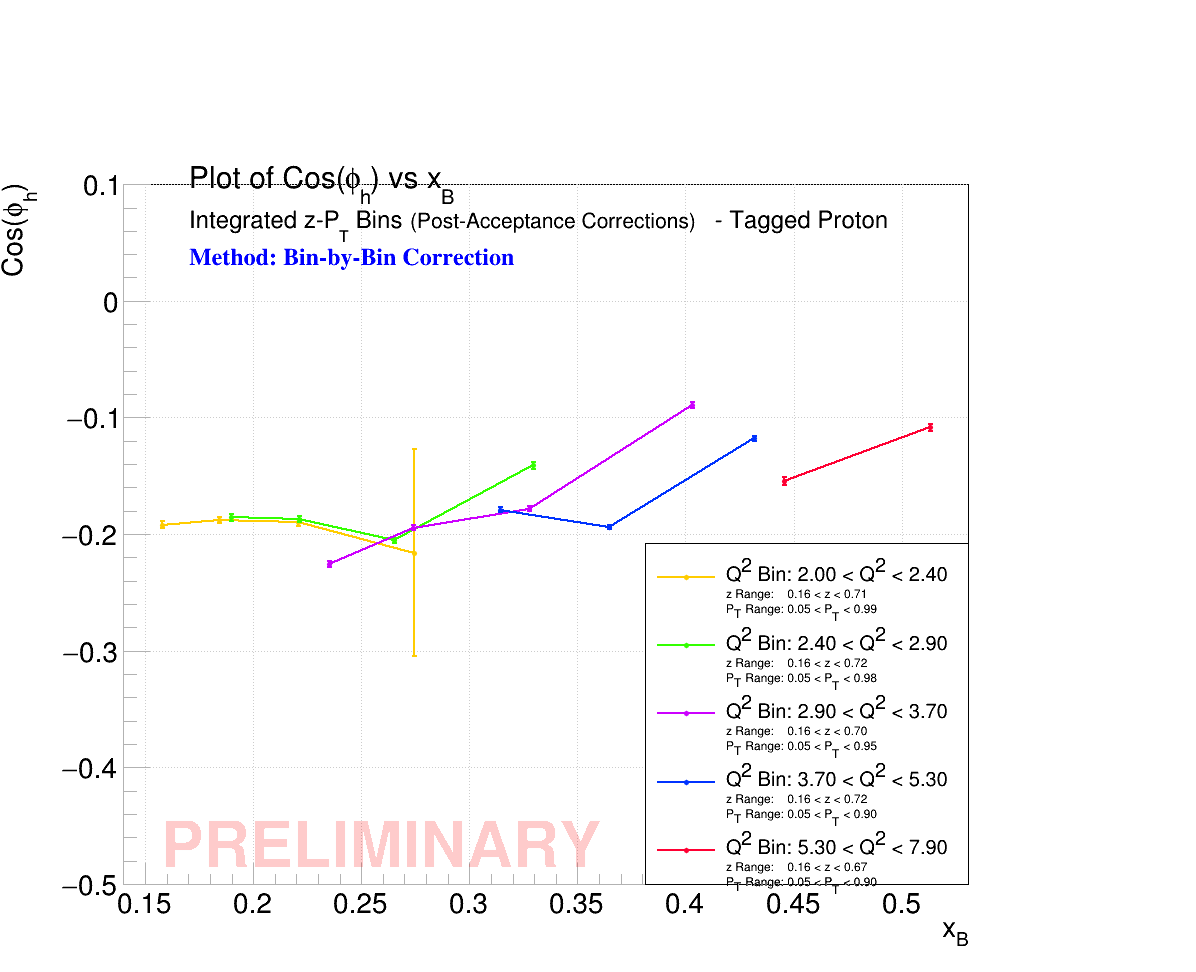

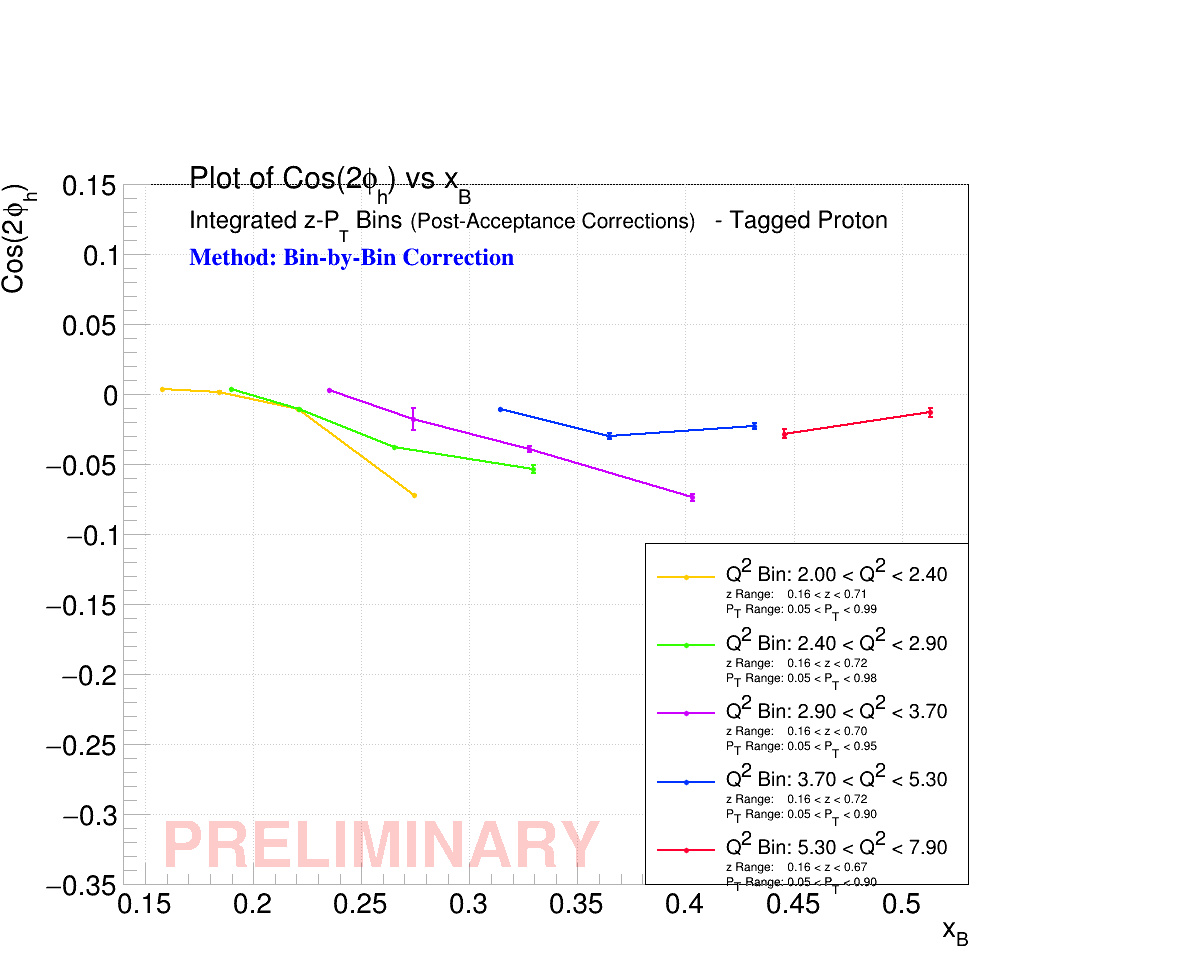

In [87]:
def create_legend(x1, y1, x2, y2, nColumns=1, Legend_Title="Bin (Range) Information"):
    legend_create = ROOT.TLegend(x1, y1, x2, y2)
    legend_create.SetNColumns(nColumns)  # Start with 1 column
    legend_create.SetHeader("".join(["#scale[1.35]{", str(Legend_Title), "}"]), "C") # option "C" allows to center the header
    return legend_create


Make_Plots_Q = True

# Histo_Type = "3D"
Histo_Type = "Skip"
Smear_Type = "SMEARED "
Smear_Type = ""
Fit___Type = "Bin-by-Bin Correction"
# Fit___Type = "Bayesian Unfolding"
# Fit___Type = "Generated Plot"
Parameters_to_Compare = ["B", "C"]
# Parameters_to_Compare = ["B"]

Comparison_Output = {}

Q2_bin_group_list = [1, 2, 3, 4, 5]
y_bin_group_list  = [1, 2, 3, 4]

Q2_bin_group_def = {"Group_1": [1, 2, 3,  4, ""], "Group_2": [5, 6,  7,  8, ""], "Group_3": [9, 10, 11, 12, ""], "Group_4": [13, 14, 15, "", ""], "Group_5": [16, 17, "", ""]}
y__bin_group_def = {"Group_1": [1, 5, 9, 13, 16], "Group_2": [2, 6, 10, 14, 17], "Group_3": [3,  7, 11, 15, ""], "Group_4": [4,   8, 12, "", ""], "Group_5": ["", "", "", ""]}

Extra_Title_Info = ""

for Par___Type      in Parameters_to_Compare:
    for Q2_bin_group in Q2_bin_group_list:
        Q2_y_Bin_Groups = [1, 2, 3, 4] if(Q2_bin_group == 1) else [5, 6, 7, 8] if(Q2_bin_group == 2) else [9, 10, 11, 12] if(Q2_bin_group == 3) else [13, 14, 15] if(Q2_bin_group == 4) else [16, 17]
        Comparison_Output[f"Par_{Par___Type}_Q2_Bin_{Q2_bin_group}"] = []
        for Q2_y_Bin     in Q2_y_Bin_Groups:
            y_bin_group   = 1 if(Q2_y_Bin in [1, 5, 9, 13, 16]) else 2 if(Q2_y_Bin in [2, 6, 10, 14, 17])                 else 3 if(Q2_y_Bin in [3, 7, 11, 15]) else 4
            num_pT_cols   = 7 if(Q2_y_Bin in [1, 9])            else 6 if(Q2_y_Bin in [2, 3, 4, 5, 6, 7, 10, 14, 16, 17]) else 5
            z_row, pT_col = 0, 0
            try:
                type(Comparison_Output[f"Par_{Par___Type}_y_Bin_{y_bin_group}"])
            except:
                Comparison_Output[f"Par_{Par___Type}_y_Bin_{y_bin_group}"] = []
            for z_pT_Bin    in range(0, Get_Num_of_z_pT_Bins_w_Migrations(Q2_y_Bin_Num_In=Q2_y_Bin)[1]+1):
                if(z_pT_Bin   in [-1]):
                    z_pT_Bin = "Integrated"
                    Extra_Title_Info = "Integrated z-P_{T} Bins #scale[0.9]{(Post-Acceptance Corrections)}"
                elif(z_pT_Bin in [0]):
                    z_pT_Bin = "All"
                    Extra_Title_Info = ""
                    z_pT_Bin = "Integrated"
                    Extra_Title_Info = "Integrated z-P_{T} Bins #scale[0.9]{(Post-Acceptance Corrections)}"
                else:
                    if((z_pT_Bin-1)%num_pT_cols == 0):
                        z_row += 1
                        pT_col = 0
                    pT_col += 1
                if(skip_condition_z_pT_bins(Q2_Y_BIN=Q2_y_Bin, Z_PT_BIN=z_pT_Bin, BINNING_METHOD="Y_bin")):
                    continue
                Bin___Type = f"{Smear_Type}Q2-y Bin {Q2_y_Bin} - z-PT Bin {z_pT_Bin}"
                Moment_Value, Moment_Value_Error = Full_Search_Parameter(Parameter_File_str=file_content, Bin_Info=Bin___Type, Histogram_Type=Histo_Type, Fit_Type=Fit___Type, Parameter=Par___Type, return_err=True)
                if("ERROR" in [Moment_Value, Moment_Value_Error]):
                    print(f"{color.Error}{Bin___Type}{color.END}")
                    print(f"{color.Error}Moment_Value       = {Moment_Value}{color.END}")
                    print(f"{color.Error}Moment_Value_Error = {Moment_Value_Error}{color.END}")
                else:
                    Appending_Bin_Info = [float(Moment_Value), float(Moment_Value_Error), Q2_y_Bin, z_pT_Bin]
                    for bin_group, group_num, color_group in [["Q2", Q2_bin_group, Q2_bin_group_def], ["y", y_bin_group, y__bin_group_def]]:
                        color_ii = ROOT.kOrange if(group_num in [1])                                    else ROOT.kSpring if(group_num in [2])                                    else ROOT.kViolet if(group_num in [3])                                    else ROOT.kAzure if(group_num in [4])                                    else ROOT.kPink
                        color_jj = ROOT.kOrange if(Q2_y_Bin  in [color_group[f"Group_{group_num}"][0]]) else ROOT.kSpring if(Q2_y_Bin  in [color_group[f"Group_{group_num}"][1]]) else ROOT.kViolet if(Q2_y_Bin  in [color_group[f"Group_{group_num}"][2]]) else ROOT.kAzure if(Q2_y_Bin  in [color_group[f"Group_{group_num}"][3]]) else ROOT.kPink
                        if(z_pT_Bin in ["All", 0, "0", "Integrated"]):
                            Comparison_Output[f"Par_{Par___Type}_{bin_group}_Bin_{group_num}"].append([Appending_Bin_Info, color_ii])
                        else:
                            try:
                                Comparison_Output[f"Par_{Par___Type}_{bin_group}_Bin_{group_num}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}"].append([Appending_Bin_Info,   color_jj + z_row  + 1])
                            except:
                                Comparison_Output[f"Par_{Par___Type}_{bin_group}_Bin_{group_num}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}"]   = []
                                Comparison_Output[f"Par_{Par___Type}_{bin_group}_Bin_{group_num}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}"].append([Appending_Bin_Info,   color_jj + z_row  + 1])
                            try:
                                Comparison_Output[f"Par_{Par___Type}_{bin_group}_Bin_{group_num}_Q2_y_Bin_{Q2_y_Bin}_pT_Bin_{pT_col}"].append([Appending_Bin_Info, color_jj + pT_col + 1])
                            except:
                                Comparison_Output[f"Par_{Par___Type}_{bin_group}_Bin_{group_num}_Q2_y_Bin_{Q2_y_Bin}_pT_Bin_{pT_col}"] = []
                                Comparison_Output[f"Par_{Par___Type}_{bin_group}_Bin_{group_num}_Q2_y_Bin_{Q2_y_Bin}_pT_Bin_{pT_col}"].append([Appending_Bin_Info, color_jj + pT_col + 1])


# for ii in Comparison_Output:
#     print(f"\n\n{ii}:\n\t{Comparison_Output[ii]}")

if(Make_Plots_Q):
    y_values = {}
    y_errors = {}
    x_values = {}
    x_errors = {}
    n_points = {}
    graph    = {}
    canvas   = {}
    multi_graph = {}
    legend   = {}
    latex    = {}
    multi_graph_canvas = {}

    # # # 'Group_to_Plot' determines whether the Q2 rows are used or if the y columns are looped over
    Group_to_Plot = "Q2"
#     Group_to_Plot = "y"


    bin_group_list = Q2_bin_group_list if(Group_to_Plot in ["Q2"]) else y_bin_group_list

    # Do not let Group_to_Plot = Function_of_Variable
    Function_of_Variable = "Q2"
    Function_of_Variable = "y"
    Function_of_Variable = "xB"


    if(Function_of_Variable in [Group_to_Plot]):
        raise("Do not let Group_to_Plot = Function_of_Variable")


    for Par___Type in Parameters_to_Compare:
        multi_graph[Par___Type] = ROOT.TMultiGraph()
        multi_graph[Par___Type].SetName(Par___Type)
        TitleMG = "".join(["#splitline{#splitline{#scale[1.25]{Plot of ", "Cos(#phi_{h})" if(Par___Type in ["B"]) else "Cos(2#phi_{h})", " vs ", Function_of_Variable if(Function_of_Variable not in ["Q2", "xB"]) else "x_{B}" if(Function_of_Variable in ["xB"]) else "Q^{2}", "}}{Integrated z-P_{T} Bins}}{", str(root_color.Bold), "{#color[", str(root_color.Blue), "]{Method: ", str(Fit___Type), "}}}"])
        if(Extra_Title_Info not in [""]):
            TitleMG = str(TitleMG.replace("Integrated z-P_{T} Bins", "".join([str(Extra_Title_Info), " - Tagged Proton" if(Tagged_Proton_Q) else ""])))
        elif(Tagged_Proton_Q):
            TitleMG = str(TitleMG.replace("Integrated z-P_{T} Bins}", "Integrated z-P_{T} Bins#scale[0.85]{ - Tagged Proton}}"))
        multi_graph[Par___Type].SetTitle(TitleMG)
#         legend[Par___Type] = ROOT.TLegend(0.6, 0.1, 0.9, 0.4)
        legend[Par___Type] = ROOT.TLegend(0.6, 0.1, 0.9, 0.49)
        for bin_group in bin_group_list:
            # Separate the data into y_values, y_errors, and x_values
            key = f"Par_{Par___Type}_{Group_to_Plot}_Bin_{bin_group}"
            color_ii = Comparison_Output[key][0][1]
            y_values[key] = array('d', [point[0][0] for point in Comparison_Output[key]])
            y_errors[key] = array('d', [point[0][1] for point in Comparison_Output[key]])
            x_values[key] = array('d', [Get_Bin_Center_Function(Q2_y_Bin=point[0][2], z_pT_Bin=point[0][3], Variable=f"mean_{Function_of_Variable}")  for point in Comparison_Output[key]])
            x_errors[key] = array('d', [Get_Bin_Center_Function(Q2_y_Bin=point[0][2], z_pT_Bin=point[0][3], Variable=f"Error_{Function_of_Variable}") for point in Comparison_Output[key]])

            # Create a TGraphErrors object
            n_points[key] = len(Comparison_Output[key])
            graph[key] = ROOT.TGraphErrors(n_points[key], x_values[key], y_values[key], x_errors[key], y_errors[key])

            # Customize the graph
            bin_title = str(Q2_y_bin_values_New(Q2_Y_Bin_Num=Comparison_Output[key][0][0][2], return_type=Group_to_Plot)).replace("Q2", "Q^{2}")
            
            Binning_Title = "".join([Function_of_Variable if(Function_of_Variable not in ["Q2"]) else "Q^{2}", " Bin: ", str(bin_title), " #topbar Integrated z-P_{T} Bins"])
            Title = "".join(["#splitline{#splitline{#scale[1.25]{Plot of ", "Cos(#phi_{h})" if(Par___Type in ["B"]) else "Cos(2#phi_{h})", "}}{", Binning_Title, "}}{", str(root_color.Bold), "{#color[", str(root_color.Blue), "]{Method: ", str(Fit___Type), "}}}"])
            if(Extra_Title_Info not in [""]):
                Title = "".join(["#splitline{", str(Title), "}{", str(Extra_Title_Info), " - Tagged Proton" if(Tagged_Proton_Q) else "", "}"])
            graph[key].SetTitle(str(Title))
            graph[key].GetXaxis().SetTitle("".join([Function_of_Variable if(Function_of_Variable not in ["Q2", "xB"]) else "x_{B}" if(Function_of_Variable in ["xB"]) else "Q^{2}", " (Smeared)" if(Smear_Type not in [""]) else ""]))
            graph[key].GetYaxis().SetTitle("Cos(#phi_{h})" if(Par___Type in ["B"]) else "Cos(2#phi_{h})")
            graph[key].SetMarkerStyle(8)
            graph[key].SetMarkerSize(0.5)
            graph[key].SetLineWidth(2)
            graph[key].SetLineColor(color_ii)
            graph[key].SetMarkerColor(color_ii)

            # Add the graph to the TMultiGraph
            multi_graph[Par___Type].Add(graph[key])
#             legend_title = "".join([Group_to_Plot if(Group_to_Plot not in ["Q2"]) else "Q^{2}", " Bin: #scale[0.75]{", str(bin_title), "}"])
            legend_title = "".join([Group_to_Plot if(Group_to_Plot not in ["Q2"]) else "Q^{2}", " Bin: ", str(bin_title)])
            Integrated_z__range = z_pT_bin_values_New(Q2_Y_Bin_Num=Comparison_Output[key][0][0][2], Bin=0, return_type="z_Max")
            Integrated_pT_range = z_pT_bin_values_New(Q2_Y_Bin_Num=Comparison_Output[key][0][0][2], Bin=0, return_type="pT_Max")
            legend_title = "".join(["#scale[0.35]{#splitline{", str(legend_title), "}{#scale[0.6]{#splitline{z Range:    ", str(Integrated_z__range), "}{P_{T} Range: ", str(Integrated_pT_range), "}}}}"])
            legend[Par___Type].AddEntry(graph[key], legend_title, "lp")

            # Create a canvas and draw the individual graph
            canvas[key] = Canvas_Create(Name=key, Num_Columns=1, Num_Rows=1, Size_X=800, Size_Y=600, cd_Space=0)
            Draw_Canvas(canvas=canvas[key], cd_num=1, left_add=0.115, right_add=0.1, up_add=0.1, down_add=0.1)
            graph[key].Draw("APL")
            graph[key].GetYaxis().SetRangeUser(-0.9 if(str(Par___Type) in ["B"]) else -0.35, 0.2 if(str(Par___Type) in ["B"]) else 0.25)
#             graph[key].GetYaxis().SetRangeUser(-1.0 if(str(Par___Type) in ["B"]) else -0.45, 0.2 if(str(Par___Type) in ["B"]) else 0.25)
    #         canvas[key].Draw()

        # Create a canvas for the TMultiGraph for the current Par___Type
        multi_graph_canvas[Par___Type] = Canvas_Create(Name=f"Combined_Plot_{Par___Type}", Num_Columns=1, Num_Rows=1, Size_X=1200, Size_Y=1000, cd_Space=0)
        Draw_Canvas(canvas=multi_graph_canvas[Par___Type], cd_num=1, left_add=0.115, right_add=0.1, up_add=0.1, down_add=0.1)
        multi_graph[Par___Type].Draw("APL")
#         multi_graph[Par___Type].GetYaxis().SetRangeUser(-0.4 if(str(Par___Type) in ["B"]) else -0.25, 0.1 if(str(Par___Type) in ["B"]) else 0.15)
        multi_graph[Par___Type].GetYaxis().SetRangeUser(-0.5 if(str(Par___Type) in ["B"]) else -0.35, 0.1 if(str(Par___Type) in ["B"]) else 0.15)
        multi_graph[Par___Type].GetXaxis().SetTitle("".join([Function_of_Variable if(Function_of_Variable not in ["Q2", "xB"]) else "x_{B}" if(Function_of_Variable in ["xB"]) else "Q^{2}", " (Smeared)" if(Smear_Type not in [""]) else ""]))
        multi_graph[Par___Type].GetYaxis().SetTitle("Cos(#phi_{h})" if(Par___Type in ["B"]) else "Cos(2#phi_{h})")
        legend[Par___Type].Draw()

        latex[Par___Type] = ROOT.TLatex()
        latex[Par___Type].SetTextSize(0.08)
        latex[Par___Type].SetTextColorAlpha(ROOT.kRed, 0.2)
        latex[Par___Type].DrawTextNDC(0.15, 0.12, "PRELIMINARY")  # Normalized coordinates

        # Customize the combined plot (set title, axis labels, etc.)
        multi_graph_canvas[Par___Type].Update()
        multi_graph_canvas[Par___Type].Draw()
        save_name = "".join(["Fit_Par_", str(Par___Type), "_METHOD_SMEAR_phi_t_VS_", str(Function_of_Variable), "_in_", str(Group_to_Plot), "_Bins.pdf"])
        save_name = save_name.replace("METHOD", "Bin" if(Fit___Type in ["Bin-by-Bin Correction"]) else "Bayesian" if(Fit___Type in ["Bayesian Unfolding"]) else "OTHER")
        save_name = save_name.replace("_SMEAR_", "_" if(Smear_Type in [""]) else "_Smear_")
        if(Extra_Title_Info not in [""]):
            save_name = f"Integrated_{save_name}"
        if(Tagged_Proton_Q):
            save_name = f"Tagged_Proton_{save_name}"
            
        # save_name = str(save_name).replace("Par_B", "Cos_phi")
        # save_name = str(save_name).replace("Par_C", "Cos2phi")

        # Saving Plots
        if(True):
            print(f"{color.BBLUE}SAVING: {color.UNDERLINE}{save_name}{color.END}")
            multi_graph_canvas[Par___Type].SaveAs(save_name)
        else:
            print(f"Not Saving: {save_name}")
else:
    print(f"\n{color.RED}Not making plots right now (set 'Make_Plots_Q = True' to make them){color.END}\n")


    
    
# Initialize variables
Legend_Groups = {}
dummy_objects = {}
data_points_for_plotting = {}
max_rows_per_column = 7  # Set the max number of rows per column

for Par___Type in Parameters_to_Compare:
    for Q2_bin_group in Q2_bin_group_list:
        Q2_y_Bin_Groups = [1, 2, 3, 4] if(Q2_bin_group == 1) else [5, 6, 7, 8] if(Q2_bin_group == 2) else [9, 10, 11, 12] if(Q2_bin_group == 3) else [13, 14, 15] if(Q2_bin_group == 4) else [16, 17]
        for Q2_y_Bin     in Q2_y_Bin_Groups:
            y_bin_group   = 1 if(Q2_y_Bin in [1, 5, 9, 13, 16]) else 2 if(Q2_y_Bin in [2, 6, 10, 14, 17])                 else 3 if(Q2_y_Bin in [3, 7, 11, 15]) else 4
            for bin_group, group_num, color_group in [["Q2", Q2_bin_group, Q2_bin_group_def], ["y", y_bin_group, y__bin_group_def]]:
                color_ii = ROOT.kOrange if(Q2_y_Bin  in [color_group[f"Group_{group_num}"][0]]) else ROOT.kSpring if(Q2_y_Bin  in [color_group[f"Group_{group_num}"][1]]) else ROOT.kViolet if(Q2_y_Bin  in [color_group[f"Group_{group_num}"][2]]) else ROOT.kAzure if(Q2_y_Bin  in [color_group[f"Group_{group_num}"][3]]) else ROOT.kPink
                try:
                    # Legend_Groups[f"{bin_group}_Bin_All"]
                    Legend_Groups[f"{bin_group}_Bin_Integrated"]
                except:
                    # print(f"\nCreating {color.BOLD}'{bin_group}_Bin_{group_num}'{color.END}\n")
                    # Legend_Groups[f"{bin_group}_Bin_All"] = create_legend(0.01, 0.05, 0.95, 0.95, nColumns=1, Legend_Title=str("".join([str(bin_group).replace("Q2", "Q^{2}"), " Bin Ranges Information"])))
                    # Legend_Groups[f"{bin_group}_Bin_All"].SetName(f"{bin_group}_Bin_All")
                    Legend_Groups[f"{bin_group}_Bin_Integrated"] = create_legend(0.01, 0.05, 0.95, 0.95, nColumns=1, Legend_Title=str("".join([str(bin_group).replace("Q2", "Q^{2}"), " Bin Ranges Information"])))
                    Legend_Groups[f"{bin_group}_Bin_Integrated"].SetName(f"{bin_group}_Bin_Integrated")
                for ii in Comparison_Output[f"Par_{Par___Type}_{bin_group}_Bin_{group_num}"]:
                    try:
                        if(ii not in data_points_for_plotting[f"{Par___Type}_{bin_group}"]):
                            data_points_for_plotting[f"{Par___Type}_{bin_group}"].append(ii)
                        # else:
                        #     print(f"\n{color.Error}'{ii}' is already in data_points_for_plotting[...]{color.END}\n")
                    except:
                        data_points_for_plotting[f"{Par___Type}_{bin_group}"] = [ii]

                # Add entry to legend if the color changes
                if(f"{bin_group}_Group_color_{color_ii}" not in dummy_objects):
                    # Create dummy TGraph if it doesn't exist for this color
                    dummy_objects[f"{bin_group}_Group_color_{color_ii}"] = ROOT.TGraph()
                    dummy_objects[f"{bin_group}_Group_color_{color_ii}"].SetMarkerColor(color_ii)
                    dummy_objects[f"{bin_group}_Group_color_{color_ii}"].SetLineColor(color_ii)
                    dummy_objects[f"{bin_group}_Group_color_{color_ii}"].SetMarkerStyle(20)

                    # Add the entry to the legend
                    Legend_title = "".join(["#splitline{#scale[0.75]{Q^{2}-y Bin ", str(Q2_y_Bin), "}}{#scale[0.65]{Ave x_{B}: ", str(Get_Bin_Center_Function(Q2_y_Bin=Q2_y_Bin, z_pT_Bin="All", Variable="mean_xB")), "}}"])
    #                 Legend_title = "".join(["#splitline{", str(Legend_title), "}{#scale[0.65]{", str(Q2_y_bin_values_New(Q2_Y_Bin_Num=Q2_y_Bin,            return_type="y" if(bin_group in ["Q2"]) else "Q2")), "}}"])
                    Legend_title = "".join(["#splitline{", str(Legend_title), "}{#scale[0.65]{", str(Q2_y_bin_values_New(Q2_Y_Bin_Num=Q2_y_Bin,            return_type=bin_group)), "}}"])
                    Legend_title = Legend_title.replace("Q2", "Q^{2}")
                    # Legend_Groups[f"{bin_group}_Bin_All"].AddEntry(dummy_objects[f"{bin_group}_Group_color_{color_ii}"], Legend_title, "PL")
                    Legend_Groups[f"{bin_group}_Bin_Integrated"].AddEntry(dummy_objects[f"{bin_group}_Group_color_{color_ii}"], Legend_title, "PL")


    for Q2_bin_group in Q2_bin_group_list:
        Q2_y_Bin_Groups = [1, 2, 3, 4] if(Q2_bin_group == 1) else [5, 6, 7, 8] if(Q2_bin_group == 2) else [9, 10, 11, 12] if(Q2_bin_group == 3) else [13, 14, 15] if(Q2_bin_group == 4) else [16, 17]
        for Q2_y_Bin     in Q2_y_Bin_Groups:
            y_bin_group   = 1 if(Q2_y_Bin in [1, 5, 9, 13, 16]) else 2 if(Q2_y_Bin in [2, 6, 10, 14, 17])                 else 3 if(Q2_y_Bin in [3, 7, 11, 15]) else 4
            for bin_group, group_num, color_group in [["Q2", Q2_bin_group, Q2_bin_group_def], ["y", y_bin_group, y__bin_group_def]]:
                color_ii = ROOT.kOrange if(Q2_y_Bin  in [color_group[f"Group_{group_num}"][0]]) else ROOT.kSpring if(Q2_y_Bin  in [color_group[f"Group_{group_num}"][1]]) else ROOT.kViolet if(Q2_y_Bin  in [color_group[f"Group_{group_num}"][2]]) else ROOT.kAzure if(Q2_y_Bin  in [color_group[f"Group_{group_num}"][3]]) else ROOT.kPink
                ############################################
                ###==========###   z-Bins   ###==========###
                ############################################
                try:
                    Legend_Groups[f"{bin_group}_Bin_{group_num}_z_Bins"]
                except:
                    # print(f"\nCreating {color.BOLD}'{bin_group}_Bin_{group_num}_z_Bins'{color.END}\n")
                    Legend_Groups[f"{bin_group}_Bin_{group_num}_z_Bins"] = create_legend(0.01, 0.05, 0.95, 0.95, nColumns=max_rows_per_column, Legend_Title=str("".join(["#splitline{", str(bin_group).replace("Q2", "Q^{2}"), " and z Bin Ranges Information}{#scale[0.65]{x_{B} Info given relative to the Integratated z-P_{T} Bins}}"])))
                    Legend_Groups[f"{bin_group}_Bin_{group_num}_z_Bins"].SetName(f"{bin_group}_Bin_{group_num}_z_Bins")
                for z_row in range(1, max_rows_per_column + 1):
                    try:
    #                     print(f"Adding: Comparison_Output['Par_{Par___Type}_{bin_group}_Bin_{group_num}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}'] (type:", type(Comparison_Output[f'Par_{Par___Type}_{bin_group}_Bin_{group_num}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}']), f""")
    # \tAdding: '{bin_group}_Group_{group_num}_z_row_{color_ii + z_row + 1}'""")
    #                     type(Comparison_Output[f'Par_{Par___Type}_{bin_group}_Bin_{group_num}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}'])
                        for ii in Comparison_Output[f"Par_{Par___Type}_{bin_group}_Bin_{group_num}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}"]:
    #                         jj = ii.copy()
    #                         jj.append(color_ii + z_row + 1)
                            try:
                                if(ii not in data_points_for_plotting[f"{Par___Type}_{bin_group}_Bin_{group_num}_z_Bins"]):
                                    data_points_for_plotting[f"{Par___Type}_{bin_group}_Bin_{group_num}_z_Bins"].append(ii)
                            except:
                                data_points_for_plotting[f"{Par___Type}_{bin_group}_Bin_{group_num}_z_Bins"] = [ii]


                        # Add entry to legend if the color changes
                        if(f"{bin_group}_Group_{group_num}_z_row_{color_ii + z_row + 1}" not in dummy_objects):
                            # Create dummy TGraph if it doesn't exist for this color
                            dummy_objects[f"{bin_group}_Group_{group_num}_z_row_{color_ii + z_row + 1}"] = ROOT.TGraph()
                            dummy_objects[f"{bin_group}_Group_{group_num}_z_row_{color_ii + z_row + 1}"].SetMarkerColor(color_ii + z_row + 1)
                            dummy_objects[f"{bin_group}_Group_{group_num}_z_row_{color_ii + z_row + 1}"].SetLineColor(color_ii   + z_row + 1)
                            dummy_objects[f"{bin_group}_Group_{group_num}_z_row_{color_ii + z_row + 1}"].SetMarkerStyle(20)

                            # Add the entry to the legend
                            Legend_title = "".join(["#splitline{#scale[0.75]{Q^{2}-y Bin ", str(Q2_y_Bin), "}}{#scale[0.65]{Ave x_{B}: ", str(Get_Bin_Center_Function(Q2_y_Bin=Q2_y_Bin, z_pT_Bin="All", Variable="mean_xB")), "}}"])
                            Legend_title = "".join(["#splitline{", str(Legend_title), "}{#scale[0.65]{", str(Q2_y_bin_values_New(Q2_Y_Bin_Num=Q2_y_Bin,            return_type=bin_group)), "}}"])
                            Legend_title = "".join(["#splitline{", str(Legend_title), "}{#scale[0.65]{", str(z_pT_bin_values_New(Q2_Y_Bin_Num=Q2_y_Bin, Bin=z_row, return_type="z")),       "}}"])
                            Legend_title = Legend_title.replace("Q2", "Q^{2}")
                            Legend_Groups[f"{bin_group}_Bin_{group_num}_z_Bins"].AddEntry(dummy_objects[f"{bin_group}_Group_{group_num}_z_row_{color_ii + z_row + 1}"], Legend_title, "PL")
                    except:
                        # print(f"{color.RED}No 'Par_{Par___Type}_{bin_group}_Bin_{group_num}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}' in 'Comparison_Output'{color.END}")
                        # Fill the rest of the row with blank entries
                        if(z_row not in dummy_objects):
                            dummy_objects[z_row] = ROOT.TGraph()
                            dummy_objects[z_row].SetMarkerColor(0)  # Invisible color
                        Legend_Groups[f"{bin_group}_Bin_{group_num}_z_Bins"].AddEntry(dummy_objects[z_row], "", "P")
                ############################################
                ###==========###   pT-Bins   ###==========###
                ############################################
                try:
                    Legend_Groups[f"{bin_group}_Bin_{group_num}_pT_Bins"]
                except:
                    Legend_Groups[f"{bin_group}_Bin_{group_num}_pT_Bins"] = create_legend(0.01, 0.05, 0.95, 0.95, nColumns=max_rows_per_column, Legend_Title=str("".join(["#splitline{", str(bin_group).replace("Q2", "Q^{2}"), " and P_{T} Bin Ranges Information}{#scale[0.65]{x_{B} Info given relative to the Integratated z-P_{T} Bins}}"])))
                    Legend_Groups[f"{bin_group}_Bin_{group_num}_pT_Bins"].SetName(f"{bin_group}_Bin_{group_num}_pT_Bins")
                for pT_row in range(1, max_rows_per_column + 1):
                    try:
                        # type(Comparison_Output[f'Par_{Par___Type}_{bin_group}_Bin_{group_num}_Q2_y_Bin_{Q2_y_Bin}_pT_Bin_{pT_row}'])
                        for ii in Comparison_Output[f"Par_{Par___Type}_{bin_group}_Bin_{group_num}_Q2_y_Bin_{Q2_y_Bin}_pT_Bin_{pT_row}"]:
    #                         jj = ii.copy()
    #                         jj.append(color_ii + pT_row + 1)
                            try:
                                if(ii not in data_points_for_plotting[f"{Par___Type}_{bin_group}_Bin_{group_num}_pT_Bins"]):
                                    data_points_for_plotting[f"{Par___Type}_{bin_group}_Bin_{group_num}_pT_Bins"].append(ii)
                            except:
                                data_points_for_plotting[f"{Par___Type}_{bin_group}_Bin_{group_num}_pT_Bins"] = [ii]

                        # Add entry to legend if the color changes
                        if(f"{bin_group}_Group_{group_num}_pT_row_{color_ii + pT_row + 1}" not in dummy_objects):
                            # Create dummy TGraph if it doesn't exist for this color
                            dummy_objects[f"{bin_group}_Group_{group_num}_pT_row_{color_ii + pT_row + 1}"] = ROOT.TGraph()
                            dummy_objects[f"{bin_group}_Group_{group_num}_pT_row_{color_ii + pT_row + 1}"].SetMarkerColor(color_ii + pT_row + 1)
                            dummy_objects[f"{bin_group}_Group_{group_num}_pT_row_{color_ii + pT_row + 1}"].SetLineColor(color_ii   + pT_row + 1)
                            dummy_objects[f"{bin_group}_Group_{group_num}_pT_row_{color_ii + pT_row + 1}"].SetMarkerStyle(20)

                            # Add the entry to the legend
                            Legend_title = "".join(["#splitline{#scale[0.75]{Q^{2}-y Bin ", str(Q2_y_Bin), "}}{#scale[0.65]{Ave x_{B}: ", str(Get_Bin_Center_Function(Q2_y_Bin=Q2_y_Bin, z_pT_Bin="All", Variable="mean_xB")), "}}"])
                            Legend_title = "".join(["#splitline{", str(Legend_title), "}{#scale[0.65]{", str(Q2_y_bin_values_New(Q2_Y_Bin_Num=Q2_y_Bin,            return_type=bin_group)), "}}"])
                            Legend_title = "".join(["#splitline{", str(Legend_title), "}{#scale[0.65]{", str(z_pT_bin_values_New(Q2_Y_Bin_Num=Q2_y_Bin, Bin=pT_row, return_type="pT")),       "}}"])
                            Legend_title = Legend_title.replace("Q2", "Q^{2}")
                            Legend_title = Legend_title.replace("pT", "P_{T}")
                            Legend_Groups[f"{bin_group}_Bin_{group_num}_pT_Bins"].AddEntry(dummy_objects[f"{bin_group}_Group_{group_num}_pT_row_{color_ii + pT_row + 1}"], Legend_title, "PL")
                    except:
                        # print(f"{color.RED}No 'Par_{Par___Type}_{bin_group}_Bin_{group_num}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}' in 'Comparison_Output'{color.END}")
                        # Fill the rest of the row with blank entries
                        if(pT_row not in dummy_objects):
                            dummy_objects[pT_row] = ROOT.TGraph()
                            dummy_objects[pT_row].SetMarkerColor(0)  # Invisible color
                        Legend_Groups[f"{bin_group}_Bin_{group_num}_pT_Bins"].AddEntry(dummy_objects[pT_row], "", "P")

# for ii in Legend_Groups:
#     print(ii)
# Draw the legend
# canvas = ROOT.TCanvas("legend_canvas", "Legend", 800, 600)
# Legend_Groups[f"Q2_Bin_1_pT_Bins"].Draw()
# canvas.Modified()
# canvas.Update()
# canvas.Draw()


# print("\nDone\n")
    

print("\n\nDONE\n\n")


In [17]:
# for ii in data_points_for_plotting:
#     print(f"\n{ii})\n\t{data_points_for_plotting[ii]}\n")

In [18]:
# # Generic code that is used to show which Q2/y/z/pT row the individual kinematic bin lies in
# Bin_Rows_Output = {}

# Q2_bin_group_list = [1, 2, 3, 4, 5]

# for Q2_bin_group in Q2_bin_group_list:
#     Q2_y_Bin_Groups = [1, 2, 3, 4] if(Q2_bin_group == 1) else [5, 6, 7, 8] if(Q2_bin_group == 2) else [9, 10, 11, 12] if(Q2_bin_group == 3) else [13, 14, 15] if(Q2_bin_group == 4) else [16, 17]
#     Bin_Rows_Output[f"Q2_bin_group_{Q2_bin_group}"] = []
#     for Q2_y_Bin        in Q2_y_Bin_Groups:
#         y_bin_group   = 1 if(Q2_y_Bin in [1, 5, 9, 13, 16]) else 2 if(Q2_y_Bin in [2, 6, 10, 14, 17])                 else 3 if(Q2_y_Bin in [3, 7, 11, 15]) else 4
#         num_pT_cols   = 7 if(Q2_y_Bin in [1, 9])            else 6 if(Q2_y_Bin in [2, 3, 4, 5, 6, 7, 10, 14, 16, 17]) else 5
#         z_row, pT_col = 0, 0
#         try:
#             type(Bin_Rows_Output[f"y_bin_group_{y_bin_group}"])
#         except:
#             Bin_Rows_Output[f"y_bin_group_{y_bin_group}"] = []
#         for z_pT_Bin    in range(0, Get_Num_of_z_pT_Bins_w_Migrations(Q2_y_Bin_Num_In=Q2_y_Bin)[1]+1):
#             if(z_pT_Bin in [0]):
#                 z_pT_Bin = "All"
#             else:
#                 if((z_pT_Bin-1)%num_pT_cols == 0):
#                     z_row += 1
#                     pT_col = 0
#                 pT_col += 1
#             if(skip_condition_z_pT_bins(Q2_Y_BIN=Q2_y_Bin, Z_PT_BIN=z_pT_Bin, BINNING_METHOD="Y_bin")):
#                 continue
#             for bin_group, group_num in [["Q2", Q2_bin_group], ["y", y_bin_group]]:
#                 if(z_pT_Bin in ["All", 0, "0"]):
#                     Bin_Rows_Output[f"{bin_group}_bin_group_{group_num}"].append([["Q2-y Bin", Q2_y_Bin], ["z-pT Bin", z_pT_Bin]])
#                 else:
#                     try:
#                         Bin_Rows_Output[f"{bin_group}_bin_group_{group_num}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}"].append([["Q2-y Bin",   Q2_y_Bin], ["z-pT Bin", z_pT_Bin]])
#                     except:
#                         Bin_Rows_Output[f"{bin_group}_bin_group_{group_num}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}"]   = []
#                     try:
#                         Bin_Rows_Output[f"{bin_group}_bin_group_{group_num}_Q2_y_Bin_{Q2_y_Bin}_pT_Bin_{pT_col}"].append([["Q2-y Bin", Q2_y_Bin], ["z-pT Bin", z_pT_Bin]])
#                     except:
#                         Bin_Rows_Output[f"{bin_group}_bin_group_{group_num}_Q2_y_Bin_{Q2_y_Bin}_pT_Bin_{pT_col}"] = []

                
                
# # # print(f"Bin_Rows_Output = {Bin_Rows_Output}")
# # print("\nBin_Rows_Output = {")
# # for ii in Bin_Rows_Output:
# #     if("Q2_bin" in str(ii)):
# #         print(f"\n'{ii}':\n\t{Bin_Rows_Output[ii]}")
# # print("}")

# print("\nDONE")

## Making 3D Plots

### Q2/y vs xB/z/pT (Integrated z-pT)

In [13]:
# Function to convert 3D to 2D coordinates
def convert_3d_to_2d(view, x, y, z):
    pw = array('d', [x, y, z])
    pn = array('d', [0.0, 0.0, 0.0])
    view.WCtoNDC(pw, pn)
    return pn[0], pn[1]


Par___Type  = "C"

bin_group = "Q2"

var_x = "Q2"
var_y = "xB"

# def Create_3D_Plot_of_Parameters(data_points, Par___Type="B", y_bin_group=1, Fit___Type="Bayesian Unfolding", Smear_Type="SMEARED "):

# data_points = Comparison_Output[f"Par_{Par___Type}_{bin_group}_Bin_{group_num}"]
data_points = data_points_for_plotting[f"{Par___Type}_{bin_group}"]

# Extracting and grouping points by color
grouped_points = {}
for Point_Info, color_ii in data_points:
    z, ez, Q2_y_bin, z_pT_bin = Point_Info
    y, ey = Get_Bin_Center_Function(Q2_y_Bin=Q2_y_bin, z_pT_Bin=z_pT_bin, Variable=f"mean_{var_y}"), Get_Bin_Center_Function(Q2_y_Bin=Q2_y_bin, z_pT_Bin=z_pT_bin, Variable=f"Error_{var_y}")
    x, ex = Get_Bin_Center_Function(Q2_y_Bin=Q2_y_bin, z_pT_Bin=z_pT_bin, Variable=f"mean_{var_x}"), Get_Bin_Center_Function(Q2_y_Bin=Q2_y_bin, z_pT_Bin=z_pT_bin, Variable=f"Error_{var_x}")
    if color_ii not in grouped_points:
        grouped_points[color_ii] = ([], [], [], [], [], [])
    grouped_points[color_ii][0].append(x)
    grouped_points[color_ii][1].append(y)
    grouped_points[color_ii][2].append(z)
    grouped_points[color_ii][3].append(ex)
    grouped_points[color_ii][4].append(ey)
    grouped_points[color_ii][5].append(ez)



# Create a canvas
# canvas = ROOT.TCanvas(f"canvas_Par___Type_{Par___Type}_y_bin_group_{y_bin_group}_Fit___Type_{Fit___Type}_Smear_Type_{Smear_Type}", "3D Graph", 1200, 1000)
canvas = Canvas_Create(Name=f"canvas_Par___Type_{Par___Type}_{bin_group}_Bin_{group_num}_Fit___Type_{Fit___Type}_Smear_Type_{Smear_Type}", Num_Columns=2, Num_Rows=1, Size_X=2000, Size_Y=1200, cd_Space=0.0001)
canvas.cd(2)
Legend_Groups[f"{bin_group}_Bin_All"].Draw()
canvas.cd(1)


# Create an empty histogram with the desired axis ranges
Variable_Plot_Ranges = {"Q2": [2, 7], "y": [0.35, 0.75], "z": [0.1, 0.9], "pT":[0, 1.1] , 'xB': [0.1, 0.8], "B": [-0.2, 0.05], "C": [-0.2, 0.15]}
min_x, max_x = Variable_Plot_Ranges[var_x]
min_y, max_y = Variable_Plot_Ranges[var_y]
min_z, max_z = Variable_Plot_Ranges[Par___Type]

Binning_Title = ""
Title = "".join(["#splitline{#splitline{#scale[1.25]{Plot of ", "Cos(#phi_{h})" if(Par___Type in ["B"]) else "Cos(2#phi_{h})", " vs ", str(var_x), " vs ", str(var_y), "}}{", Binning_Title, "}}{", str(root_color.Bold), "{#color[", str(root_color.Blue), "]{Method: ", str(Fit___Type), "}}}"])
Title = "".join([str(Title), "; ", str(var_x), " ", " (Smeared)" if(Smear_Type not in [""])  else ""])
Title = "".join([str(Title), "; ", str(var_y), " ", " (Smeared)" if(Smear_Type not in [""])  else ""])
Title = "".join([str(Title), "; ", "Cos(#phi_{h})"    if(Par___Type     in ["B"]) else "Cos(2#phi_{h})"])
Title = str(str(str(Title).replace("Q2", "Q^{2}")).replace("pT", "P_{T}")).replace("xB", "x_{B}")

hist = ROOT.TH3F("hist", Title, 10, min_x, max_x, 10, min_y, max_y, 10, min_z, max_z)
hist.Draw("BOX")


# Update the pad to ensure the TView object is created
ROOT.gPad.Update()

# Retrieve the TView object
view = ROOT.gPad.GetView()
if(not view):
    view = ROOT.TView.CreateView(1)
    ROOT.gPad.SetView(view)

# Set the view angles using RotateView
theta =  60 # Angle for rotation around the x-axis
phi   =  80 # Angle for rotation around the y-axis
view.RotateView(theta, phi)

# Update the canvas to reflect the changes
canvas.Modified()
canvas.Update()



# # Create a legend
# legend = ROOT.TLegend(0.75, 0.75, 0.95, 0.95)
# legend.SetHeader("Legend", "C")




# # Create/Draw the TGraph2D on top of the histogram
# graph3d = ROOT.TGraph2D(len(data_points), array('d', [p[4] for p in data_points]), array('d', [p[2] for p in data_points]), array('d', [p[0] for p in data_points]))
# graph3d.Draw("P0 SAME")



# Draw points, lines, and error bars
poly_markers = []
poly_lines = []
text_all = {}
# added_colors = set()

for color_ii, (x_vals, y_vals, z_vals, ex_vals, ey_vals, ez_vals) in grouped_points.items():
#     if(color_ii not in added_colors):
#         dummy_graph = ROOT.TGraph()
#         dummy_graph.SetMarkerColor(color_ii)
#         dummy_graph.SetMarkerStyle(20)
#         legend.AddEntry(dummy_graph, f"Color {color_ii}", "P")
#         added_colors.add(color_ii)

    n_points  = len(x_vals)
    x_values  = array('d', x_vals)
    y_values  = array('d', y_vals)
    z_values  = array('d', z_vals)
    ex_values = array('d', ex_vals)
    ey_values = array('d', ey_vals)
    ez_values = array('d', ez_vals)



    # Create and draw TGraph2DErrors
    graph3d_err = ROOT.TGraph2DErrors(n_points, x_values, y_values, z_values, ex_values, ey_values, ez_values)
    graph3d_err.SetMarkerColor(color_ii)
    graph3d_err.SetMarkerStyle(20)
    graph3d_err.SetMarkerSize(1.5)
    graph3d_err.Draw("P SAME")

    # Draw lines
    polyline = ROOT.TPolyLine3D(n_points)
    for ii in range(n_points):
        polyline.SetPoint(ii, x_vals[ii], y_vals[ii], z_vals[ii])
    polyline.SetLineColor(color_ii)
    polyline.SetLineWidth(2)
    polyline.Draw("SAME")
    poly_lines.append(polyline)



    # Draw points separately to ensure they are on top of the lines
    for x, y, z in zip(x_vals, y_vals, z_vals):
        pm3d = ROOT.TPolyMarker3D(1)
        pm3d.SetPoint(0, x, y, z)
        pm3d.SetMarkerColor(color_ii)
        pm3d.SetMarkerStyle(20)
        pm3d.SetMarkerSize(1.5)
        pm3d.Draw("SAME P")
        poly_markers.append(pm3d)

        # Convert 3D coordinates to 2D
        winx, winy = convert_3d_to_2d(view, x, y, z)

#         # Add text labels with coordinates
# #         label = f"({var_x}:{x:.3f}, {var_y}:{y:.3f}, Moment:{z:.3f})"
#         label = f"({var_x}:{x:.2f}, {var_y}:{y:.2f})"
#         text_all[label] = ROOT.TText(winx, winy, label)
#         text_all[label].SetTextSize(0.01)
#         text_all[label].Draw()


grid_lines = 10  # Number of grid lines

# Draw vertical grid lines
for ii in range(grid_lines + 1):
    x = min_x + (max_x - min_x) / grid_lines * ii
    line = ROOT.TPolyLine3D(2)
    line.SetPoint(0, x, min_y, min_z)
    line.SetPoint(1, x, max_y, min_z)
    line.SetLineColor(17)
    line.SetLineStyle(3)
    line.Draw("SAME")

# Draw horizontal grid lines
for ii in range(grid_lines + 1):
    y = min_y + (max_y - min_y) / grid_lines * ii
    line = ROOT.TPolyLine3D(2)
    line.SetPoint(0, min_x, y, min_z)
    line.SetPoint(1, max_x, y, min_z)
    line.SetLineColor(17)
    line.SetLineStyle(3)
    line.Draw("SAME")


# # Draw the legend
# legend.Draw()

# Update the canvas to display all elements
canvas.Update()
canvas.Draw()

Save_Name = f"Par_{Par___Type}_vs_{var_x}_vs_{var_y}_in_{bin_group}_Groups_for_Integrated_z_pT.pdf"
print(f"Save_Name = {Save_Name}")
if(not True):
    canvas.SaveAs(Save_Name)
else:
    print(f"{color.RED}Did not save{color.END}")


# return canvas
    
# print("Done")

# canvas_out = Create_3D_Plot_of_Parameters(data_points=data_points_temp[Par___Type], Par___Type="B", y_bin_group=1, Fit___Type="Bayesian Unfolding", Smear_Type="SMEARED ")
# canvas_out.Draw()

KeyError: 'Q2_Bin_All'

### Q2/y vs xB/z/pT (Individual z-pT)

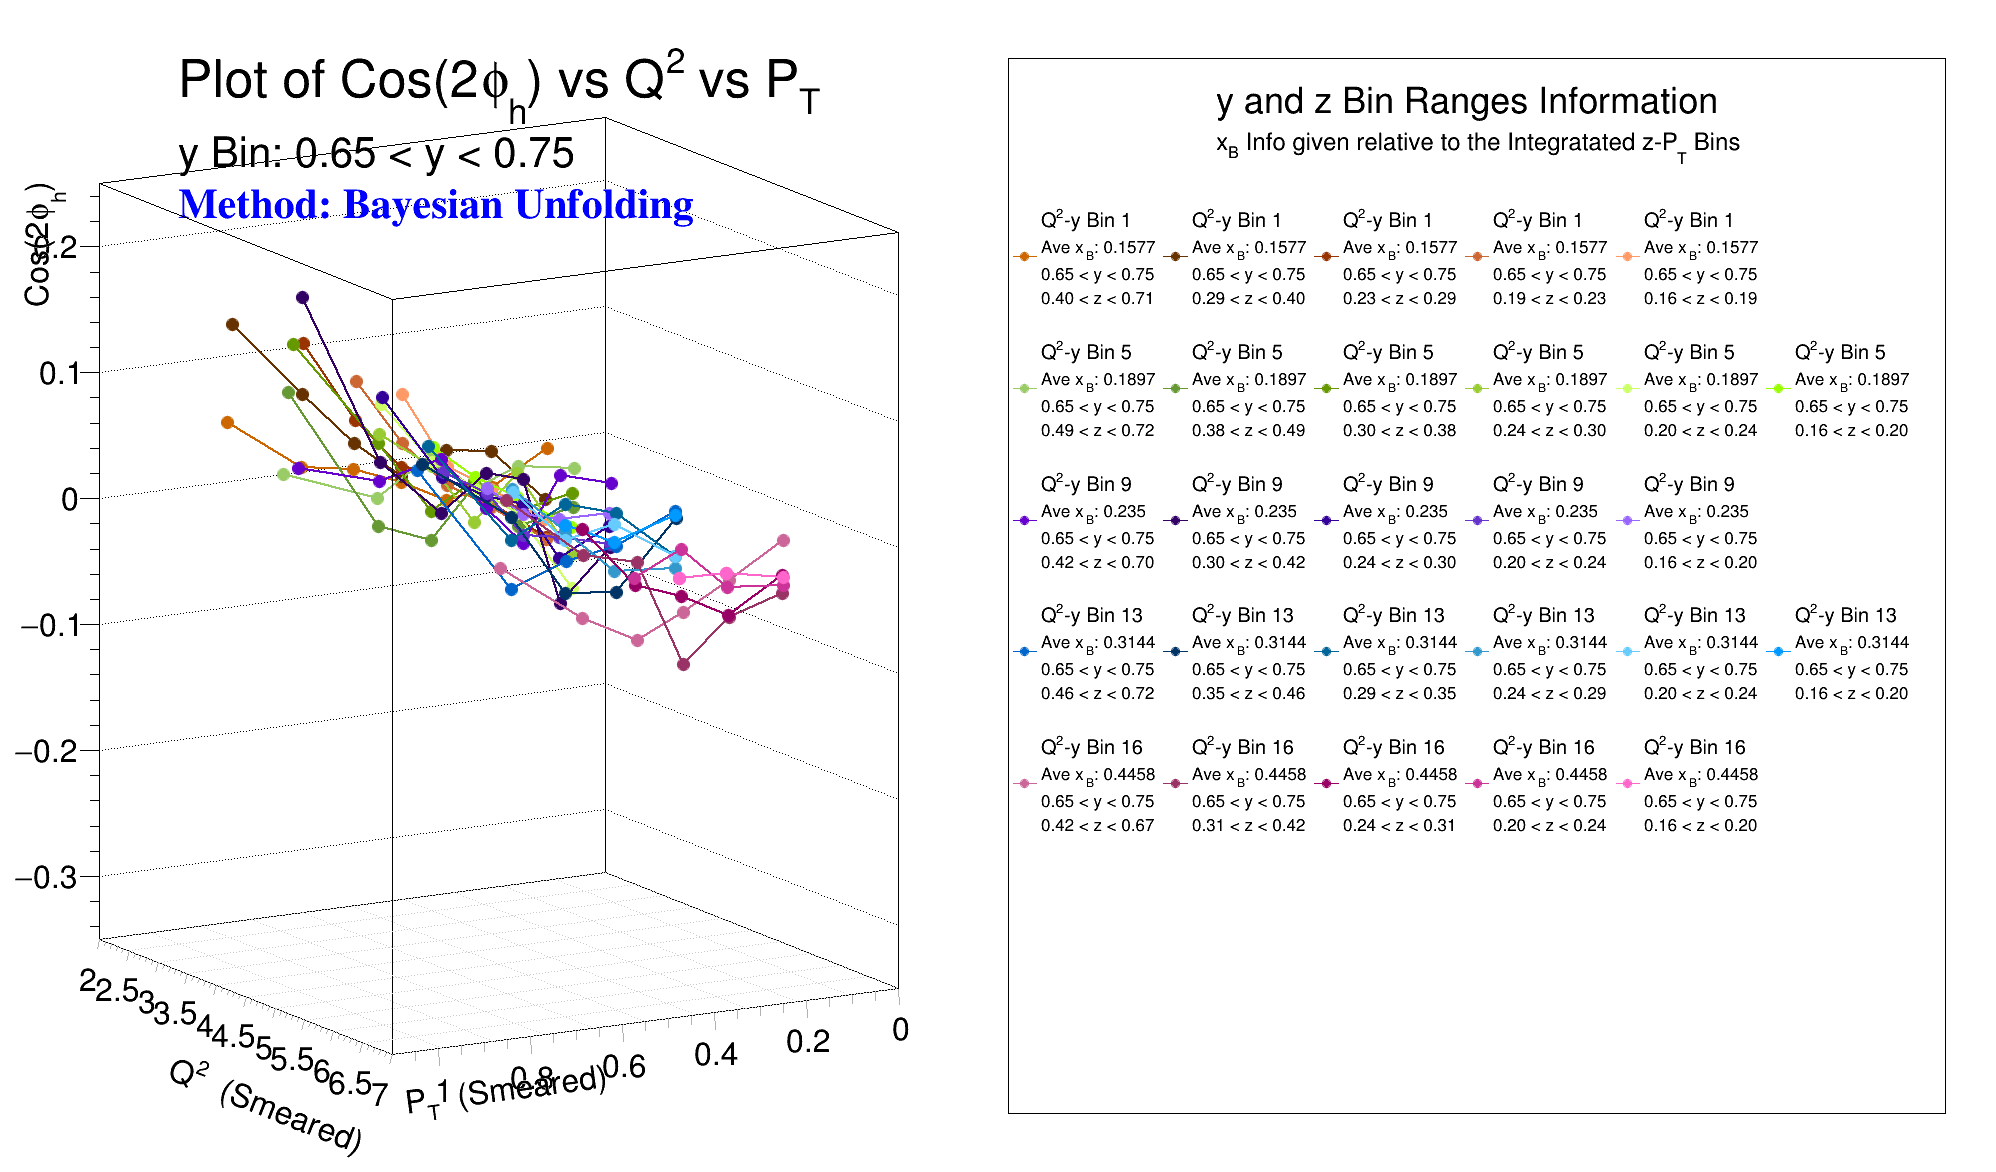

In [20]:
Par___Type  = "C"

bin_group = "y"
group_num = 1

var_group = "z"


var_x = "pT"
var_y = "Q2"

# def Create_3D_Plot_of_Parameters(data_points, Par___Type="B", y_bin_group=1, Fit___Type="Bayesian Unfolding", Smear_Type="SMEARED "):

data_points = data_points_for_plotting[f"{Par___Type}_{bin_group}_Bin_{group_num}_{var_group}_Bins"]

# Extracting and grouping points by color
grouped_points = {}
for Point_Info, color_ii in data_points:
    z, ez, Q2_y_bin, z_pT_bin = Point_Info
    y, ey = Get_Bin_Center_Function(Q2_y_Bin=Q2_y_bin, z_pT_Bin=z_pT_bin, Variable=f"mean_{var_y}"), Get_Bin_Center_Function(Q2_y_Bin=Q2_y_bin, z_pT_Bin=z_pT_bin, Variable=f"Error_{var_y}")
    x, ex = Get_Bin_Center_Function(Q2_y_Bin=Q2_y_bin, z_pT_Bin=z_pT_bin, Variable=f"mean_{var_x}"), Get_Bin_Center_Function(Q2_y_Bin=Q2_y_bin, z_pT_Bin=z_pT_bin, Variable=f"Error_{var_x}")
    if color_ii not in grouped_points:
        grouped_points[color_ii] = ([], [], [], [], [], [])
    grouped_points[color_ii][0].append(x)
    grouped_points[color_ii][1].append(y)
    grouped_points[color_ii][2].append(z)
    grouped_points[color_ii][3].append(ex)
    grouped_points[color_ii][4].append(ey)
    grouped_points[color_ii][5].append(ez)



# Create a canvas
# canvas = ROOT.TCanvas(f"canvas_Par___Type_{Par___Type}_y_bin_group_{y_bin_group}_Fit___Type_{Fit___Type}_Smear_Type_{Smear_Type}", "3D Graph", 1200, 1000)
canvas = Canvas_Create(Name=f"canvas_Par___Type_{Par___Type}_{bin_group}_Bin_{group_num}_Fit___Type_{Fit___Type}_Smear_Type_{Smear_Type}", Num_Columns=2, Num_Rows=1, Size_X=2000, Size_Y=1200, cd_Space=0.0001)
canvas.cd(2)
# legend[f"Par___Type_{Par___Type}_y_bin_group_{y_bin_group}"].Draw()
Legend_Groups[f"{bin_group}_Bin_{group_num}_{var_group}_Bins"].Draw()
canvas.cd(1)


# Create an empty histogram with the desired axis ranges
min_x, max_x =  0, 1.1 # Q2 range
min_y, max_y =  2, 7   # pT range
min_z, max_z = -0.9 if(str(Par___Type) in ["B"]) else -0.35, 0.2 if(str(Par___Type) in ["B"]) else 0.25




y_bin_title = round(0.75 - 0.1*(group_num-1), 2)
Binning_Title = "".join(["y Bin: ", str(round(y_bin_title-0.1, 2)), " < y < ", str(y_bin_title)])
Title = "".join(["#splitline{#splitline{#scale[1.25]{Plot of ", "Cos(#phi_{h})" if(Par___Type in ["B"]) else "Cos(2#phi_{h})", " vs Q^{2} vs P_{T}}}{", Binning_Title, "}}{", str(root_color.Bold), "{#color[", str(root_color.Blue), "]{Method: ", str(Fit___Type), "}}}"])
Title = "".join([str(Title), "; P_{T} ", " (Smeared)" if(Smear_Type not in [""])  else ""])
Title = "".join([str(Title), "; Q^{2} ", " (Smeared)" if(Smear_Type not in [""])  else ""])
Title = "".join([str(Title), "; ", "Cos(#phi_{h})"    if(Par___Type     in ["B"]) else "Cos(2#phi_{h})"])

hist = ROOT.TH3F("hist", Title, 10, min_x, max_x, 10, min_y, max_y, 10, min_z, max_z)
hist.Draw("BOX")


# Update the pad to ensure the TView object is created
ROOT.gPad.Update()

# Retrieve the TView object
view = ROOT.gPad.GetView()
if(not view):
    view = ROOT.TView.CreateView(1)
    ROOT.gPad.SetView(view)

# Set the view angles using RotateView
theta =  60 # Angle for rotation around the x-axis
phi   =  80 # Angle for rotation around the y-axis
view.RotateView(theta, phi)

# Update the canvas to reflect the changes
canvas.Modified()
canvas.Update()



# # Create a legend
# legend = ROOT.TLegend(0.75, 0.75, 0.95, 0.95)
# legend.SetHeader("Legend", "C")




# # Create/Draw the TGraph2D on top of the histogram
# graph3d = ROOT.TGraph2D(len(data_points), array('d', [p[4] for p in data_points]), array('d', [p[2] for p in data_points]), array('d', [p[0] for p in data_points]))
# graph3d.Draw("P0 SAME")



# Draw points, lines, and error bars
poly_markers = []
poly_lines = []
text_all = {}
# added_colors = set()

for color_ii, (x_vals, y_vals, z_vals, ex_vals, ey_vals, ez_vals) in grouped_points.items():
#     if(color_ii not in added_colors):
#         dummy_graph = ROOT.TGraph()
#         dummy_graph.SetMarkerColor(color_ii)
#         dummy_graph.SetMarkerStyle(20)
#         legend.AddEntry(dummy_graph, f"Color {color_ii}", "P")
#         added_colors.add(color_ii)

    n_points  = len(x_vals)
    x_values  = array('d', x_vals)
    y_values  = array('d', y_vals)
    z_values  = array('d', z_vals)
    ex_values = array('d', ex_vals)
    ey_values = array('d', ey_vals)
    ez_values = array('d', ez_vals)



    # Create and draw TGraph2DErrors
    graph3d_err = ROOT.TGraph2DErrors(n_points, x_values, y_values, z_values, ex_values, ey_values, ez_values)
    graph3d_err.SetMarkerColor(color_ii)
    graph3d_err.SetMarkerStyle(20)
    graph3d_err.SetMarkerSize(1.5)
    graph3d_err.Draw("P SAME")

    # Draw lines
    polyline = ROOT.TPolyLine3D(n_points)
    for ii in range(n_points):
        polyline.SetPoint(ii, x_vals[ii], y_vals[ii], z_vals[ii])
    polyline.SetLineColor(color_ii)
    polyline.SetLineWidth(2)
    polyline.Draw("SAME")
    poly_lines.append(polyline)



    # Draw points separately to ensure they are on top of the lines
    for x, y, z in zip(x_vals, y_vals, z_vals):
        pm3d = ROOT.TPolyMarker3D(1)
        pm3d.SetPoint(0, x, y, z)
        pm3d.SetMarkerColor(color_ii)
        pm3d.SetMarkerStyle(20)
        pm3d.SetMarkerSize(1.5)
        pm3d.Draw("SAME P")
        poly_markers.append(pm3d)

        # Convert 3D coordinates to 2D
        winx, winy = convert_3d_to_2d(view, x, y, z)

#         # Add text labels with coordinates
#         label = f"(pT:{x:.3f}, Q2:{y:.3f}, Moment:{z:.3f})"
#         text_all[label] = ROOT.TText(winx, winy, label)
#         text_all[label].SetTextSize(0.01)
#         text_all[label].Draw()


grid_lines = 10  # Number of grid lines

# Draw vertical grid lines
for ii in range(grid_lines + 1):
    x = min_x + (max_x - min_x) / grid_lines * ii
    line = ROOT.TPolyLine3D(2)
    line.SetPoint(0, x, min_y, min_z)
    line.SetPoint(1, x, max_y, min_z)
    line.SetLineColor(17)
    line.SetLineStyle(3)
    line.Draw("SAME")

# Draw horizontal grid lines
for ii in range(grid_lines + 1):
    y = min_y + (max_y - min_y) / grid_lines * ii
    line = ROOT.TPolyLine3D(2)
    line.SetPoint(0, min_x, y, min_z)
    line.SetPoint(1, max_x, y, min_z)
    line.SetLineColor(17)
    line.SetLineStyle(3)
    line.Draw("SAME")


# # Draw the legend
# legend.Draw()

# Update the canvas to display all elements
canvas.Update()
canvas.Draw()



# return canvas
    
# print("Done")

# canvas_out = Create_3D_Plot_of_Parameters(data_points=data_points_temp[Par___Type], Par___Type="B", y_bin_group=1, Fit___Type="Bayesian Unfolding", Smear_Type="SMEARED ")
# canvas_out.Draw()

In [21]:
stop

NameError: name 'stop' is not defined

.

.

.

## For Q2 Bin Groups

In [ ]:
from array import array
ROOT.gStyle.SetTitleOffset(1.75,'y')

Histo_Type = "3D"
Histo_Type = "Skip"
Smear_Type = "SMEARED "
# Smear_Type = ""
Fit___Type = "Bin-by-Bin Correction"
Fit___Type = "Bayesian Unfolding"
# Fit___Type = "Generated Plot"
Parameters_to_Compare = ["B", "C"]
# Parameters_to_Compare = ["B"]


Make_xB_Plots = True

latex = {}
Comparison_Output = {}

Q2_bin_group_list = [1, 2, 3, 4, 5]


for Par___Type      in Parameters_to_Compare:
    for Q2_bin_group in Q2_bin_group_list:
        Q2_y_Bin_Groups = [1, 2, 3, 4] if(Q2_bin_group == 1) else [5, 6, 7, 8] if(Q2_bin_group == 2) else [9, 10, 11, 12] if(Q2_bin_group == 3) else [13, 14, 15] if(Q2_bin_group == 4) else [16, 17]
        Comparison_Output[f"Par_{Par___Type}_Q2_Bin_{Q2_bin_group}"] = []
        for Q2_y_Bin        in Q2_y_Bin_Groups:
            num_pT_cols = 7 if(Q2_y_Bin in [1, 9]) else 6 if(Q2_y_Bin in [2, 3, 4, 5, 6, 7, 10, 14, 16, 17]) else 5
            z_row = 0
            for z_pT_Bin    in range(0, Get_Num_of_z_pT_Bins_w_Migrations(Q2_y_Bin_Num_In=Q2_y_Bin)[1]+1):
                if(z_pT_Bin in [0]):
                    z_pT_Bin = "All"
                else:
                    if((z_pT_Bin-1)%num_pT_cols == 0):
                        z_row += 1
                    try:
                        type(Comparison_Output[f"Par_{Par___Type}_Q2_Bin_{Q2_bin_group}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}"])
                    except:
                        Comparison_Output[f"Par_{Par___Type}_Q2_Bin_{Q2_bin_group}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}"] = []
                if(skip_condition_z_pT_bins(Q2_Y_BIN=Q2_y_Bin, Z_PT_BIN=z_pT_Bin, BINNING_METHOD="Y_bin")):
                    continue
                Bin___Type = f"{Smear_Type}Q2-y Bin {Q2_y_Bin} - z-PT Bin {z_pT_Bin}"
                Moment_Value, Moment_Value_Error = Full_Search_Parameter(Parameter_File_str=file_content, Bin_Info=Bin___Type, Histogram_Type=Histo_Type, Fit_Type=Fit___Type, Parameter=Par___Type, return_err=True)
                if("ERROR" in [Moment_Value, Moment_Value_Error]):
                    print(f"{color.Error}{Bin___Type}{color.END}")
                    print(f"{color.Error}Moment_Value       = {Moment_Value}{color.END}")
                    print(f"{color.Error}Moment_Value_Error = {Moment_Value_Error}{color.END}")
                else:
                    if(z_pT_Bin in ["All", 0, "0"]):
                        Comparison_Output[f"Par_{Par___Type}_Q2_Bin_{Q2_bin_group}"].append([float(Moment_Value), float(Moment_Value_Error), Q2_y_Bin, z_pT_Bin])
                    else:
                        Comparison_Output[f"Par_{Par___Type}_Q2_Bin_{Q2_bin_group}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}"].append([float(Moment_Value), float(Moment_Value_Error), Q2_y_Bin, z_pT_Bin])
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
                
                
# print(f"Comparison_Output = {Comparison_Output}")


y_values = {}
y_errors = {}
x_values = {}
x_errors = {}
n_points = {}
graph    = {}
canvas   = {}
multi_graph = {}
legend   = {}
multi_graph_canvas = {}

for Par___Type in Parameters_to_Compare:
    # Create a TMultiGraph to hold all the graphs for the current Par___Type
    multi_graph[Par___Type] = ROOT.TMultiGraph()
    multi_graph[Par___Type].SetName(Par___Type)
    TitleMG = "".join(["#splitline{#splitline{#scale[1.25]{Plot of ", "Cos(#phi_{h})" if(Par___Type in ["B"]) else "Cos(2#phi_{h})", " vs ", "y" if(not Make_xB_Plots) else "x_{B}", "}}{Integrated z-P_{T} Bins}}{", str(root_color.Bold), "{#color[", str(root_color.Blue), "]{Method: ", str(Fit___Type), "}}}"])
    multi_graph[Par___Type].SetTitle(TitleMG)
    legend[Par___Type] = ROOT.TLegend(0.6, 0.1, 0.9, 0.4)
    for Q2_bin_group in Q2_bin_group_list:
        color_ii = ROOT.kOrange if(Q2_bin_group in [1]) else ROOT.kSpring if(Q2_bin_group in [2]) else ROOT.kViolet if(Q2_bin_group in [3]) else ROOT.kAzure if(Q2_bin_group in [4]) else ROOT.kPink

        # Separate the data into y_values, y_errors, and x_values
        key = f"Par_{Par___Type}_Q2_Bin_{Q2_bin_group}"
        y_values[key] = array('d', [point[0] for point in Comparison_Output[key]])
        y_errors[key] = array('d', [point[1] for point in Comparison_Output[key]])
        x_values[key] = array('d', [Get_Bin_Center_Function(Q2_y_Bin=point[2], z_pT_Bin=point[3], Variable="mean_y"  if(not Make_xB_Plots) else "mean_xB")  for point in Comparison_Output[key]])
        x_errors[key] = array('d', [Get_Bin_Center_Function(Q2_y_Bin=point[2], z_pT_Bin=point[3], Variable="Error_y" if(not Make_xB_Plots) else "Error_xB") for point in Comparison_Output[key]])

        # Create a TGraphErrors object
        n_points[key] = len(Comparison_Output[key])
        graph[key] = ROOT.TGraphErrors(n_points[key], x_values[key], y_values[key], x_errors[key], y_errors[key])

        # Customize the graph
        Q2_bin_title = str(Q2_y_bin_values_New(Q2_Y_Bin_Num=Comparison_Output[key][0][2], return_type="Q2")).replace("Q2", "Q^{2}")
        Binning_Title = "".join(["Q^{2} Bin: ", str(Q2_bin_title), " #topbar Integrated z-P_{T} Bins"])
        Title = "".join(["#splitline{#splitline{#scale[1.25]{Plot of ", "Cos(#phi_{h})" if(Par___Type in ["B"]) else "Cos(2#phi_{h})", "}}{", Binning_Title, "}}{", str(root_color.Bold), "{#color[", str(root_color.Blue), "]{Method: ", str(Fit___Type), "}}}"])
        graph[key].SetTitle(str(Title))
        graph[key].GetXaxis().SetTitle("".join(["y " if(not Make_xB_Plots) else "x_{B} ", " (Smeared)" if(Smear_Type not in [""]) else ""]))
        graph[key].GetYaxis().SetTitle("Cos(#phi_{h})" if(Par___Type in ["B"]) else "Cos(2#phi_{h})")
        graph[key].SetMarkerStyle(8)
        graph[key].SetMarkerSize(0.5)
        graph[key].SetLineWidth(2)
        graph[key].SetLineColor(color_ii)
        graph[key].SetMarkerColor(color_ii)

        # Add the graph to the TMultiGraph
        multi_graph[Par___Type].Add(graph[key])
        legend[Par___Type].AddEntry(graph[key], "".join(["Q^{2} Bin: ", str(Q2_bin_title)]), "lp")

        # Create a canvas and draw the individual graph
        canvas[key] = Canvas_Create(Name=key, Num_Columns=1, Num_Rows=1, Size_X=800, Size_Y=600, cd_Space=0)
        Draw_Canvas(canvas=canvas[key], cd_num=1, left_add=0.115, right_add=0.1, up_add=0.1, down_add=0.1)
        graph[key].Draw("APL")
        graph[key].GetYaxis().SetRangeUser(-0.9 if(str(Par___Type) in ["B"]) else -0.35, 0.2 if(str(Par___Type) in ["B"]) else 0.25)
#         canvas[key].Draw()

    # Create a canvas for the TMultiGraph for the current Par___Type
    multi_graph_canvas[Par___Type] = Canvas_Create(Name=f"Combined_Plot_{Par___Type}", Num_Columns=1, Num_Rows=1, Size_X=1200, Size_Y=1000, cd_Space=0)
    Draw_Canvas(canvas=multi_graph_canvas[Par___Type], cd_num=1, left_add=0.115, right_add=0.1, up_add=0.1, down_add=0.1)
    multi_graph[Par___Type].Draw("APL")
    multi_graph[Par___Type].GetYaxis().SetRangeUser(-0.4 if(str(Par___Type) in ["B"]) else -0.25, 0.1 if(str(Par___Type) in ["B"]) else 0.15)
    multi_graph[Par___Type].GetXaxis().SetTitle("".join(["y " if(not Make_xB_Plots) else "x_{B} ", " (Smeared)" if(Smear_Type not in [""]) else ""]))
    multi_graph[Par___Type].GetYaxis().SetTitle("Cos(#phi_{h})" if(Par___Type in ["B"]) else "Cos(2#phi_{h})")
    legend[Par___Type].Draw()
    
    latex[Par___Type] = ROOT.TLatex()
    latex[Par___Type].SetTextSize(0.08)
    latex[Par___Type].SetTextColorAlpha(ROOT.kRed, 0.2)
    latex[Par___Type].DrawTextNDC(0.15, 0.12, "PRELIMINARY")  # Normalized coordinates

    # Customize the combined plot (set title, axis labels, etc.)
    multi_graph_canvas[Par___Type].Update()
    multi_graph_canvas[Par___Type].Draw()
    save_name = "".join(["Fit_Par_", str(Par___Type), "_METHOD_SMEAR_phi_t_VS_", "y" if(not Make_xB_Plots) else "xB", ".pdf"])  
    save_name = save_name.replace("METHOD", "Bin" if(Fit___Type in ["Bin-by-Bin Correction"]) else "Bayesian" if(Fit___Type in ["Bayesian Unfolding"]) else "OTHER")
    save_name = save_name.replace("_SMEAR_", "_" if(Smear_Type in [""]) else "_Smear_")
    
    # Saving Plots
    if(not True):
        print(f"{color.BBLUE}SAVING: {color.UNDERLINE}{save_name}{color.END}")
        multi_graph_canvas[Par___Type].SaveAs(save_name)
    else:
        print(f"Not Saving: {save_name}")
        

        



print("\nDONE")

.

.

## For y Bin Groups:

In [ ]:
from array import array
ROOT.gStyle.SetTitleOffset(1.75,'y')

Histo_Type = "3D"
Histo_Type = "Skip"
Smear_Type = "SMEARED "
# Smear_Type = ""
Fit___Type = "Bin-by-Bin Correction"
Fit___Type = "Bayesian Unfolding"
# Fit___Type = "Generated Plot"
Parameters_to_Compare = ["B", "C"]
# Parameters_to_Compare = ["B"]


Make_xB_Plots =  True

latex = {}
Comparison_Output = {}

y_bin_group_list = [1, 2, 3, 4]

# for Q2_y_Bin               in range(1, 18):
#     for z_pT_Bin           in range(1, Get_Num_of_z_pT_Bins_w_Migrations(Q2_y_Bin_Num_In=Q2_y_Bin)[1] + 1):
# for Q2_y_Bin               in range(1, 4):
for Par___Type      in Parameters_to_Compare:
    for y_bin_group in y_bin_group_list:
        Q2_y_Bin_Groups = [1, 5, 9, 13, 16] if(y_bin_group == 1) else [2, 6, 10, 14, 17] if(y_bin_group == 2) else [3, 7, 11, 15] if(y_bin_group == 3) else [4, 8, 12]
        Comparison_Output[f"Par_{Par___Type}_Y_Bin_{y_bin_group}"] = []
        if(Make_xB_Plots):
            Comparison_Output[f"Par_{Par___Type}_Y_Bin_{y_bin_group}_XB_Plots"] = []
        for Q2_y_Bin        in Q2_y_Bin_Groups:
            num_pT_cols = 7 if(Q2_y_Bin in [1, 9]) else 6 if(Q2_y_Bin in [2, 3, 4, 5, 6, 7, 10, 14, 16, 17]) else 5
            z_row = 0
            # for z_pT_Bin    in range(0, 1):
            for z_pT_Bin    in range(0, Get_Num_of_z_pT_Bins_w_Migrations(Q2_y_Bin_Num_In=Q2_y_Bin)[1]+1):
                if(z_pT_Bin in [0]):
                    z_pT_Bin = "All"
                else:
                    if((z_pT_Bin-1)%num_pT_cols == 0):
                        z_row += 1
                    try:
                        type(Comparison_Output[f"Par_{Par___Type}_Y_Bin_{y_bin_group}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}"])
                    except:
                        Comparison_Output[f"Par_{Par___Type}_Y_Bin_{y_bin_group}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}"] = []
                    if(Make_xB_Plots):
                        try:
                            type(Comparison_Output[f"Par_{Par___Type}_Y_Bin_{y_bin_group}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}_XB_Plots"])
                        except:
                            Comparison_Output[f"Par_{Par___Type}_Y_Bin_{y_bin_group}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}_XB_Plots"] = []
                if(skip_condition_z_pT_bins(Q2_Y_BIN=Q2_y_Bin, Z_PT_BIN=z_pT_Bin, BINNING_METHOD="Y_bin")):
                    continue
                Bin___Type = f"{Smear_Type}Q2-y Bin {Q2_y_Bin} - z-PT Bin {z_pT_Bin}"
                Moment_Value, Moment_Value_Error = Full_Search_Parameter(Parameter_File_str=file_content, Bin_Info=Bin___Type, Histogram_Type=Histo_Type, Fit_Type=Fit___Type, Parameter=Par___Type, return_err=True)
                if("ERROR" in [Moment_Value, Moment_Value_Error]):
                    print(f"{color.Error}{Bin___Type}{color.END}")
                    print(f"{color.Error}Moment_Value       = {Moment_Value}{color.END}")
                    print(f"{color.Error}Moment_Value_Error = {Moment_Value_Error}{color.END}")
                else:
                    if(z_pT_Bin in ["All", 0, "0"]):
                        Comparison_Output[f"Par_{Par___Type}_Y_Bin_{y_bin_group}"].append([float(Moment_Value),                                                                      float(Moment_Value_Error), Get_Bin_Center_Function(Q2_y_Bin=Q2_y_Bin, z_pT_Bin=z_pT_Bin, Variable="mean_Q2"), Get_Bin_Center_Function(Q2_y_Bin=Q2_y_Bin, z_pT_Bin=z_pT_Bin, Variable="Error_Q2"), Get_Bin_Center_Function(Q2_y_Bin=Q2_y_Bin, z_pT_Bin=z_pT_Bin, Variable="mean_pT"), Get_Bin_Center_Function(Q2_y_Bin=Q2_y_Bin, z_pT_Bin=z_pT_Bin, Variable="Error_pT")])
                    else:
                        Comparison_Output[f"Par_{Par___Type}_Y_Bin_{y_bin_group}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}"].append([float(Moment_Value),                                    float(Moment_Value_Error), Get_Bin_Center_Function(Q2_y_Bin=Q2_y_Bin, z_pT_Bin=z_pT_Bin, Variable="mean_Q2"), Get_Bin_Center_Function(Q2_y_Bin=Q2_y_Bin, z_pT_Bin=z_pT_Bin, Variable="Error_Q2"), Get_Bin_Center_Function(Q2_y_Bin=Q2_y_Bin, z_pT_Bin=z_pT_Bin, Variable="mean_pT"), Get_Bin_Center_Function(Q2_y_Bin=Q2_y_Bin, z_pT_Bin=z_pT_Bin, Variable="Error_pT")])
                    if(Make_xB_Plots):
                        if(z_pT_Bin in ["All", 0, "0"]):
                            Comparison_Output[f"Par_{Par___Type}_Y_Bin_{y_bin_group}_XB_Plots"].append([float(Moment_Value), float(Moment_Value_Error), Q2_y_Bin, z_pT_Bin])
                        else:
                            Comparison_Output[f"Par_{Par___Type}_Y_Bin_{y_bin_group}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}_XB_Plots"].append([float(Moment_Value), float(Moment_Value_Error), Q2_y_Bin, z_pT_Bin])
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
                
                
# print(f"Comparison_Output = {Comparison_Output}")


y_values = {}
y_errors = {}
x_values = {}
x_errors = {}
n_points = {}
graph    = {}
canvas   = {}
multi_graph = {}
legend   = {}
multi_graph_canvas = {}

for Par___Type in Parameters_to_Compare:
    # Create a TMultiGraph to hold all the graphs for the current Par___Type
    multi_graph[Par___Type] = ROOT.TMultiGraph()
    multi_graph[Par___Type].SetName(Par___Type)
    TitleMG = "".join(["#splitline{#splitline{#scale[1.25]{Plot of ", "Cos(#phi_{h})" if(Par___Type in ["B"]) else "Cos(2#phi_{h})", " vs Q^{2}}}{Integrated z-P_{T} Bins}}{", str(root_color.Bold), "{#color[", str(root_color.Blue), "]{Method: ", str(Fit___Type), "}}}"])
    multi_graph[Par___Type].SetTitle(TitleMG)
    legend[Par___Type] = ROOT.TLegend(0.6, 0.1, 0.9, 0.4)
    for y_bin_group in y_bin_group_list:
        color_ii = ROOT.kSpring if(y_bin_group in [1]) else ROOT.kViolet if(y_bin_group in [2]) else ROOT.kAzure if(y_bin_group in [3]) else ROOT.kPink

        # Separate the data into y_values, y_errors, and x_values
        key = f"Par_{Par___Type}_Y_Bin_{y_bin_group}"
        y_values[key] = array('d', [point[0] for point in Comparison_Output[key]])
        y_errors[key] = array('d', [point[1] for point in Comparison_Output[key]])
        x_values[key] = array('d', [point[2] for point in Comparison_Output[key]])
        x_errors[key] = array('d', [point[3] for point in Comparison_Output[key]])

        # Create a TGraphErrors object
        n_points[key] = len(Comparison_Output[key])
        graph[key] = ROOT.TGraphErrors(n_points[key], x_values[key], y_values[key], x_errors[key], y_errors[key])

        # Customize the graph
        y_bin_title = round(0.75 - 0.1*(y_bin_group-1), 2)
        Binning_Title = "".join(["y Bin: ", str(round(y_bin_title-0.1, 2)), " < y < ", str(y_bin_title), " #topbar Integrated z-P_{T} Bins"])
        Title = "".join(["#splitline{#splitline{#scale[1.25]{Plot of ", "Cos(#phi_{h})" if(Par___Type in ["B"]) else "Cos(2#phi_{h})", "}}{", Binning_Title, "}}{", str(root_color.Bold), "{#color[", str(root_color.Blue), "]{Method: ", str(Fit___Type), "}}}"])
        graph[key].SetTitle(str(Title))
        graph[key].GetXaxis().SetTitle("".join(["Q^{2} ", " (Smeared)" if(Smear_Type not in [""]) else ""]))
        graph[key].GetYaxis().SetTitle("Cos(#phi_{h})" if(Par___Type in ["B"]) else "Cos(2#phi_{h})")
        graph[key].SetMarkerStyle(8)
        graph[key].SetMarkerSize(0.5)
        graph[key].SetLineWidth(2)
        graph[key].SetLineColor(color_ii)
        graph[key].SetMarkerColor(color_ii)

        # Add the graph to the TMultiGraph
        multi_graph[Par___Type].Add(graph[key])
        legend[Par___Type].AddEntry(graph[key], "".join(["y Bin: ", str(round(y_bin_title-0.1, 2)), " < y < ", str(y_bin_title)]), "lp")

        # Create a canvas and draw the individual graph
        canvas[key] = Canvas_Create(Name=key, Num_Columns=1, Num_Rows=1, Size_X=800, Size_Y=600, cd_Space=0)
        Draw_Canvas(canvas=canvas[key], cd_num=1, left_add=0.115, right_add=0.1, up_add=0.1, down_add=0.1)
        graph[key].Draw("APL")
        graph[key].GetYaxis().SetRangeUser(-0.9 if(str(Par___Type) in ["B"]) else -0.35, 0.2 if(str(Par___Type) in ["B"]) else 0.25)
#         canvas[key].Draw()

    # Create a canvas for the TMultiGraph for the current Par___Type
    multi_graph_canvas[Par___Type] = Canvas_Create(Name=f"Combined_Plot_{Par___Type}", Num_Columns=1, Num_Rows=1, Size_X=1200, Size_Y=1000, cd_Space=0)
    Draw_Canvas(canvas=multi_graph_canvas[Par___Type], cd_num=1, left_add=0.115, right_add=0.1, up_add=0.1, down_add=0.1)
    multi_graph[Par___Type].Draw("APL")
    multi_graph[Par___Type].GetYaxis().SetRangeUser(-0.4 if(str(Par___Type) in ["B"]) else -0.25, 0.1 if(str(Par___Type) in ["B"]) else 0.15)
    multi_graph[Par___Type].GetXaxis().SetTitle("".join(["Q^{2} ", " (Smeared)" if(Smear_Type not in [""]) else ""]))
    multi_graph[Par___Type].GetYaxis().SetTitle("Cos(#phi_{h})" if(Par___Type in ["B"]) else "Cos(2#phi_{h})")
    legend[Par___Type].Draw()
    
    latex[Par___Type] = ROOT.TLatex()
    latex[Par___Type].SetTextSize(0.08)
    latex[Par___Type].SetTextColorAlpha(ROOT.kRed, 0.2)
    latex[Par___Type].DrawTextNDC(0.15, 0.12, "PRELIMINARY")  # Normalized coordinates

    # Customize the combined plot (set title, axis labels, etc.)
    multi_graph_canvas[Par___Type].Update()
    multi_graph_canvas[Par___Type].Draw()
    save_name = f"Fit_Par_{Par___Type}_METHOD_SMEAR_phi_t_VS_Q2.pdf"
    save_name = save_name.replace("METHOD", "Bin" if(Fit___Type in ["Bin-by-Bin Correction"]) else "Bayesian" if(Fit___Type in ["Bayesian Unfolding"]) else "OTHER")
    save_name = save_name.replace("_SMEAR_", "_" if(Smear_Type in [""]) else "_Smear_")
    
    
    # Saving the Moments vs Q2 Plots
    if(not True):
        print(f"{color.BBLUE}SAVING: {color.UNDERLINE}{save_name}{color.END}")
        multi_graph_canvas[Par___Type].SaveAs(save_name)
    else:
        print(f"Not Saving: {save_name}")
        
        
    if(Make_xB_Plots):
        # Create a TMultiGraph to hold all the graphs for the current Par___Type
        multi_graph[f"xB_{Par___Type}"] = ROOT.TMultiGraph()
        multi_graph[f"xB_{Par___Type}"].SetName(f"xB_{Par___Type}")
        TitleMG = "".join(["#splitline{#splitline{#scale[1.25]{Plot of ", "Cos(#phi_{h})" if(Par___Type in ["B"]) else "Cos(2#phi_{h})", " vs x_{B}}}{Integrated z-P_{T} Bins}}{", str(root_color.Bold), "{#color[", str(root_color.Blue), "]{Method: ", str(Fit___Type), "}}}"])
        multi_graph[f"xB_{Par___Type}"].SetTitle(TitleMG)
        legend[f"xB_{Par___Type}"] = ROOT.TLegend(0.6, 0.1, 0.9, 0.4)
        for y_bin_group in y_bin_group_list:
            color_ii = ROOT.kSpring if(y_bin_group in [1]) else ROOT.kViolet if(y_bin_group in [2]) else ROOT.kAzure if(y_bin_group in [3]) else ROOT.kPink

            # Separate the data into y_values, y_errors, and x_values
            key = f"Par_{Par___Type}_Y_Bin_{y_bin_group}_XB_Plots"
            
            # print(f"\n\n\nComparison_Output[{key}] = ", Comparison_Output[key])
            y_values[key] = array('d', [point[0] for point in Comparison_Output[key]])
            y_errors[key] = array('d', [point[1] for point in Comparison_Output[key]])
            x_values[key] = array('d', [Get_Bin_Center_Function(Q2_y_Bin=point[2], z_pT_Bin=point[3], Variable="mean_xB")  for point in Comparison_Output[key]])
            x_errors[key] = array('d', [Get_Bin_Center_Function(Q2_y_Bin=point[2], z_pT_Bin=point[3], Variable="Error_xB") for point in Comparison_Output[key]])

            # Create a TGraphErrors object
            n_points[key] = len(Comparison_Output[key])
            graph[key] = ROOT.TGraphErrors(n_points[key], x_values[key], y_values[key], x_errors[key], y_errors[key])

            # Customize the graph
            y_bin_title = round(0.75 - 0.1*(y_bin_group-1), 2)
            Binning_Title = "".join(["y Bin: ", str(round(y_bin_title-0.1, 2)), " < y < ", str(y_bin_title), " #topbar Integrated z-P_{T} Bins"])
            Title = "".join(["#splitline{#splitline{#scale[1.25]{Plot of ", "Cos(#phi_{h})" if(Par___Type in ["B"]) else "Cos(2#phi_{h})", "}}{", Binning_Title, "}}{", str(root_color.Bold), "{#color[", str(root_color.Blue), "]{Method: ", str(Fit___Type), "}}}"])
            graph[key].SetTitle(str(Title))
            graph[key].GetXaxis().SetTitle("".join(["x_{B} ", " (Smeared)" if(Smear_Type not in [""]) else ""]))
            graph[key].GetYaxis().SetTitle("Cos(#phi_{h})" if(Par___Type in ["B"]) else "Cos(2#phi_{h})")
            graph[key].SetMarkerStyle(8)
            graph[key].SetMarkerSize(0.5)
            graph[key].SetLineWidth(2)
            graph[key].SetLineColor(color_ii)
            graph[key].SetMarkerColor(color_ii)

            # Add the graph to the TMultiGraph
            multi_graph[f"xB_{Par___Type}"].Add(graph[key])
            legend[f"xB_{Par___Type}"].AddEntry(graph[key], "".join(["y Bin: ", str(round(y_bin_title-0.1, 2)), " < y < ", str(y_bin_title)]), "lp")

            # Create a canvas and draw the individual graph
            canvas[key] = Canvas_Create(Name=key, Num_Columns=1, Num_Rows=1, Size_X=800, Size_Y=600, cd_Space=0)
            Draw_Canvas(canvas=canvas[key], cd_num=1, left_add=0.115, right_add=0.1, up_add=0.1, down_add=0.1)
            graph[key].Draw("APL")
            graph[key].GetYaxis().SetRangeUser(-0.9 if(str(Par___Type) in ["B"]) else -0.35, 0.2 if(str(Par___Type) in ["B"]) else 0.25)
            # canvas[key].Draw()

        # Create a canvas for the TMultiGraph for the current Par___Type
        multi_graph_canvas[f"xB_{Par___Type}"] = Canvas_Create(Name=f"Combined_xB_Plot_{Par___Type}", Num_Columns=1, Num_Rows=1, Size_X=1200, Size_Y=1000, cd_Space=0)
        Draw_Canvas(canvas=multi_graph_canvas[f"xB_{Par___Type}"], cd_num=1, left_add=0.115, right_add=0.1, up_add=0.1, down_add=0.1)
        multi_graph[f"xB_{Par___Type}"].Draw("APL")
        multi_graph[f"xB_{Par___Type}"].GetYaxis().SetRangeUser(-0.4 if(str(Par___Type) in ["B"]) else -0.25, 0.1 if(str(Par___Type) in ["B"]) else 0.15)
        multi_graph[f"xB_{Par___Type}"].GetXaxis().SetTitle("".join(["x_{B} ", " (Smeared)" if(Smear_Type not in [""]) else ""]))
        multi_graph[f"xB_{Par___Type}"].GetYaxis().SetTitle("Cos(#phi_{h})" if(Par___Type in ["B"]) else "Cos(2#phi_{h})")
        legend[f"xB_{Par___Type}"].Draw()

        latex[f"xB_{Par___Type}"] = ROOT.TLatex()
        latex[f"xB_{Par___Type}"].SetTextSize(0.08)
        latex[f"xB_{Par___Type}"].SetTextColorAlpha(ROOT.kRed, 0.2)
        latex[f"xB_{Par___Type}"].DrawTextNDC(0.15, 0.12, "PRELIMINARY")  # Normalized coordinates

        # Customize the combined plot (set title, axis labels, etc.)
        multi_graph_canvas[f"xB_{Par___Type}"].Update()
        multi_graph_canvas[f"xB_{Par___Type}"].Draw()
        save_name = f"Fit_Par_{Par___Type}_METHOD_SMEAR_phi_t_VS_xB.pdf"
        save_name = save_name.replace("METHOD", "Bin" if(Fit___Type in ["Bin-by-Bin Correction"]) else "Bayesian" if(Fit___Type in ["Bayesian Unfolding"]) else "OTHER")
        save_name = save_name.replace("_SMEAR_", "_" if(Smear_Type in [""]) else "_Smear_")


        # Saving the Moments vs xB Plots
        if(not True):
            print(f"{color.BBLUE}SAVING: {color.UNDERLINE}{save_name}{color.END}")
            multi_graph_canvas[f"xB_{Par___Type}"].SaveAs(save_name)
        else:
            print(f"Not Saving: {save_name}")
        
    
    




print("\nDONE")

In [ ]:
# for ii in Comparison_Output:
#     print(ii)

In [ ]:
# for ii in Comparison_Output:
#     if(("z_Bin_1" in ii) or ("z_Bin_2" in ii)):
#         print(ii)
#         print(f"\t{len(Comparison_Output[ii])}")
#         for jj in Comparison_Output[ii]:
#             print(f"\t{jj}")
data_points_temp = {}
for Par___Type in Parameters_to_Compare:
    for y_bin_group in y_bin_group_list:
        if(y_bin_group != 1):
            break
        Q2_y_Bin_Groups = [1, 5, 9, 13, 16] if(y_bin_group == 1) else [2, 6, 10, 14, 17] if(y_bin_group == 2) else [3, 7, 11, 15] if(y_bin_group == 3) else [4, 8, 12]
        color_count = 1
        data_points_temp[Par___Type] = []
        for Q2_y_Bin in Q2_y_Bin_Groups:
            if(Q2_y_Bin not in [1, 5]):
                break
            color_ii = ROOT.kOrange if(color_count in [1]) else ROOT.kSpring if(color_count in [2]) else ROOT.kViolet if(color_count in [3]) else ROOT.kAzure if(color_count in [4]) else ROOT.kPink
            color_count += 1
            for z_row in range(1, 2):
                # data_points_temp[Par___Type] = []
                try:
                    # length = len(Comparison_Output[f"Par_{Par___Type}_Y_Bin_{y_bin_group}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}"])
                    # print(f"Par_{Par___Type}_Y_Bin_{y_bin_group}_z_Bin_{z_row} --> {length}")
                    for ii in Comparison_Output[f"Par_{Par___Type}_Y_Bin_{y_bin_group}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}"]:
                        jj = ii.copy()
                        jj.append(color_ii+z_row+1)
                        data_points_temp[Par___Type].append(jj)
                except:
                    print(f"{color.Error}No 'Par_{Par___Type}_Y_Bin_{y_bin_group}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}' in 'Comparison_Output'{color.END}")
                    break

                
print(data_points_temp[Par___Type])

print("\nDone\n")

In [ ]:
# import ROOT


# # Maximum number of rows per column
# max_rows_per_column = 10
# current_row = 0
# current_column = 1

# legend = {}

# # Dummy objects to add to the legend
# dummy_objects = {}

# data_points_temp = {}
# for Par___Type in Parameters_to_Compare:
#     for y_bin_group in y_bin_group_list:
#         if(y_bin_group != 1):
#             break
#         Q2_y_Bin_Groups = [1, 5, 9, 13, 16] if(y_bin_group == 1) else [2, 6, 10, 14, 17] if(y_bin_group == 2) else [3, 7, 11, 15] if(y_bin_group == 3) else [4, 8, 12]
#         color_count = 1
#         data_points_temp[Par___Type] = []
#         # Create the TLegend
#         legend[f"Par___Type_{Par___Type}_y_bin_group_{y_bin_group}"] = ROOT.TLegend(0.1, 0.7, 0.9, 0.9)
#         legend[f"Par___Type_{Par___Type}_y_bin_group_{y_bin_group}"].SetNColumns(1)  # Start with 1 column
#         for Q2_y_Bin in Q2_y_Bin_Groups:
#             if(Q2_y_Bin not in [1, 5, 9, 13]):
#                 break
#             color_ii = ROOT.kOrange if(color_count in [1]) else ROOT.kSpring if(color_count in [2]) else ROOT.kViolet if(color_count in [3]) else ROOT.kAzure if(color_count in [4]) else ROOT.kPink
#             color_count += 1
#             for z_row in range(1, 7):
#                 try:
#                     for ii in Comparison_Output[f"Par_{Par___Type}_Y_Bin_{y_bin_group}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}"]:
#                         jj = ii.copy()
#                         jj.append(color_ii + z_row + 1)
#                         data_points_temp[Par___Type].append(jj)
                        
#                         # Add entry to legend
#                         if(current_row >= max_rows_per_column):
#                             current_row = 0
#                             current_column += 1
#                             legend[f"Par___Type_{Par___Type}_y_bin_group_{y_bin_group}"].SetNColumns(current_column)

#                         # Create dummy TGraph if it doesn't exist for this color
#                         if((color_ii + z_row + 1) not in dummy_objects):
#                             dummy_objects[color_ii + z_row + 1] = ROOT.TGraph()
#                             dummy_objects[color_ii + z_row + 1].SetMarkerColor(color_ii + z_row + 1)
#                             dummy_objects[color_ii + z_row + 1].SetMarkerStyle(20)
                            
#                             legend[f"Par___Type_{Par___Type}_y_bin_group_{y_bin_group}"].AddEntry(dummy_objects[color_ii + z_row + 1], f"Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}", "P")
#                             current_row += 1
#                 except:
#                     print(f"{color.Error}No 'Par_{Par___Type}_Y_Bin_{y_bin_group}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}' in 'Comparison_Output'{color.END}")
#                     break

# # Draw the legend
# canvas = ROOT.TCanvas("legend_canvas", "Legend", 800, 600)
# legend[f"Par___Type_B_y_bin_group_1"].Draw()
# canvas.Modified()
# canvas.Update()
# canvas.Draw()

In [ ]:
# import ROOT


# # Maximum number of rows per column
# max_rows_per_column = 6
# current_row = 0
# current_column = 1

# legend = {}

# # Dummy objects to add to the legend
# dummy_objects = {}

# data_points_temp = {}
# for Par___Type in Parameters_to_Compare:
#     for y_bin_group in y_bin_group_list:
#         if(y_bin_group != 1):
#             break
#         Q2_y_Bin_Groups = [1, 5, 9, 13, 16] if(y_bin_group == 1) else [2, 6, 10, 14, 17] if(y_bin_group == 2) else [3, 7, 11, 15] if(y_bin_group == 3) else [4, 8, 12]
#         color_count = 1
#         data_points_temp[Par___Type] = []
#         # Create the TLegend
#         legend[f"Par___Type_{Par___Type}_y_bin_group_{y_bin_group}"] = ROOT.TLegend(0.1, 0.7, 0.9, 0.9)
#         legend[f"Par___Type_{Par___Type}_y_bin_group_{y_bin_group}"].SetNColumns(1)  # Start with 1 column
#         for Q2_y_Bin in Q2_y_Bin_Groups:
#             color_ii = ROOT.kOrange if(color_count in [1]) else ROOT.kSpring if(color_count in [2]) else ROOT.kViolet if(color_count in [3]) else ROOT.kAzure if(color_count in [4]) else ROOT.kPink
#             color_count += 1
#             for z_row in range(1, 7):
#                 try:
#                     for ii in Comparison_Output[f"Par_{Par___Type}_Y_Bin_{y_bin_group}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}"]:
#                         jj = ii.copy()
#                         jj.append(color_ii + z_row + 1)
#                         data_points_temp[Par___Type].append(jj)
                        
#                         # Add entry to legend
#                         if(current_row >= max_rows_per_column):
#                             current_row = 0
#                             current_column += 1
#                             legend[f"Par___Type_{Par___Type}_y_bin_group_{y_bin_group}"].SetNColumns(current_column)

#                         # Create dummy TGraph if it doesn't exist for this color
#                         if((color_ii + z_row + 1) not in dummy_objects):
#                             dummy_objects[color_ii + z_row + 1] = ROOT.TGraph()
#                             dummy_objects[color_ii + z_row + 1].SetMarkerColor(color_ii + z_row + 1)
#                             dummy_objects[color_ii + z_row + 1].SetMarkerStyle(20)
                            
#                             legend[f"Par___Type_{Par___Type}_y_bin_group_{y_bin_group}"].AddEntry(dummy_objects[color_ii + z_row + 1], f"Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}", "P")
#                             current_row += 1
#                 except:
#                     print(f"{color.Error}No 'Par_{Par___Type}_Y_Bin_{y_bin_group}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}' in 'Comparison_Output'{color.END}")
#                     break

# # Draw the legend
# canvas = ROOT.TCanvas("legend_canvas", "Legend", 800, 600)
# legend[f"Par___Type_B_y_bin_group_1"].Draw()
# canvas.Modified()
# canvas.Update()
# canvas.Draw()

In [ ]:
# import ROOT

# # Function to create a new TLegend
# def create_legend(x1, y1, x2, y2):
#     legend = ROOT.TLegend(x1, y1, x2, y2)
#     legend.SetNColumns(1)  # Start with 1 column
#     return legend

# # Initialize variables
# legend = {}
# dummy_objects = {}
# data_points_temp = {}

# # Loop through parameters to compare
# for Par___Type in Parameters_to_Compare:
#     for y_bin_group in y_bin_group_list:
#         if y_bin_group != 1:
#             break
#         Q2_y_Bin_Groups = [1, 5, 9, 13, 16] if(y_bin_group == 1) else [2, 6, 10, 14, 17] if(y_bin_group == 2) else [3, 7, 11, 15] if(y_bin_group == 3) else [4, 8, 12]
#         color_count = 1
#         data_points_temp[Par___Type] = []

#         # Create the TLegend
#         legend[f"Par___Type_{Par___Type}_y_bin_group_{y_bin_group}"] = create_legend(0.1, 0.7, 0.9, 0.9)

#         for Q2_y_Bin in Q2_y_Bin_Groups:
#             color_ii = ROOT.kOrange if color_count == 1 else ROOT.kSpring if color_count == 2 else ROOT.kViolet if color_count == 3 else ROOT.kAzure if color_count == 4 else ROOT.kPink
#             color_count += 1
#             for z_row in range(1, 7):
#                 try:
#                     for ii in Comparison_Output[f"Par_{Par___Type}_Y_Bin_{y_bin_group}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}"]:
#                         jj = ii.copy()
#                         jj.append(color_ii + z_row + 1)
#                         data_points_temp[Par___Type].append(jj)

#                         # Add entry to legend if the color changes
#                         if((color_ii + z_row + 1) not in dummy_objects):
#                             # Create dummy TGraph if it doesn't exist for this color
#                             dummy_objects[color_ii + z_row + 1] = ROOT.TGraph()
#                             dummy_objects[color_ii + z_row + 1].SetMarkerColor(color_ii + z_row + 1)
#                             dummy_objects[color_ii + z_row + 1].SetMarkerStyle(20)

#                             # Add the entry to the legend
#                             legend[f"Par___Type_{Par___Type}_y_bin_group_{y_bin_group}"].AddEntry(dummy_objects[color_ii + z_row + 1], f"Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}", "P")
#                 except KeyError:
#                     print(f"{color.Error}No 'Par_{Par___Type}_Y_Bin_{y_bin_group}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}' in 'Comparison_Output'{color.END}")
#                     break

#         # Dynamically set the number of columns based on the number of unique Q2_y_Bin values
#         legend[f"Par___Type_{Par___Type}_y_bin_group_{y_bin_group}"].SetNColumns(len(Q2_y_Bin_Groups))

# # Draw the legend
# canvas = ROOT.TCanvas("legend_canvas", "Legend", 800, 600)
# legend[f"Par___Type_B_y_bin_group_1"].Draw()
# canvas.Modified()
# canvas.Update()
# canvas.Draw()

In [ ]:
# Function to create a new TLegend
def create_legend(x1, y1, x2, y2, nColumns=1):
    legend = ROOT.TLegend(x1, y1, x2, y2)
    legend.SetNColumns(nColumns)  # Start with 1 column
    legend.SetHeader("#scale[1.5]{Q^{2}-y Bin and z Bin (Range) Information}", "C") # option "C" allows to center the header
    return legend

# Initialize variables
legend = {}
dummy_objects = {}
data_points_temp = {}
max_rows_per_column = 6  # Set the max number of rows per column

# Loop through parameters to compare
for Par___Type in Parameters_to_Compare:
    for y_bin_group in y_bin_group_list:
#         del dummy_objects
#         dummy_objects = {}
        if(y_bin_group != 1):
            continue
        Q2_y_Bin_Groups = [1, 5, 9, 13, 16] if(y_bin_group == 1) else [2, 6, 10, 14, 17] if(y_bin_group == 2) else [3, 7, 11, 15] if(y_bin_group == 3) else [4, 8, 12]
        color_count = 1
        data_points_temp[f"{Par___Type}_{y_bin_group}"] = []

        # Create the TLegend
        try:
            legend[f"y_bin_group_{y_bin_group}"]
        except:
            legend[f"y_bin_group_{y_bin_group}"] = create_legend(0.01, 0.05, 0.95, 0.95, nColumns=max_rows_per_column)
        # legend[f"Par___Type_{Par___Type}_y_bin_group_{y_bin_group}"] = create_legend(0.01, 0.05, 0.95, 0.95, nColumns=max_rows_per_column)
        for Q2_y_Bin in Q2_y_Bin_Groups:
#             if(Q2_y_Bin not in [1]):
#                 break
            color_ii = ROOT.kOrange if(color_count == 1) else ROOT.kSpring if(color_count == 2) else ROOT.kViolet if(color_count == 3) else ROOT.kAzure if(color_count == 4) else ROOT.kPink
            color_count += 1
            for z_row in range(1, max_rows_per_column + 1):
                try:
                    for ii in Comparison_Output[f"Par_{Par___Type}_Y_Bin_{y_bin_group}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}"]:
                        jj = ii.copy()
                        jj.append(color_ii + z_row + 1)
                        data_points_temp[f"{Par___Type}_{y_bin_group}"].append(jj)

                        # Add entry to legend if the color changes
                        if((color_ii + z_row + 1) not in dummy_objects):
                            # Create dummy TGraph if it doesn't exist for this color
                            dummy_objects[color_ii + z_row + 1] = ROOT.TGraph()
                            dummy_objects[color_ii + z_row + 1].SetMarkerColor(color_ii + z_row + 1)
                            dummy_objects[color_ii + z_row + 1].SetLineColor(color_ii + z_row + 1)
                            dummy_objects[color_ii + z_row + 1].SetMarkerStyle(20)

                            # print(str(z_pT_bin_values_New(Q2_Y_Bin_Num=Q2_y_Bin, Bin=z_row, return_type="z")))
                            # Add the entry to the legend
                            Legend_title = "".join(["#splitline{#scale[0.75]{Q^{2}-y Bin ", str(Q2_y_Bin), "}}{#scale[0.65]{", str(z_pT_bin_values_New(Q2_Y_Bin_Num=Q2_y_Bin, Bin=z_row, return_type="z")), "}}"])
                            # legend[f"Par___Type_{Par___Type}_y_bin_group_{y_bin_group}"].AddEntry(dummy_objects[color_ii + z_row + 1], Legend_title, "PL")
                            legend[f"y_bin_group_{y_bin_group}"].AddEntry(dummy_objects[color_ii + z_row + 1], Legend_title, "PL")
                except:
                    # print(f"{color.RED}No 'Par_{Par___Type}_Y_Bin_{y_bin_group}_Q2_y_Bin_{Q2_y_Bin}_z_Bin_{z_row}' in 'Comparison_Output'{color.END}")
                    # Fill the rest of the row with blank entries
                    if(z_row not in dummy_objects):
                        dummy_objects[z_row] = ROOT.TGraph()
                        dummy_objects[z_row].SetMarkerColor(0)  # Invisible color
#                     legend[f"Par___Type_{Par___Type}_y_bin_group_{y_bin_group}"].AddEntry(dummy_objects[z_row], "", "P")
                    legend[f"y_bin_group_{y_bin_group}"].AddEntry(dummy_objects[z_row], "", "P")

# Draw the legend
# canvas = ROOT.TCanvas("legend_canvas", "Legend", 800, 600)
# legend[f"Par___Type_B_y_bin_group_1"].Draw()
# canvas.Modified()
# canvas.Update()
# canvas.Draw()
print("\nDone\n")

# del legend

In [ ]:
z_pT_bin_values_New(Q2_Y_Bin_Num=Q2_y_Bin, Bin=z_row, return_type="z")

In [ ]:
# import ROOT
# from array import array

# # Example data for 3D plot with multiple points for each color and errors
# data_points = [
#     [10, 1, 0.2, 0.1, 0.1, 0.1, ROOT.kRed], [12, 1.5, 0.4, 0.1, 0.1, 0.1, ROOT.kRed], [14, 2, 0.6, 0.1, 0.1, 0.1, ROOT.kRed],
#     [15, 2, 1.2, 0.1, 0.1, 0.1, ROOT.kBlue], [17, 2.5, 1.4, 0.1, 0.1, 0.1, ROOT.kBlue], [19, 3, 1.6, 0.1, 0.1, 0.1, ROOT.kBlue],
#     [20, 3, 0.8, 0.1, 0.1, 0.1, ROOT.kGreen], [22, 3.5, 1.0, 0.1, 0.1, 0.1, ROOT.kGreen], [24, 4, 1.2, 0.1, 0.1, 0.1, ROOT.kGreen],
#     [25, 4, 1.5, 0.1, 0.1, 0.1, ROOT.kYellow], [27, 4.5, 1.7, 0.1, 0.1, 0.1, ROOT.kYellow], [29, 5, 1.9, 0.1, 0.1, 0.1, ROOT.kYellow],
#     [30, 5, 2.0, 0.1, 0.1, 0.1, ROOT.kMagenta], [32, 5.5, 2.2, 0.1, 0.1, 0.1, ROOT.kMagenta], [34, 6, 2.4, 0.1, 0.1, 0.1, ROOT.kMagenta]
# ]

# data_points = data_points_temp[Par___Type]

# # Extracting and grouping points by color
# grouped_points = {}
# for z, ez, x, ex, y, ey, color_ii in data_points:
#     if(color_ii not in grouped_points):
#         grouped_points[color_ii] = ([], [], [], [], [], [])
#     grouped_points[color_ii][0].append(x)
#     grouped_points[color_ii][1].append(y)
#     grouped_points[color_ii][2].append(z)
#     grouped_points[color_ii][3].append(ex)
#     grouped_points[color_ii][4].append(ey)
#     grouped_points[color_ii][5].append(ez)

# # Create a canvas and draw a base graph to set up the 3D view
# canvas = ROOT.TCanvas("canvas", "3D Graph", 800, 600)
# graph3d = ROOT.TGraph2D(len(data_points), array('d', [p[1] for p in data_points]), array('d', [p[0] for p in data_points]), array('d', [p[2] for p in data_points]))
# graph3d.SetTitle("3D Colored Plot;X-axis;Y-axis;Z-axis")
# graph3d.Draw("P0 text")

# # Initialize TView to ensure proper 3D drawing
# ROOT.gPad.Update()
# view = ROOT.gPad.GetView()
# if not view:
#     view = ROOT.TView.CreateView(1)
#     ROOT.gPad.SetView(view)

# # Draw points, lines, and error bars
# poly_markers = []
# poly_lines = []

# for color_ii, (x_vals, y_vals, z_vals, ex_vals, ey_vals, ez_vals) in grouped_points.items():
#     n_points = len(x_vals)
#     x_values = array('d',  x_vals)
#     y_values = array('d',  y_vals)
#     z_values = array('d',  z_vals)
#     ex_values = array('d', ex_vals)
#     ey_values = array('d', ey_vals)
#     ez_values = array('d', ez_vals)

#     # Create and draw TGraph2DErrors
#     graph3d_err = ROOT.TGraph2DErrors(n_points, x_values, y_values, z_values, ex_values, ey_values, ez_values)
#     graph3d_err.SetMarkerColor(color_ii)
#     graph3d_err.SetMarkerStyle(20)
#     graph3d_err.SetMarkerSize(1.5)
#     graph3d_err.Draw("P SAME text")

#     # Draw lines
#     polyline = ROOT.TPolyLine3D(n_points)
#     for i in range(n_points):
#         polyline.SetPoint(i, x_vals[i], y_vals[i], z_vals[i])
#     polyline.SetLineColor(color_ii)
#     polyline.SetLineWidth(2)
#     polyline.Draw("SAME")
#     poly_lines.append(polyline)

#     # Draw points separately to ensure they are on top of the lines
#     for x, y, z in zip(x_vals, y_vals, z_vals):
#         pm3d = ROOT.TPolyMarker3D(1)
#         pm3d.SetPoint(0, x, y, z)
#         pm3d.SetMarkerColor(color_ii)
#         pm3d.SetMarkerStyle(20)
#         pm3d.SetMarkerSize(1.5)
#         pm3d.Draw("SAME P")
#         poly_markers.append(pm3d)

# # Add grid lines in the x-y plane
# x_min, x_max = min([p[1] for p in data_points]), max([p[1] for p in data_points])
# y_min, y_max = min([p[0] for p in data_points]), max([p[0] for p in data_points])
# grid_lines = 10  # Number of grid lines

# # Draw vertical grid lines
# for i in range(grid_lines + 1):
#     x = x_min + (x_max - x_min) / grid_lines * i
#     line = ROOT.TPolyLine3D(2)
#     line.SetPoint(0, x, y_min, 0)
#     line.SetPoint(1, x, y_max, 0)
#     line.SetLineColor(17)
#     line.SetLineStyle(3)
#     line.Draw("SAME")
    
# # Draw horizontal grid lines
# for i in range(grid_lines + 1):
#     y = y_min + (y_max - y_min) / grid_lines * i
#     line = ROOT.TPolyLine3D(2)
#     line.SetPoint(0, x_min, y, 0)
#     line.SetPoint(1, x_max, y, 0)
#     line.SetLineColor(17)
#     line.SetLineStyle(3)
#     line.Draw("SAME")

# # Update the canvas to display all elements
# canvas.Update()
# canvas.Draw()


In [ ]:
# import ROOT
# from array import array

# # Example data for 3D plot with multiple points for each color and errors
# data_points = [
#     [0.2, 0.1, 10, 1, 0.1, 0.1, ROOT.kRed], [0.4, 0.1, 12, 1.5, 0.1, 0.1, ROOT.kRed], [0.6, 0.1, 14, 2, 0.1, 0.1, ROOT.kRed],
#     [1.2, 0.1, 15, 2, 0.1, 0.1, ROOT.kBlue], [1.4, 0.1, 17, 2.5, 0.1, 0.1, ROOT.kBlue], [1.6, 0.1, 19, 3, 0.1, 0.1, ROOT.kBlue],
#     [0.8, 0.1, 20, 3, 0.1, 0.1, ROOT.kGreen], [1.0, 0.1, 22, 3.5, 0.1, 0.1, ROOT.kGreen], [1.2, 0.1, 24, 4, 0.1, 0.1, ROOT.kGreen],
#     [1.5, 0.1, 25, 4, 0.1, 0.1, ROOT.kYellow], [1.7, 0.1, 27, 4.5, 0.1, 0.1, ROOT.kYellow], [1.9, 0.1, 29, 5, 0.1, 0.1, ROOT.kYellow],
#     [2.0, 0.1, 30, 5, 0.1, 0.1, ROOT.kMagenta], [2.2, 0.1, 32, 5.5, 0.1, 0.1, ROOT.kMagenta], [2.4, 0.1, 34, 6, 0.1, 0.1, ROOT.kMagenta]
# ]

# data_points = data_points_temp[Par___Type]

# # Extracting and grouping points by color
# grouped_points = {}
# for z, ez, y, ey, x, ex, color_ii in data_points:
#     if color_ii not in grouped_points:
#         grouped_points[color_ii] = ([], [], [], [], [], [])
#     grouped_points[color_ii][0].append(x)
#     grouped_points[color_ii][1].append(y)
#     grouped_points[color_ii][2].append(z)
#     grouped_points[color_ii][3].append(ex)
#     grouped_points[color_ii][4].append(ey)
#     grouped_points[color_ii][5].append(ez)

# # Create a canvas and draw a base graph to set up the 3D view
# canvas = ROOT.TCanvas("canvas", "3D Graph", 800, 600)
# graph3d = ROOT.TGraph2D(len(data_points), array('d', [p[4] for p in data_points]), array('d', [p[2] for p in data_points]), array('d', [p[0] for p in data_points]))
# graph3d.SetTitle("3D Colored Plot;X-axis;Y-axis;Z-axis")
# graph3d.Draw("P0")

# # Initialize TView to ensure proper 3D drawing
# ROOT.gPad.Update()
# view = ROOT.gPad.GetView()
# if not view:
#     view = ROOT.TView.CreateView(1)
#     ROOT.gPad.SetView(view)

# # Function to convert 3D to 2D coordinates
# def convert_3d_to_2d(view, x, y, z):
#     pw = array('d', [x, y, z])
#     pn = array('d', [0.0, 0.0, 0.0])
#     view.WCtoNDC(pw, pn)
#     return pn[0], pn[1]

# # Set axis ranges
# graph3d.GetXaxis().SetLimits(0,    10)  # X-axis range
# graph3d.GetYaxis().SetRangeUser(0, 40)  # Y-axis range
# graph3d.GetZaxis().SetRangeUser(-0.9 if(str(Par___Type) in ["B"]) else -0.35, 0.2 if(str(Par___Type) in ["B"]) else 0.25)  # Z-axis range

# # Draw points, lines, and error bars
# poly_markers = []
# poly_lines = []
# text_all = {}
# for color_ii, (x_vals, y_vals, z_vals, ex_vals, ey_vals, ez_vals) in grouped_points.items():
#     n_points = len(x_vals)
#     x_values = array('d', x_vals)
#     y_values = array('d', y_vals)
#     z_values = array('d', z_vals)
#     ex_values = array('d', ex_vals)
#     ey_values = array('d', ey_vals)
#     ez_values = array('d', ez_vals)

#     # Create and draw TGraph2DErrors
#     graph3d_err = ROOT.TGraph2DErrors(n_points, x_values, y_values, z_values, ex_values, ey_values, ez_values)
#     graph3d_err.SetMarkerColor(color_ii)
#     graph3d_err.SetMarkerStyle(20)
#     graph3d_err.SetMarkerSize(1.5)
#     graph3d_err.Draw("P SAME")

#     # Draw lines
#     polyline = ROOT.TPolyLine3D(n_points)
#     for i in range(n_points):
#         polyline.SetPoint(i, x_vals[i], y_vals[i], z_vals[i])
#     polyline.SetLineColor(color_ii)
#     polyline.SetLineWidth(2)
#     polyline.Draw("SAME")
#     poly_lines.append(polyline)

#     # Draw points separately to ensure they are on top of the lines
#     for x, y, z in zip(x_vals, y_vals, z_vals):
#         pm3d = ROOT.TPolyMarker3D(1)
#         pm3d.SetPoint(0, x, y, z)
#         pm3d.SetMarkerColor(color_ii)
#         pm3d.SetMarkerStyle(20)
#         pm3d.SetMarkerSize(1.5)
#         pm3d.Draw("SAME P")
#         poly_markers.append(pm3d)

#         # Convert 3D coordinates to 2D
#         winx, winy = convert_3d_to_2d(view, x, y, z)

#         # Add text labels with coordinates
#         label = f"(pT:{x:.3f}, Q2:{y:.3f}, Moment:{z:.3f})"
#         text_all[label] = ROOT.TText(winx, winy, label)
#         text_all[label].SetTextSize(0.02)
# #         text_all[label].Draw()

# # Add grid lines in the x-y plane
# x_min, x_max = min([p[4] for p in data_points]), max([p[4] for p in data_points])
# y_min, y_max = min([p[2] for p in data_points]), max([p[2] for p in data_points])
# grid_lines = 10  # Number of grid lines

# # Draw vertical grid lines
# for i in range(grid_lines + 1):
#     x = x_min + (x_max - x_min) / grid_lines * i
#     line = ROOT.TPolyLine3D(2)
#     line.SetPoint(0, x, y_min, 0)
#     line.SetPoint(1, x, y_max, 0)
#     line.SetLineColor(17)
#     line.SetLineStyle(3)
#     line.Draw("SAME")
    
# # Draw horizontal grid lines
# for i in range(grid_lines + 1):
#     y = y_min + (y_max - y_min) / grid_lines * i
#     line = ROOT.TPolyLine3D(2)
#     line.SetPoint(0, x_min, y, 0)
#     line.SetPoint(1, x_max, y, 0)
#     line.SetLineColor(17)
#     line.SetLineStyle(3)
#     line.Draw("SAME")

    
    
# canvas.Update()

# # Set axis ranges
# graph3d.GetXaxis().SetRangeUser(0, 1.1)  # X-axis range
# graph3d.GetYaxis().SetRangeUser(2, 7)  # Y-axis range
# graph3d.GetZaxis().SetRangeUser(-0.9 if(str(Par___Type) in ["B"]) else -0.35, 0.2 if(str(Par___Type) in ["B"]) else 0.25)  # Z-axis range

# # Update the canvas to display all elements
# canvas.Update()
# canvas.Draw()

In [ ]:
# import ROOT
# from array import array


# # Function to convert 3D to 2D coordinates
# def convert_3d_to_2d(view, x, y, z):
#     pw = array('d', [x, y, z])
#     pn = array('d', [0.0, 0.0, 0.0])
#     view.WCtoNDC(pw, pn)
#     return pn[0], pn[1]


# # def Create_3D_Plot_of_Parameters(data_points, Par___Type="B", y_bin_group=1, Fit___Type="Bayesian Unfolding", Smear_Type="SMEARED "):

# data_points = data_points_temp[Par___Type]

# # Extracting and grouping points by color
# grouped_points = {}
# for z, ez, y, ey, x, ex, color_ii in data_points:
#     if color_ii not in grouped_points:
#         grouped_points[color_ii] = ([], [], [], [], [], [])
#     grouped_points[color_ii][0].append(x)
#     grouped_points[color_ii][1].append(y)
#     grouped_points[color_ii][2].append(z)
#     grouped_points[color_ii][3].append(ex)
#     grouped_points[color_ii][4].append(ey)
#     grouped_points[color_ii][5].append(ez)



# # Create a canvas
# canvas = ROOT.TCanvas(f"canvas_Par___Type_{Par___Type}_y_bin_group_{y_bin_group}_Fit___Type_{Fit___Type}_Smear_Type_{Smear_Type}", "3D Graph", 1200, 1000)



# # Create an empty histogram with the desired axis ranges
# min_x, max_x =  0, 1.1 # Q2 range
# min_y, max_y =  2, 7   # pT range
# min_z, max_z = -0.9 if(str(Par___Type) in ["B"]) else -0.35, 0.2 if(str(Par___Type) in ["B"]) else 0.25




# y_bin_title = round(0.75 - 0.1*(y_bin_group-1), 2)
# Binning_Title = "".join(["y Bin: ", str(round(y_bin_title-0.1, 2)), " < y < ", str(y_bin_title)])
# Binning_Title = "Test"
# Title = "".join(["#splitline{#splitline{#scale[1.25]{Plot of ", "Cos(#phi_{h})" if(Par___Type in ["B"]) else "Cos(2#phi_{h})", " vs Q^{2} vs P_{T}}}{", Binning_Title, "}}{", str(root_color.Bold), "{#color[", str(root_color.Blue), "]{Method: ", str(Fit___Type), "}}}"])
# Title = "".join([str(Title), "; P_{T} ", " (Smeared)" if(Smear_Type not in [""])  else ""])
# Title = "".join([str(Title), "; Q^{2} ", " (Smeared)" if(Smear_Type not in [""])  else ""])
# Title = "".join([str(Title), "; ", "Cos(#phi_{h})"    if(Par___Type     in ["B"]) else "Cos(2#phi_{h})"])

# hist = ROOT.TH3F("hist", Title, 10, min_x, max_x, 10, min_y, max_y, 10, min_z, max_z)
# hist.Draw("BOX")


# # Update the pad to ensure the TView object is created
# ROOT.gPad.Update()

# # Retrieve the TView object
# view = ROOT.gPad.GetView()
# if(not view):
#     view = ROOT.TView.CreateView(1)
#     ROOT.gPad.SetView(view)

# # # Set the view angles using RotateView
# # theta = 30  # Angle for rotation around the x-axis
# # phi = 30    # Angle for rotation around the y-axis
# # view.RotateView(theta, phi)

# # Update the canvas to reflect the changes
# canvas.Modified()
# canvas.Update()





# # # Create a legend
# # legend = ROOT.TLegend(0.75, 0.75, 0.95, 0.95)
# # legend.SetHeader("Legend", "C")




# # Create/Draw the TGraph2D on top of the histogram
# graph3d = ROOT.TGraph2D(len(data_points), array('d', [p[4] for p in data_points]), array('d', [p[2] for p in data_points]), array('d', [p[0] for p in data_points]))
# graph3d.Draw("P0 SAME")



# # Draw points, lines, and error bars
# poly_markers = []
# poly_lines = []
# text_all = {}
# # added_colors = set()

# for color_ii, (x_vals, y_vals, z_vals, ex_vals, ey_vals, ez_vals) in grouped_points.items():
# #     if(color_ii not in added_colors):
# #         dummy_graph = ROOT.TGraph()
# #         dummy_graph.SetMarkerColor(color_ii)
# #         dummy_graph.SetMarkerStyle(20)
# #         legend.AddEntry(dummy_graph, f"Color {color_ii}", "P")
# #         added_colors.add(color_ii)

#     n_points  = len(x_vals)
#     x_values  = array('d', x_vals)
#     y_values  = array('d', y_vals)
#     z_values  = array('d', z_vals)
#     ex_values = array('d', ex_vals)
#     ey_values = array('d', ey_vals)
#     ez_values = array('d', ez_vals)



#     # Create and draw TGraph2DErrors
#     graph3d_err = ROOT.TGraph2DErrors(n_points, x_values, y_values, z_values, ex_values, ey_values, ez_values)
#     graph3d_err.SetMarkerColor(color_ii)
#     graph3d_err.SetMarkerStyle(20)
#     graph3d_err.SetMarkerSize(1.5)
#     graph3d_err.Draw("P SAME")

#     # Draw lines
#     polyline = ROOT.TPolyLine3D(n_points)
#     for ii in range(n_points):
#         polyline.SetPoint(ii, x_vals[ii], y_vals[ii], z_vals[ii])
#     polyline.SetLineColor(color_ii)
#     polyline.SetLineWidth(2)
#     polyline.Draw("SAME")
#     poly_lines.append(polyline)



#     # Draw points separately to ensure they are on top of the lines
#     for x, y, z in zip(x_vals, y_vals, z_vals):
#         pm3d = ROOT.TPolyMarker3D(1)
#         pm3d.SetPoint(0, x, y, z)
#         pm3d.SetMarkerColor(color_ii)
#         pm3d.SetMarkerStyle(20)
#         pm3d.SetMarkerSize(1.5)
#         pm3d.Draw("SAME P")
#         poly_markers.append(pm3d)

#         # Convert 3D coordinates to 2D
#         winx, winy = convert_3d_to_2d(view, x, y, z)

# #         # Add text labels with coordinates
# #         label = f"(pT:{x:.3f}, Q2:{y:.3f}, Moment:{z:.3f})"
# #         text_all[label] = ROOT.TText(winx, winy, label)
# #         text_all[label].SetTextSize(0.01)
# #         text_all[label].Draw()


# # grid_lines = 10  # Number of grid lines

# # # Draw vertical grid lines
# # for ii in range(grid_lines + 1):
# #     x = min_x + (max_x - min_x) / grid_lines * ii
# #     line = ROOT.TPolyLine3D(2)
# #     line.SetPoint(0, x, min_y, min_z)
# #     line.SetPoint(1, x, max_y, min_z)
# #     line.SetLineColor(17)
# #     line.SetLineStyle(3)
# #     line.Draw("SAME")

# # # Draw horizontal grid lines
# # for ii in range(grid_lines + 1):
# #     y = min_y + (max_y - min_y) / grid_lines * ii
# #     line = ROOT.TPolyLine3D(2)
# #     line.SetPoint(0, min_x, y, min_z)
# #     line.SetPoint(1, max_x, y, min_z)
# #     line.SetLineColor(17)
# #     line.SetLineStyle(3)
# #     line.Draw("SAME")


# # # Draw the legend
# # legend.Draw()

# # Update the canvas to display all elements
# canvas.Update()
# canvas.Draw()



# # return canvas
    
# # print("Done")

# # canvas_out = Create_3D_Plot_of_Parameters(data_points=data_points_temp[Par___Type], Par___Type="B", y_bin_group=1, Fit___Type="Bayesian Unfolding", Smear_Type="SMEARED ")
# # canvas_out.Draw()

In [ ]:
# stop

In [ ]:
import ROOT
from array import array


# Function to convert 3D to 2D coordinates
def convert_3d_to_2d(view, x, y, z):
    pw = array('d', [x, y, z])
    pn = array('d', [0.0, 0.0, 0.0])
    view.WCtoNDC(pw, pn)
    return pn[0], pn[1]


Par___Type  = "C"
y_bin_group = 1

# def Create_3D_Plot_of_Parameters(data_points, Par___Type="B", y_bin_group=1, Fit___Type="Bayesian Unfolding", Smear_Type="SMEARED "):

data_points = data_points_temp[f"{Par___Type}_{y_bin_group}"]

# Extracting and grouping points by color
grouped_points = {}
for z, ez, y, ey, x, ex, color_ii in data_points:
    if color_ii not in grouped_points:
        grouped_points[color_ii] = ([], [], [], [], [], [])
    grouped_points[color_ii][0].append(x)
    grouped_points[color_ii][1].append(y)
    grouped_points[color_ii][2].append(z)
    grouped_points[color_ii][3].append(ex)
    grouped_points[color_ii][4].append(ey)
    grouped_points[color_ii][5].append(ez)



# Create a canvas
# canvas = ROOT.TCanvas(f"canvas_Par___Type_{Par___Type}_y_bin_group_{y_bin_group}_Fit___Type_{Fit___Type}_Smear_Type_{Smear_Type}", "3D Graph", 1200, 1000)
canvas = Canvas_Create(Name=f"canvas_Par___Type_{Par___Type}_y_bin_group_{y_bin_group}_Fit___Type_{Fit___Type}_Smear_Type_{Smear_Type}", Num_Columns=2, Num_Rows=1, Size_X=2000, Size_Y=1200, cd_Space=0.0001)
canvas.cd(2)
# legend[f"Par___Type_{Par___Type}_y_bin_group_{y_bin_group}"].Draw()
legend[f"y_bin_group_{y_bin_group}"].Draw()
canvas.cd(1)


# Create an empty histogram with the desired axis ranges
min_x, max_x =  0, 1.1 # Q2 range
min_y, max_y =  2, 7   # pT range
min_z, max_z = -0.9 if(str(Par___Type) in ["B"]) else -0.35, 0.2 if(str(Par___Type) in ["B"]) else 0.25




y_bin_title = round(0.75 - 0.1*(y_bin_group-1), 2)
Binning_Title = "".join(["y Bin: ", str(round(y_bin_title-0.1, 2)), " < y < ", str(y_bin_title)])
Title = "".join(["#splitline{#splitline{#scale[1.25]{Plot of ", "Cos(#phi_{h})" if(Par___Type in ["B"]) else "Cos(2#phi_{h})", " vs Q^{2} vs P_{T}}}{", Binning_Title, "}}{", str(root_color.Bold), "{#color[", str(root_color.Blue), "]{Method: ", str(Fit___Type), "}}}"])
Title = "".join([str(Title), "; P_{T} ", " (Smeared)" if(Smear_Type not in [""])  else ""])
Title = "".join([str(Title), "; Q^{2} ", " (Smeared)" if(Smear_Type not in [""])  else ""])
Title = "".join([str(Title), "; ", "Cos(#phi_{h})"    if(Par___Type     in ["B"]) else "Cos(2#phi_{h})"])

hist = ROOT.TH3F("hist", Title, 10, min_x, max_x, 10, min_y, max_y, 10, min_z, max_z)
hist.Draw("BOX")


# Update the pad to ensure the TView object is created
ROOT.gPad.Update()

# Retrieve the TView object
view = ROOT.gPad.GetView()
if(not view):
    view = ROOT.TView.CreateView(1)
    ROOT.gPad.SetView(view)

# Set the view angles using RotateView
theta =  60 # Angle for rotation around the x-axis
phi   =  80 # Angle for rotation around the y-axis
view.RotateView(theta, phi)

# Update the canvas to reflect the changes
canvas.Modified()
canvas.Update()



# # Create a legend
# legend = ROOT.TLegend(0.75, 0.75, 0.95, 0.95)
# legend.SetHeader("Legend", "C")




# Create/Draw the TGraph2D on top of the histogram
graph3d = ROOT.TGraph2D(len(data_points), array('d', [p[4] for p in data_points]), array('d', [p[2] for p in data_points]), array('d', [p[0] for p in data_points]))
graph3d.Draw("P0 SAME")



# Draw points, lines, and error bars
poly_markers = []
poly_lines = []
text_all = {}
# added_colors = set()

for color_ii, (x_vals, y_vals, z_vals, ex_vals, ey_vals, ez_vals) in grouped_points.items():
#     if(color_ii not in added_colors):
#         dummy_graph = ROOT.TGraph()
#         dummy_graph.SetMarkerColor(color_ii)
#         dummy_graph.SetMarkerStyle(20)
#         legend.AddEntry(dummy_graph, f"Color {color_ii}", "P")
#         added_colors.add(color_ii)

    n_points  = len(x_vals)
    x_values  = array('d', x_vals)
    y_values  = array('d', y_vals)
    z_values  = array('d', z_vals)
    ex_values = array('d', ex_vals)
    ey_values = array('d', ey_vals)
    ez_values = array('d', ez_vals)



    # Create and draw TGraph2DErrors
    graph3d_err = ROOT.TGraph2DErrors(n_points, x_values, y_values, z_values, ex_values, ey_values, ez_values)
    graph3d_err.SetMarkerColor(color_ii)
    graph3d_err.SetMarkerStyle(20)
    graph3d_err.SetMarkerSize(1.5)
    graph3d_err.Draw("P SAME")

    # Draw lines
    polyline = ROOT.TPolyLine3D(n_points)
    for ii in range(n_points):
        polyline.SetPoint(ii, x_vals[ii], y_vals[ii], z_vals[ii])
    polyline.SetLineColor(color_ii)
    polyline.SetLineWidth(2)
    polyline.Draw("SAME")
    poly_lines.append(polyline)



    # Draw points separately to ensure they are on top of the lines
    for x, y, z in zip(x_vals, y_vals, z_vals):
        pm3d = ROOT.TPolyMarker3D(1)
        pm3d.SetPoint(0, x, y, z)
        pm3d.SetMarkerColor(color_ii)
        pm3d.SetMarkerStyle(20)
        pm3d.SetMarkerSize(1.5)
        pm3d.Draw("SAME P")
        poly_markers.append(pm3d)

        # Convert 3D coordinates to 2D
        winx, winy = convert_3d_to_2d(view, x, y, z)

#         # Add text labels with coordinates
#         label = f"(pT:{x:.3f}, Q2:{y:.3f}, Moment:{z:.3f})"
#         text_all[label] = ROOT.TText(winx, winy, label)
#         text_all[label].SetTextSize(0.01)
#         text_all[label].Draw()


grid_lines = 10  # Number of grid lines

# Draw vertical grid lines
for ii in range(grid_lines + 1):
    x = min_x + (max_x - min_x) / grid_lines * ii
    line = ROOT.TPolyLine3D(2)
    line.SetPoint(0, x, min_y, min_z)
    line.SetPoint(1, x, max_y, min_z)
    line.SetLineColor(17)
    line.SetLineStyle(3)
    line.Draw("SAME")

# Draw horizontal grid lines
for ii in range(grid_lines + 1):
    y = min_y + (max_y - min_y) / grid_lines * ii
    line = ROOT.TPolyLine3D(2)
    line.SetPoint(0, min_x, y, min_z)
    line.SetPoint(1, max_x, y, min_z)
    line.SetLineColor(17)
    line.SetLineStyle(3)
    line.Draw("SAME")


# # Draw the legend
# legend.Draw()

# Update the canvas to display all elements
canvas.Update()
canvas.Draw()



# return canvas
    
# print("Done")

# canvas_out = Create_3D_Plot_of_Parameters(data_points=data_points_temp[Par___Type], Par___Type="B", y_bin_group=1, Fit___Type="Bayesian Unfolding", Smear_Type="SMEARED ")
# canvas_out.Draw()

In [ ]:
print(Get_Bin_Center_Function(Q2_y_Bin=16, z_pT_Bin=25, Variable="All"))
print(z_pT_bin_values_New(Q2_Y_Bin_Num=16, Bin=5, return_type="z"))

In [ ]:
stop

In [ ]:
import ROOT
from array import array

def convert_3d_to_2d(view, x, y, z):
    pw = array('d', [x, y, z])
    pn = array('d', [0.0, 0.0, 0.0])
    view.WCtoNDC(pw, pn)
    return pn[0], pn[1]

def Create_3D_Plot_of_Parameters(data_points, Par___Type="B", y_bin_group=1, Fit___Type="Bayesian Unfolding", Smear_Type="SMEARED "):
    # Extracting and grouping points by color
    grouped_points = {}
    for z, ez, y, ey, x, ex, color_ii in data_points:
        if color_ii not in grouped_points:
            grouped_points[color_ii] = ([], [], [], [], [], [])
        grouped_points[color_ii][0].append(x)
        grouped_points[color_ii][1].append(y)
        grouped_points[color_ii][2].append(z)
        grouped_points[color_ii][3].append(ex)
        grouped_points[color_ii][4].append(ey)
        grouped_points[color_ii][5].append(ez)

    # Create a canvas
    canvas = ROOT.TCanvas(f"canvas_Par___Type_{Par___Type}_y_bin_group_{y_bin_group}_Fit___Type_{Fit___Type}_Smear_Type_{Smear_Type}", "3D Graph", 1200, 1000)

    # Create an empty histogram with the desired axis ranges
    min_x, max_x = 0, 1.1  # Q2 range
    min_y, max_y = 2, 7    # pT range
    min_z, max_z = -0.9 if str(Par___Type) in ["B"] else -0.35, 0.2 if str(Par___Type) in ["B"] else 0.25

    y_bin_title = round(0.75 - 0.1 * (y_bin_group - 1), 2)
    Binning_Title = "".join(["y Bin: ", str(round(y_bin_title - 0.1, 2)), " < y < ", str(y_bin_title)])
    Title = "".join([
        "#splitline{#splitline{#scale[1.25]{Plot of ",
        "Cos(#phi_{h})" if Par___Type in ["B"] else "Cos(2#phi_{h})",
        " vs Q^{2} vs P_{T}}}{", Binning_Title, "}}{",
        "{#color[4]{Method: ", str(Fit___Type), "}}}"
    ])
    Title = "".join([str(Title), "; P_{T} ", " (Smeared)" if Smear_Type not in [""] else ""])
    Title = "".join([str(Title), "; Q^{2} ", " (Smeared)" if Smear_Type not in [""] else ""])
    Title = "".join([str(Title), "; ", "Cos(#phi_{h})" if Par___Type in ["B"] else "Cos(2#phi_{h})"])

    hist = ROOT.TH3F("hist", Title, 10, min_x, max_x, 10, min_y, max_y, 10, min_z, max_z)
    hist.Draw("BOX")

    # Initialize TView to ensure proper 3D drawing
    view = ROOT.TView.CreateView(1)
    view.SetRange(min_x, min_y, min_z, max_x, max_y, max_z)
    ROOT.gPad.SetView(view)
    ROOT.gPad.Update()

    # Set the view angles using RotateView
    theta = 60  # Angle for rotation around the x-axis
    phi = 30    # Angle for rotation around the y-axis
    view.RotateView(theta, phi)

    # Create a legend
    legend = ROOT.TLegend(0.75, 0.75, 0.95, 0.95)
    legend.SetHeader("Legend", "C")

    # Create/Draw the TGraph2D on top of the histogram
    graph3d = ROOT.TGraph2D(len(data_points), array('d', [p[4] for p in data_points]), array('d', [p[2] for p in data_points]), array('d', [p[0] for p in data_points]))
    graph3d.Draw("P0 SAME")

    # Draw points, lines, and error bars
    poly_markers = []
    poly_lines = []
    text_all = {}
    added_colors = set()

    for color_ii, (x_vals, y_vals, z_vals, ex_vals, ey_vals, ez_vals) in grouped_points.items():
        if color_ii not in added_colors:
            dummy_graph = ROOT.TGraph()
            dummy_graph.SetMarkerColor(color_ii)
            dummy_graph.SetMarkerStyle(20)
            legend.AddEntry(dummy_graph, f"Color {color_ii}", "P")
            added_colors.add(color_ii)

        n_points = len(x_vals)
        x_values = array('d', x_vals)
        y_values = array('d', y_vals)
        z_values = array('d', z_vals)
        ex_values = array('d', ex_vals)
        ey_values = array('d', ey_vals)
        ez_values = array('d', ez_vals)

        # Create and draw TGraph2DErrors
        graph3d_err = ROOT.TGraph2DErrors(n_points, x_values, y_values, z_values, ex_values, ey_values, ez_values)
        graph3d_err.SetMarkerColor(color_ii)
        graph3d_err.SetMarkerStyle(20)
        graph3d_err.SetMarkerSize(1.5)
        graph3d_err.Draw("P SAME")

        # Draw lines
        polyline = ROOT.TPolyLine3D(n_points)
        for ii in range(n_points):
            polyline.SetPoint(ii, x_vals[ii], y_vals[ii], z_vals[ii])
        polyline.SetLineColor(color_ii)
        polyline.SetLineWidth(2)
        polyline.Draw("SAME")
        poly_lines.append(polyline)

        # Draw points separately to ensure they are on top of the lines
        for x, y, z in zip(x_vals, y_vals, z_vals):
            pm3d = ROOT.TPolyMarker3D(1)
            pm3d.SetPoint(0, x, y, z)
            pm3d.SetMarkerColor(color_ii)
            pm3d.SetMarkerStyle(20)
            pm3d.SetMarkerSize(1.5)
            pm3d.Draw("SAME P")
            poly_markers.append(pm3d)

            # Convert 3D coordinates to 2D
            winx, winy = convert_3d_to_2d(view, x, y, z)

            # Add text labels with coordinates
            label = f"(pT:{x:.3f}, Q2:{y:.3f}, Moment:{z:.3f})"
            text_all[label] = ROOT.TText(winx, winy, label)
            text_all[label].SetTextSize(0.01)
            text_all[label].Draw()

    grid_lines = 10  # Number of grid lines

    # Draw vertical grid lines
    for ii in range(grid_lines + 1):
        x = min_x + (max_x - min_x) / grid_lines * ii
        line = ROOT.TPolyLine3D(2)
        line.SetPoint(0, x, min_y, min_z)
        line.SetPoint(1, x, max_y, min_z)
        line.SetLineColor(17)
        line.SetLineStyle(3)
        line.Draw("SAME")

    # Draw horizontal grid lines
    for ii in range(grid_lines + 1):
        y = min_y + (max_y - min_y) / grid_lines * ii
        line = ROOT.TPolyLine3D(2)
        line.SetPoint(0, min_x, y, min_z)
        line.SetPoint(1, max_x, y, min_z)
        line.SetLineColor(17)
        line.SetLineStyle(3)
        line.Draw("SAME")

    # Draw the legend
    legend.Draw()

    # Update the canvas to display all elements
    canvas.Modified()
    canvas.Update()

    return [canvas, hist, graph3d]
#     return [canvas, hist, legend, graph3d]


# canvas_out, hist_out, legend_out, graph3d_out = Create_3D_Plot_of_Parameters(data_points=data_points_temp[Par___Type], Par___Type="B", y_bin_group=1, Fit___Type="Bayesian Unfolding", Smear_Type="SMEARED ")
canvas_out, hist_out, graph3d_out = Create_3D_Plot_of_Parameters(data_points=data_points_temp[Par___Type], Par___Type="C", y_bin_group=1, Fit___Type="Bayesian Unfolding", Smear_Type="SMEARED ")
canvas_out.Draw()

print("Done")

In [ ]:
import ROOT
from array import array

# Example data for 3D plot with multiple points for each color and errors
data_points = [
    [10, 1, 0.2, 0.1, 0.1, 0.1, ROOT.kRed], [12, 1.5, 0.4, 0.1, 0.1, 0.1, ROOT.kRed], [14, 2, 0.6, 0.1, 0.1, 0.1, ROOT.kRed],
    [15, 2, 1.2, 0.1, 0.1, 0.1, ROOT.kBlue], [17, 2.5, 1.4, 0.1, 0.1, 0.1, ROOT.kBlue], [19, 3, 1.6, 0.1, 0.1, 0.1, ROOT.kBlue],
    [20, 3, 0.8, 0.1, 0.1, 0.1, ROOT.kGreen], [22, 3.5, 1.0, 0.1, 0.1, 0.1, ROOT.kGreen], [24, 4, 1.2, 0.1, 0.1, 0.1, ROOT.kGreen],
    [25, 4, 1.5, 0.1, 0.1, 0.1, ROOT.kYellow], [27, 4.5, 1.7, 0.1, 0.1, 0.1, ROOT.kYellow], [29, 5, 1.9, 0.1, 0.1, 0.1, ROOT.kYellow],
    [30, 5, 2.0, 0.1, 0.1, 0.1, ROOT.kMagenta], [32, 5.5, 2.2, 0.1, 0.1, 0.1, ROOT.kMagenta], [34, 6, 2.4, 0.1, 0.1, 0.1, ROOT.kMagenta]
]

# Extracting and grouping points by color
grouped_points = {}
for y, x, z, ex, ey, ez, color_ii in data_points:
    if color_ii not in grouped_points:
        grouped_points[color_ii] = ([], [], [], [], [], [])
    grouped_points[color_ii][0].append(x)
    grouped_points[color_ii][1].append(y)
    grouped_points[color_ii][2].append(z)
    grouped_points[color_ii][3].append(ex)
    grouped_points[color_ii][4].append(ey)
    grouped_points[color_ii][5].append(ez)

# Create a canvas and draw a base graph to set up the 3D view
canvas = ROOT.TCanvas("canvas", "3D Graph", 800, 600)
graph3d = ROOT.TGraph2D(len(data_points), array('d', [p[1] for p in data_points]), array('d', [p[0] for p in data_points]), array('d', [p[2] for p in data_points]))
graph3d.SetTitle("3D Colored Plot;X-axis;Y-axis;Z-axis")
graph3d.Draw("P0")

# Initialize TView to ensure proper 3D drawing
ROOT.gPad.Update()
view = ROOT.gPad.GetView()
if not view:
    view = ROOT.TView.CreateView(1)
    ROOT.gPad.SetView(view)

# Draw points, lines, and error bars
poly_markers = []
poly_lines = []

for color_ii, (x_vals, y_vals, z_vals, ex_vals, ey_vals, ez_vals) in grouped_points.items():
    n_points = len(x_vals)
    x_values = array('d', x_vals)
    y_values = array('d', y_vals)
    z_values = array('d', z_vals)
    ex_values = array('d', ex_vals)
    ey_values = array('d', ey_vals)
    ez_values = array('d', ez_vals)

    # Create and draw TGraph2DErrors
    graph3d_err = ROOT.TGraph2DErrors(n_points, x_values, y_values, z_values, ex_values, ey_values, ez_values)
    graph3d_err.SetMarkerColor(color_ii)
    graph3d_err.SetMarkerStyle(20)
    graph3d_err.SetMarkerSize(1.5)
    graph3d_err.Draw("P SAME")

    # Draw lines
    polyline = ROOT.TPolyLine3D(n_points)
    for i in range(n_points):
        polyline.SetPoint(i, x_vals[i], y_vals[i], z_vals[i])
    polyline.SetLineColor(color_ii)
    polyline.SetLineWidth(2)
    polyline.Draw("SAME")
    poly_lines.append(polyline)

    # Draw points separately to ensure they are on top of the lines
    for x, y, z in zip(x_vals, y_vals, z_vals):
        pm3d = ROOT.TPolyMarker3D(1)
        pm3d.SetPoint(0, x, y, z)
        pm3d.SetMarkerColor(color_ii)
        pm3d.SetMarkerStyle(20)
        pm3d.SetMarkerSize(1.5)
        pm3d.Draw("SAME P")
        poly_markers.append(pm3d)

# Add grid lines in the x-y plane
x_min, x_max = min([p[1] for p in data_points]), max([p[1] for p in data_points])
y_min, y_max = min([p[0] for p in data_points]), max([p[0] for p in data_points])
grid_lines = 10  # Number of grid lines

# Draw vertical grid lines
for i in range(grid_lines + 1):
    x = x_min + (x_max - x_min) / grid_lines * i
    line = ROOT.TPolyLine3D(2)
    line.SetPoint(0, x, y_min, 0)
    line.SetPoint(1, x, y_max, 0)
    line.SetLineColor(17)
    line.SetLineStyle(3)
    line.Draw("SAME")
    
# Draw horizontal grid lines
for i in range(grid_lines + 1):
    y = y_min + (y_max - y_min) / grid_lines * i
    line = ROOT.TPolyLine3D(2)
    line.SetPoint(0, x_min, y, 0)
    line.SetPoint(1, x_max, y, 0)
    line.SetLineColor(17)
    line.SetLineStyle(3)
    line.Draw("SAME")

# Update the canvas to display all elements
canvas.Update()
canvas.Draw()

In [ ]:
from MyCommonAnalysisFunction_richcap import *
for Q2_y_Bin     in range(1, 18):
    num_pT_cols = 7 if(Q2_y_Bin in [1, 9]) else 6 if(Q2_y_Bin in [2, 3, 4, 5, 6, 7, 10, 14, 16, 17]) else 5
    z_row = 0
    for z_pT_Bin in range(0, Get_Num_of_z_pT_Bins_w_Migrations(Q2_y_Bin_Num_In=Q2_y_Bin)[1]+1):
        if((z_pT_Bin not in ["All", 0, "0"]) and ((z_pT_Bin-1)%num_pT_cols == 0)):
            z_row += 1
            print("")
        if(skip_condition_z_pT_bins(Q2_Y_BIN=Q2_y_Bin, Z_PT_BIN=z_pT_Bin, BINNING_METHOD="Y_bin")):
            continue
        if(z_pT_Bin in [0]):
            z_pT_Bin = "All"
        Bin___Type = f"Q2-y Bin {Q2_y_Bin} - z-PT Bin {z_pT_Bin}"
        if(z_pT_Bin not in ["All", 0, "0"]):
            Bin___Type = f"{Bin___Type}{color.BOLD} \t- Row {z_row}{color.END}"
            # if(z_pT_Bin%num_pT_cols == 0):
            #     z_row += 1
            #     print("")
        else:
            print("")
        print(Bin___Type)

In [ ]:
skip_condition_z_pT_bins(Q2_Y_BIN=1, Z_PT_BIN=36, BINNING_METHOD="Y_bin")

In [ ]:
# import ROOT
# from array import array

# # Example data for 3D plot
# data_points = [
#     [10, 1, 0.2, ROOT.kRed],  # [y_value, x_value, z_value, color]
#     [12, 2, 1.1, ROOT.kRed],
#     [18, 3, 0.9, ROOT.kRed],
#     [22, 4, 1.3, ROOT.kRed],
#     [30, 5, 2.0, ROOT.kMagenta],
#     [15, 2, 1.2, ROOT.kBlue],
#     [20, 3, 0.8, ROOT.kGreen],
#     [25, 4, 1.5, ROOT.kYellow],
#     [30, 5, 2.0, ROOT.kMagenta]
# ]

# # Extracting x, y, and z values from data_points
# x_values = array('d', [point[1] for point in data_points])
# y_values = array('d', [point[0] for point in data_points])
# z_values = array('d', [point[2] for point in data_points])
# colors = [point[3] for point in data_points]

# # Create TGraph2D to define the axis range
# graph3d = ROOT.TGraph2D(len(data_points), x_values, y_values, z_values)
# graph3d.SetTitle("3D Colored Plot;X-axis;Y-axis;Z-axis")

# # Create a canvas and draw the graph to set up the view
# canvas = ROOT.TCanvas("canvas", "3D Graph", 800, 600)
# graph3d.Draw("P0")

# # Initialize TView to ensure proper 3D drawing
# ROOT.gPad.Update()
# view = ROOT.gPad.GetView()
# if not view:
#     view = ROOT.TView.CreateView(1)
#     ROOT.gPad.SetView(view)

# # Keep a list of TPolyMarker3D to ensure they are not garbage collected
# poly_markers = []

# # Draw points with specific colors using TPolyMarker3D
# for i, (y, x, z, color) in enumerate(data_points):
#     pm3d = ROOT.TPolyMarker3D(1)
#     pm3d.SetPoint(0, x, y, z)
#     pm3d.SetMarkerColor(color)
#     pm3d.SetMarkerStyle(20)
#     pm3d.SetMarkerSize(1.5)
#     pm3d.Draw("SAME PL")  # Draw each point separately
#     poly_markers.append(pm3d)  # Store the marker to prevent garbage collection

# # Update the canvas to display all elements
# canvas.Update()
# canvas.Draw()

In [ ]:
# import ROOT
# from array import array

# # Example data for 3D plot with multiple points for each color
# data_points = [
#     [10, 1, 0.2, ROOT.kRed], [12, 1.5, 0.4, ROOT.kRed], [14, 2, 0.6, ROOT.kRed],
#     [15, 2, 1.2, ROOT.kBlue], [17, 2.5, 1.4, ROOT.kBlue], [19, 3, 1.6, ROOT.kBlue],
#     [20, 3, 0.8, ROOT.kGreen], [22, 3.5, 1.0, ROOT.kGreen], [24, 4, 1.2, ROOT.kGreen],
#     [25, 4, 1.5, ROOT.kYellow], [27, 4.5, 1.7, ROOT.kYellow], [29, 5, 1.9, ROOT.kYellow],
#     [30, 5, 2.0, ROOT.kMagenta], [32, 5.5, 2.2, ROOT.kMagenta], [34, 6, 2.4, ROOT.kMagenta]
# ]

# # Extracting and grouping points by color
# grouped_points = {}
# for y, x, z, color in data_points:
#     if color not in grouped_points:
#         grouped_points[color] = ([], [], [])
#     grouped_points[color][0].append(x)
#     grouped_points[color][1].append(y)
#     grouped_points[color][2].append(z)

# # Create a canvas and draw a base graph to set up the 3D view
# canvas = ROOT.TCanvas("canvas", "3D Graph", 800, 600)
# graph3d = ROOT.TGraph2D(len(data_points), array('d', [p[1] for p in data_points]), array('d', [p[0] for p in data_points]), array('d', [p[2] for p in data_points]))
# graph3d.SetTitle("3D Colored Plot;X-axis;Y-axis;Z-axis")
# graph3d.Draw("P0")

# # Initialize TView to ensure proper 3D drawing
# ROOT.gPad.Update()
# view = ROOT.gPad.GetView()
# if not view:
#     view = ROOT.TView.CreateView(1)
#     ROOT.gPad.SetView(view)

# # Draw points and lines
# poly_markers = []
# poly_lines = []

# for color, (x_vals, y_vals, z_vals) in grouped_points.items():
#     # Draw points
#     for x, y, z in zip(x_vals, y_vals, z_vals):
#         pm3d = ROOT.TPolyMarker3D(1)
#         pm3d.SetPoint(0, x, y, z)
#         pm3d.SetMarkerColor(color)
#         pm3d.SetMarkerStyle(20)
#         pm3d.SetMarkerSize(1.5)
#         pm3d.Draw("SAME P")
#         poly_markers.append(pm3d)

#     # Draw lines
#     polyline = ROOT.TPolyLine3D(len(x_vals))
#     for i, (x, y, z) in enumerate(zip(x_vals, y_vals, z_vals)):
#         polyline.SetPoint(i, x, y, z)
#     polyline.SetLineColor(color)
#     polyline.SetLineWidth(2)
#     polyline.Draw("SAME")
#     poly_lines.append(polyline)

# # Update the canvas to display all elements
# canvas.Update()
# canvas.Draw()